<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/RFF-FCN_Nerve-UTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ImagenesNervios.zip && rm -rf /tmp/cookies.txt

--2021-08-17 15:15:43--  https://docs.google.com/uc?export=download&confirm=KbZ7&id=1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU
Resolving docs.google.com (docs.google.com)... 108.177.119.102, 108.177.119.139, 108.177.119.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-b4-docs.googleusercontent.com/docs/securesc/jvl3udoi4ph9lmr6kq9rsd5ds233hll2/kol6qm4c2dn81akdd1mcblk6tjuiit21/1629213300000/05137136237839183901/06071461405090850700Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download [following]
--2021-08-17 15:15:43--  https://doc-04-b4-docs.googleusercontent.com/docs/securesc/jvl3udoi4ph9lmr6kq9rsd5ds233hll2/kol6qm4c2dn81akdd1mcblk6tjuiit21/1629213300000/05137136237839183901/06071461405090850700Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download
Resolving doc-04-b4-docs.googleusercontent.com (doc-04-b4-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Conne

In [ ]:
!unzip ImagenesNervios

Archive:  ImagenesNervios.zip
   creating: ImagenesNervios_/
  inflating: ImagenesNervios_/ciatico_1.png  
  inflating: ImagenesNervios_/ciatico_10.png  
  inflating: ImagenesNervios_/ciatico_100.png  
  inflating: ImagenesNervios_/ciatico_100_mask.png  
  inflating: ImagenesNervios_/ciatico_100_rf.png  
  inflating: ImagenesNervios_/ciatico_100_rf_mask.png  
  inflating: ImagenesNervios_/ciatico_100_uf.png  
  inflating: ImagenesNervios_/ciatico_100_uf_mask.png  
  inflating: ImagenesNervios_/ciatico_101.png  
  inflating: ImagenesNervios_/ciatico_101_mask.png  
  inflating: ImagenesNervios_/ciatico_101_rf.png  
  inflating: ImagenesNervios_/ciatico_101_rf_mask.png  
  inflating: ImagenesNervios_/ciatico_101_uf.png  
  inflating: ImagenesNervios_/ciatico_101_uf_mask.png  
  inflating: ImagenesNervios_/ciatico_102.png  
  inflating: ImagenesNervios_/ciatico_102_mask.png  
  inflating: ImagenesNervios_/ciatico_102_rf.png  
  inflating: ImagenesNervios_/ciatico_102_rf_mask.png  
  inflat

### original

In [ ]:
# r = requests.get('https://github.com/HaroldMDiazVargas/NerveProject/blob/main/ImagenesNervios.zip?raw=true') 
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall()

In [ ]:
# !mkdir ImagenesNervios/data
# !mkdir ImagenesNervios/ciatico
# !mkdir ImagenesNervios/cubital
# !mkdir ImagenesNervios/mediano
# !mkdir ImagenesNervios/femoral

# nerve = {0:'ciatico',9:'cubital',14:'mediano',17:'femoral'}

# total_img = 0
# nerve_img = 0
# j = 0
# for i in range(22):
  
#   if i == 0 or i == 9 or i == 14 or i == 17:
#     nerve_img = 0
#     act_nerv = nerve[i]
#     j = j+1
#   # path = "P"+str(i+1)+"_"+act_nerv
#   path = "./ImagenesNervios/"+"P"+str(i+1)+"_"+act_nerv+"/"
#   xml_name = [pos_xml for pos_xml in os.listdir(path) if pos_xml.endswith('.xml')]
  
#   for xml_file in xml_name:
#     nerve_img = nerve_img + 1
#     total_img = total_img + 1
#     img_path = "./ImagenesNervios/data/"+act_nerv+'_'+str(total_img)+'.png'
#     label_path = "./ImagenesNervios/data/"+act_nerv+'_'+str(total_img)+'_mask.png'
#     img_path_nerve = "./ImagenesNervios/"+act_nerv+"/"+str(nerve_img)+'.png'
#     label_path_nerve = "./ImagenesNervios/"+act_nerv+"/"+str(nerve_img)+'_mask.png'
#     path_xml = path+xml_file
#     path_img = path+xml_file[0:-4]+".jpg"
#     fun2(path_xml,path_img, img_path, label_path,img_path_nerve, label_path_nerve)

In [ ]:
# !mkdir Images
# !mv ./ImagenesNervios/data/ ./Images/data

## Relocate images and mask

In [ ]:
# file_images = glob('./Images/data/*.png')
file_images = glob('./ImagenesNervios_/*.png')

In [ ]:
file_images.sort()
filepath_image = [] # sólo imagenes
filepath_mask = [] # mascaras
nerve_name = []
for filepath in [filepath_ for filepath_ in file_images if 'mask' not in filepath_]:
  mask = filepath[:-4]+'_mask.png'
  if mask in file_images:
    filepath_image.append(filepath)
    filepath_mask.append(mask)

    if 'ciatico' in filepath:
      nerve_name.append('ciatico')
    elif 'cubital' in filepath:
      nerve_name.append('cubital')
    elif 'femoral' in filepath:
      nerve_name.append('femoral')
    elif 'mediano' in filepath:
      nerve_name.append('mediano')

df = pd.DataFrame({'filepath':filepath_image,'nerve_name':nerve_name,'mask':filepath_mask})
t = df['nerve_name']
df.head()

,filepath,nerve_name,mask
0,./ImagenesNervios_/ciatico_1.png,ciatico,./ImagenesNervios_/ciatico_1_mask.png
1,./ImagenesNervios_/ciatico_10.png,ciatico,./ImagenesNervios_/ciatico_10_mask.png
2,./ImagenesNervios_/ciatico_100.png,ciatico,./ImagenesNervios_/ciatico_100_mask.png
3,./ImagenesNervios_/ciatico_100_rf.png,ciatico,./ImagenesNervios_/ciatico_100_rf_mask.png
4,./ImagenesNervios_/ciatico_100_uf.png,ciatico,./ImagenesNervios_/ciatico_100_uf_mask.png


### Split sets

In [ ]:
df_train_images,df_test_images,t_train,_ = train_test_split(df,t, test_size=0.2,stratify = t)
df_train_images,df_val_images,_,_ = train_test_split(df_train_images,t_train, test_size=0.2,stratify = t_train)

360 x 279


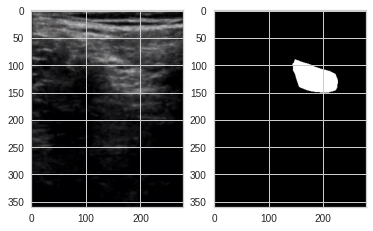

In [ ]:
img = cv2.imread(filepath_image[0])
mask = cv2.imread(filepath_mask[0])
height,width,_ = img.shape
print(height,'x',width)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask*255,cmap='gray')
plt.show()

In [ ]:
np.unique(mask)

array([0, 1], dtype=uint8)

### Data generator. 

In [ ]:
df_train_images

,filepath,nerve_name,mask
1142,./ImagenesNervios_/cubital_381_uf.png,cubital,./ImagenesNervios_/cubital_381_uf_mask.png
1059,./ImagenesNervios_/cubital_354.png,cubital,./ImagenesNervios_/cubital_354_mask.png
131,./ImagenesNervios_/ciatico_13_rf.png,ciatico,./ImagenesNervios_/ciatico_13_rf_mask.png
13,./ImagenesNervios_/ciatico_103_uf.png,ciatico,./ImagenesNervios_/ciatico_103_uf_mask.png
700,./ImagenesNervios_/ciatico_51.png,ciatico,./ImagenesNervios_/ciatico_51_mask.png
...,...,...,...
1235,./ImagenesNervios_/cubital_412_uf.png,cubital,./ImagenesNervios_/cubital_412_uf_mask.png
371,./ImagenesNervios_/ciatico_211.png,ciatico,./ImagenesNervios_/ciatico_211_mask.png
623,./ImagenesNervios_/ciatico_28_rf.png,ciatico,./ImagenesNervios_/ciatico_28_rf_mask.png
1702,./ImagenesNervios_/femoral_609_rf.png,femoral,./ImagenesNervios_/femoral_609_rf_mask.png


In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1188 validated image filenames.
Found 1188 validated image filenames.
Found 297 validated image filenames.
Found 297 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.


[0. 1.]


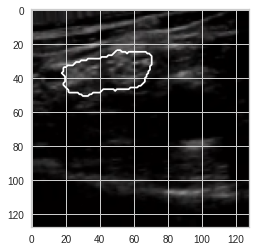

[0. 1.]


In [ ]:
i,j = next(train_gen)
print(np.unique(j))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()
print(np.unique(j))

In [ ]:
j.shape

(32, 128, 128, 1)

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.layers.experimental import RandomFourierFeatures
GAUSSIAN_NOISE = 0.1
ACTIVATION = 'relu'
def fcn(image_size, phi_units,ch_in=3, ch_out=1):
    
    # inputs = Input(shape=(*image_size, ch_in), name='input')

    # # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    # vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # # Recovering the feature maps generated by each of the 3 final blocks:
    # f3 = vgg16.get_layer('block3_pool').output  
    # f4 = vgg16.get_layer('block4_pool').output  
    # f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:

    inputs = Input((*image_size, ch_in), name = 'RGB_Input')
    gn_inputs = GaussianNoise(GAUSSIAN_NOISE)(inputs)
    bn_inputs = BatchNormalization()(gn_inputs)
    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (bn_inputs)

    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)
    f1 = BatchNormalization()(f1)
    f1 = MaxPooling2D((2, 2)) (f1)

    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)#(inputs)
    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f2)
    f2 = BatchNormalization()(f2)
    f2 = MaxPooling2D((2, 2)) (f2)

    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f2)#(inputs)
    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f3 = BatchNormalization()(f3)
    f3 = MaxPooling2D((2, 2)) (f3)

    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f4 = BatchNormalization()(f4)
    f4 = MaxPooling2D((2, 2)) (f4)

    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f5)
    f5 = BatchNormalization()(f5)
    f5 = MaxPooling2D((2, 2)) (f5)


    #%% Modified by CAJ
    flatten = Flatten()(f5)
    rff = RandomFourierFeatures(output_dim=int(height/32)*int(width/32)*phi_units,trainable=True,name = 'Phi')(flatten)
    resha = Reshape((int(height/32),int(width/32),-1))(rff)
    # f6 = Conv2D(ch_out, (1, 1), activation=ACTIVATION, padding='same') (resha)
    #%% End modify
    
    # f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
    #                   activation='relu')(resha)#(f5)
    # f5_drop1 = Dropout(0.5)(f5_conv1)
    # f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
    #                   activation='relu')(f5_drop1)
    # f5_drop2 = Dropout(0.5)(f5_conv2)
    # f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
    #                   activation=None)(f5_drop2)
    

    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(resha)#(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1,f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=1, kernel_size=16, strides=8,
                              padding='same', activation='sigmoid',name='output')(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

seg_model = fcn((128,128),1)

seg_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 128, 128, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128, 3)  12          gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 32) 896         batch_normalization_10[0][0]     
____________________________________________________________________________________________

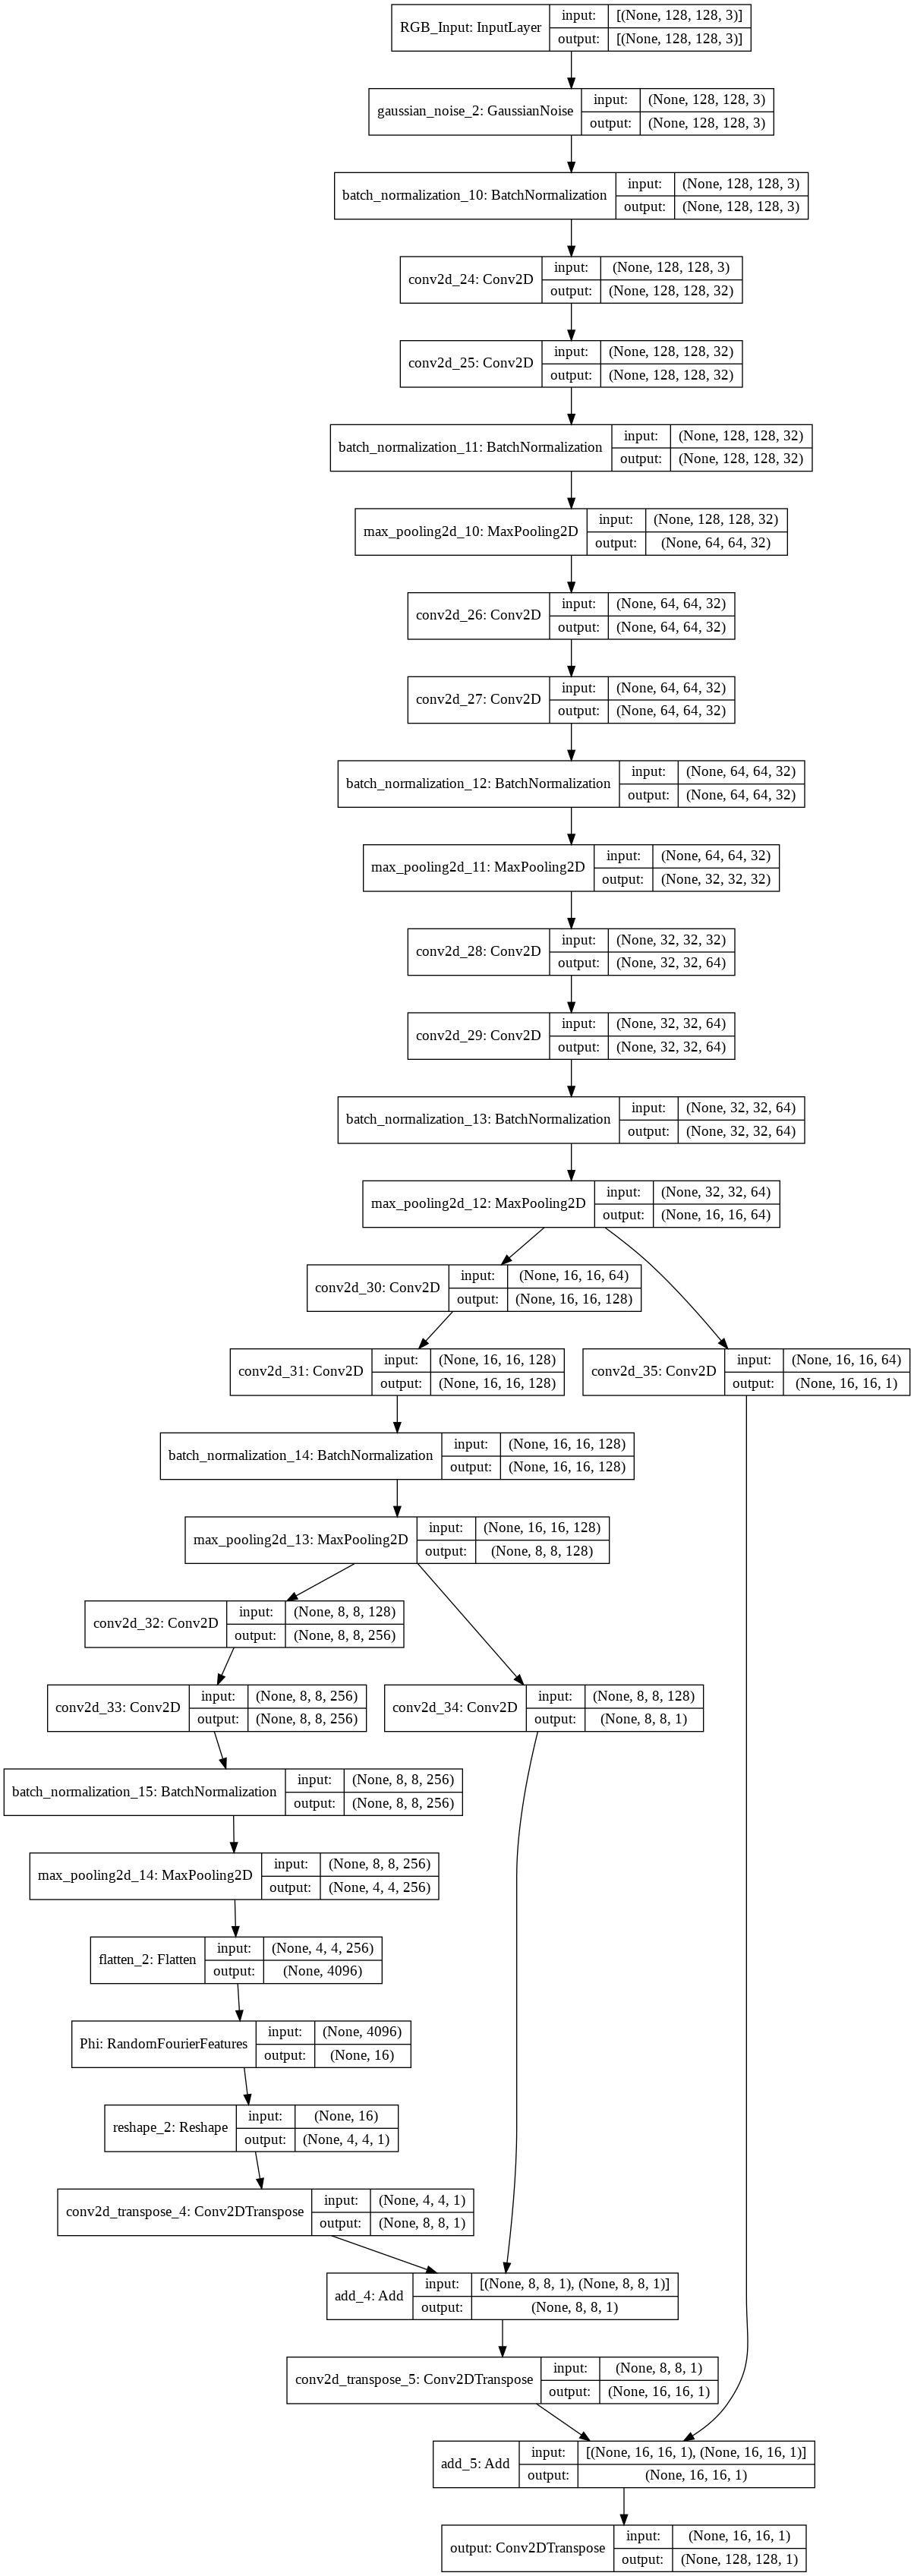

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
37/37 [==============================] - 15s 340ms/step - loss: -0.1920 - iou: 0.1085 - dice_coef: 0.1937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6800 - val_loss: -0.1015 - val_iou: 0.0535 - val_dice_coef: 0.1015 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9361


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 2/200
37/37 [==============================] - 11s 313ms/step - loss: -0.4498 - iou: 0.2947 - dice_coef: 0.4503 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9109 - val_loss: -0.0439 - val_iou: 0.0225 - val_dice_coef: 0.0439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9385


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 3/200
37/37 [==============================] - 12s 331ms/step - loss: -0.5809 - iou: 0.4121 - dice_coef: 0.5815 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9456 - val_loss: -0.0737 - val_iou: 0.0383 - val_dice_coef: 0.0737 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9385


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 4/200
37/37 [==============================] - 11s 306ms/step - loss: -0.6314 - iou: 0.4575 - dice_coef: 0.6249 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9535 - val_loss: -0.0592 - val_iou: 0.0305 - val_dice_coef: 0.0592 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9384


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 5/200
37/37 [==============================] - 11s 300ms/step - loss: -0.6528 - iou: 0.4874 - dice_coef: 0.6527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9552 - val_loss: -0.0554 - val_iou: 0.0285 - val_dice_coef: 0.0554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9375


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 6/200
37/37 [==============================] - 11s 300ms/step - loss: -0.6618 - iou: 0.4915 - dice_coef: 0.6569 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9570 - val_loss: -0.0571 - val_iou: 0.0294 - val_dice_coef: 0.0571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9385


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 7/200
37/37 [==============================] - 12s 330ms/step - loss: -0.6791 - iou: 0.5162 - dice_coef: 0.6787 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9600 - val_loss: -0.0354 - val_iou: 0.0181 - val_dice_coef: 0.0354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9381


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 8/200
37/37 [==============================] - 11s 319ms/step - loss: -0.7007 - iou: 0.5424 - dice_coef: 0.6999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9622 - val_loss: -0.1248 - val_iou: 0.0666 - val_dice_coef: 0.1248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9353


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 9/200
37/37 [==============================] - 11s 305ms/step - loss: -0.7064 - iou: 0.5513 - dice_coef: 0.7071 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9631 - val_loss: -0.2925 - val_iou: 0.1727 - val_dice_coef: 0.2925 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9453


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 10/200
37/37 [==============================] - 11s 298ms/step - loss: -0.7134 - iou: 0.5584 - dice_coef: 0.7145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9644 - val_loss: -0.3969 - val_iou: 0.2490 - val_dice_coef: 0.3969 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9500


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 11/200
37/37 [==============================] - 12s 330ms/step - loss: -0.7282 - iou: 0.5756 - dice_coef: 0.7279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9662 - val_loss: -0.5334 - val_iou: 0.3644 - val_dice_coef: 0.5334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9565


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 12/200
37/37 [==============================] - 12s 321ms/step - loss: -0.7291 - iou: 0.5786 - dice_coef: 0.7291 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9659 - val_loss: -0.3979 - val_iou: 0.2496 - val_dice_coef: 0.3979 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9513


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 13/200
37/37 [==============================] - 11s 310ms/step - loss: -0.7535 - iou: 0.6017 - dice_coef: 0.7505 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9695 - val_loss: -0.4220 - val_iou: 0.2696 - val_dice_coef: 0.4220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9525


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 14/200
37/37 [==============================] - 11s 298ms/step - loss: -0.7464 - iou: 0.5983 - dice_coef: 0.7451 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9687 - val_loss: -0.4808 - val_iou: 0.3216 - val_dice_coef: 0.4808 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9549


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 15/200
37/37 [==============================] - 12s 326ms/step - loss: -0.7545 - iou: 0.6092 - dice_coef: 0.7545 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9693 - val_loss: -0.6596 - val_iou: 0.4961 - val_dice_coef: 0.6596 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9644


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 16/200
37/37 [==============================] - 12s 326ms/step - loss: -0.7604 - iou: 0.6170 - dice_coef: 0.7608 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9703 - val_loss: -0.6495 - val_iou: 0.4885 - val_dice_coef: 0.6495 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9630


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 17/200
37/37 [==============================] - 11s 305ms/step - loss: -0.7724 - iou: 0.6323 - dice_coef: 0.7726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9715 - val_loss: -0.6215 - val_iou: 0.4670 - val_dice_coef: 0.6215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9625


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 18/200
37/37 [==============================] - 11s 300ms/step - loss: -0.7772 - iou: 0.6413 - dice_coef: 0.7786 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9722 - val_loss: -0.6361 - val_iou: 0.4778 - val_dice_coef: 0.6361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9633


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 19/200
37/37 [==============================] - 11s 317ms/step - loss: -0.7822 - iou: 0.6474 - dice_coef: 0.7829 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9724 - val_loss: -0.6456 - val_iou: 0.4819 - val_dice_coef: 0.6456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9646


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 20/200
37/37 [==============================] - 12s 329ms/step - loss: -0.7826 - iou: 0.6494 - dice_coef: 0.7837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9728 - val_loss: -0.6802 - val_iou: 0.5258 - val_dice_coef: 0.6802 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9646


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 21/200
37/37 [==============================] - 11s 317ms/step - loss: -0.7819 - iou: 0.6449 - dice_coef: 0.7818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9726 - val_loss: -0.6877 - val_iou: 0.5283 - val_dice_coef: 0.6877 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9659


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 22/200
37/37 [==============================] - 12s 329ms/step - loss: -0.7686 - iou: 0.6210 - dice_coef: 0.7633 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9709 - val_loss: -0.5379 - val_iou: 0.3718 - val_dice_coef: 0.5379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9580


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 23/200
37/37 [==============================] - 11s 297ms/step - loss: -0.7882 - iou: 0.6524 - dice_coef: 0.7876 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9735 - val_loss: -0.7094 - val_iou: 0.5552 - val_dice_coef: 0.7094 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9689


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 24/200
37/37 [==============================] - 11s 296ms/step - loss: -0.7938 - iou: 0.6629 - dice_coef: 0.7945 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9740 - val_loss: -0.7476 - val_iou: 0.6031 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9705


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 25/200
37/37 [==============================] - 11s 296ms/step - loss: -0.7984 - iou: 0.6674 - dice_coef: 0.7986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9747 - val_loss: -0.7241 - val_iou: 0.5730 - val_dice_coef: 0.7241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9696


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 26/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8021 - iou: 0.6740 - dice_coef: 0.8029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.7196 - val_iou: 0.5733 - val_dice_coef: 0.7196 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9691


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 27/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8029 - iou: 0.6752 - dice_coef: 0.8032 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.5913 - val_iou: 0.4224 - val_dice_coef: 0.5913 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9610


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 28/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8004 - iou: 0.6747 - dice_coef: 0.8013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.7080 - val_iou: 0.5571 - val_dice_coef: 0.7080 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9673


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 29/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8111 - iou: 0.6888 - dice_coef: 0.8125 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9756 - val_loss: -0.6790 - val_iou: 0.5264 - val_dice_coef: 0.6790 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9666


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 30/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8048 - iou: 0.6779 - dice_coef: 0.8049 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9758 - val_loss: -0.6917 - val_iou: 0.5393 - val_dice_coef: 0.6917 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 31/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8152 - iou: 0.6939 - dice_coef: 0.8163 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9770 - val_loss: -0.6998 - val_iou: 0.5521 - val_dice_coef: 0.6998 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9677


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 32/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8181 - iou: 0.6973 - dice_coef: 0.8183 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.7323 - val_iou: 0.5906 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9706


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 33/200
37/37 [==============================] - 11s 294ms/step - loss: -0.8212 - iou: 0.6977 - dice_coef: 0.8188 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9774 - val_loss: -0.7682 - val_iou: 0.6360 - val_dice_coef: 0.7682 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9719


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 34/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8176 - iou: 0.6976 - dice_coef: 0.8182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.7836 - val_iou: 0.6517 - val_dice_coef: 0.7836 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 35/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8218 - iou: 0.7002 - dice_coef: 0.8202 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9774 - val_loss: -0.7553 - val_iou: 0.6139 - val_dice_coef: 0.7553 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 36/200
37/37 [==============================] - 11s 296ms/step - loss: -0.8204 - iou: 0.6991 - dice_coef: 0.8191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9775 - val_loss: -0.7425 - val_iou: 0.6022 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9719


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 37/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8197 - iou: 0.7007 - dice_coef: 0.8212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9772 - val_loss: -0.7529 - val_iou: 0.6178 - val_dice_coef: 0.7529 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 38/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8306 - iou: 0.7149 - dice_coef: 0.8311 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.7595 - val_iou: 0.6216 - val_dice_coef: 0.7595 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 39/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8264 - iou: 0.7115 - dice_coef: 0.8272 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9783 - val_loss: -0.7734 - val_iou: 0.6419 - val_dice_coef: 0.7734 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9715


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 40/200
37/37 [==============================] - 11s 300ms/step - loss: -0.8288 - iou: 0.7121 - dice_coef: 0.8290 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9786 - val_loss: -0.7651 - val_iou: 0.6324 - val_dice_coef: 0.7651 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 41/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8249 - iou: 0.7104 - dice_coef: 0.8256 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9776 - val_loss: -0.6905 - val_iou: 0.5376 - val_dice_coef: 0.6905 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 42/200
37/37 [==============================] - 11s 296ms/step - loss: -0.8326 - iou: 0.7204 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -0.7413 - val_iou: 0.6059 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9706


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 43/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8402 - iou: 0.7291 - dice_coef: 0.8407 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9797 - val_loss: -0.7774 - val_iou: 0.6474 - val_dice_coef: 0.7774 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 44/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8366 - iou: 0.7240 - dice_coef: 0.8368 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.7794 - val_iou: 0.6494 - val_dice_coef: 0.7794 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 45/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8355 - iou: 0.7227 - dice_coef: 0.8359 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -0.7855 - val_iou: 0.6565 - val_dice_coef: 0.7855 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 46/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8354 - iou: 0.7246 - dice_coef: 0.8353 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.7592 - val_iou: 0.6260 - val_dice_coef: 0.7592 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9726


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 47/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8367 - iou: 0.7276 - dice_coef: 0.8371 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.7775 - val_iou: 0.6495 - val_dice_coef: 0.7775 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 48/200
37/37 [==============================] - 11s 298ms/step - loss: -0.8385 - iou: 0.7305 - dice_coef: 0.8401 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.7909 - val_iou: 0.6592 - val_dice_coef: 0.7909 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 49/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8408 - iou: 0.7311 - dice_coef: 0.8408 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -0.8069 - val_iou: 0.6815 - val_dice_coef: 0.8069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 50/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8487 - iou: 0.7409 - dice_coef: 0.8487 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7572 - val_iou: 0.6307 - val_dice_coef: 0.7572 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 51/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8543 - iou: 0.7346 - dice_coef: 0.8433 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.8044 - val_iou: 0.6825 - val_dice_coef: 0.8044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 52/200
37/37 [==============================] - 11s 298ms/step - loss: -0.8479 - iou: 0.7405 - dice_coef: 0.8477 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.7987 - val_iou: 0.6769 - val_dice_coef: 0.7987 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 53/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8433 - iou: 0.7350 - dice_coef: 0.8422 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.7487 - val_iou: 0.6159 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9719


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 54/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8498 - iou: 0.7440 - dice_coef: 0.8505 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.8048 - val_iou: 0.6834 - val_dice_coef: 0.8048 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 55/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8447 - iou: 0.7410 - dice_coef: 0.8457 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.7822 - val_iou: 0.6658 - val_dice_coef: 0.7822 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 56/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8542 - iou: 0.7497 - dice_coef: 0.8546 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7960 - val_iou: 0.6806 - val_dice_coef: 0.7960 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 57/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8484 - iou: 0.7395 - dice_coef: 0.8477 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.8139 - val_iou: 0.6907 - val_dice_coef: 0.8139 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 58/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8485 - iou: 0.7430 - dice_coef: 0.8491 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.8061 - val_iou: 0.6823 - val_dice_coef: 0.8061 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 59/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8450 - iou: 0.7399 - dice_coef: 0.8455 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -0.7816 - val_iou: 0.6599 - val_dice_coef: 0.7816 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 60/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8523 - iou: 0.7498 - dice_coef: 0.8530 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.7929 - val_iou: 0.6751 - val_dice_coef: 0.7929 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 61/200
37/37 [==============================] - 11s 296ms/step - loss: -0.8491 - iou: 0.7425 - dice_coef: 0.8492 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7990 - val_iou: 0.6754 - val_dice_coef: 0.7990 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 62/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8555 - iou: 0.7551 - dice_coef: 0.8560 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7890 - val_iou: 0.6611 - val_dice_coef: 0.7890 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 63/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8508 - iou: 0.7468 - dice_coef: 0.8514 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.8066 - val_iou: 0.6895 - val_dice_coef: 0.8066 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 64/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8407 - iou: 0.7273 - dice_coef: 0.8385 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.7236 - val_iou: 0.5867 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9692


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 65/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8397 - iou: 0.7301 - dice_coef: 0.8401 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.7519 - val_iou: 0.6194 - val_dice_coef: 0.7519 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9712


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 66/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8524 - iou: 0.7484 - dice_coef: 0.8531 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.7948 - val_iou: 0.6787 - val_dice_coef: 0.7948 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 67/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8559 - iou: 0.7523 - dice_coef: 0.8557 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.8182 - val_iou: 0.6978 - val_dice_coef: 0.8182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 68/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8532 - iou: 0.7511 - dice_coef: 0.8536 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.8250 - val_iou: 0.7070 - val_dice_coef: 0.8250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 69/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8588 - iou: 0.7585 - dice_coef: 0.8596 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.8315 - val_iou: 0.7168 - val_dice_coef: 0.8315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 70/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8610 - iou: 0.7633 - dice_coef: 0.8617 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.8329 - val_iou: 0.7179 - val_dice_coef: 0.8329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 71/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8657 - iou: 0.7693 - dice_coef: 0.8663 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.8376 - val_iou: 0.7235 - val_dice_coef: 0.8376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 72/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8602 - iou: 0.7645 - dice_coef: 0.8617 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.7985 - val_iou: 0.6893 - val_dice_coef: 0.7985 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 73/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8648 - iou: 0.7712 - dice_coef: 0.8657 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.8262 - val_iou: 0.7088 - val_dice_coef: 0.8262 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 74/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8634 - iou: 0.7663 - dice_coef: 0.8637 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.8013 - val_iou: 0.6888 - val_dice_coef: 0.8013 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 75/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8641 - iou: 0.7658 - dice_coef: 0.8635 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.8045 - val_iou: 0.6872 - val_dice_coef: 0.8045 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 76/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8697 - iou: 0.7695 - dice_coef: 0.8653 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.8131 - val_iou: 0.7026 - val_dice_coef: 0.8131 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 77/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8647 - iou: 0.7634 - dice_coef: 0.8629 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.8213 - val_iou: 0.7051 - val_dice_coef: 0.8213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 78/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8563 - iou: 0.7577 - dice_coef: 0.8570 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7835 - val_iou: 0.6665 - val_dice_coef: 0.7835 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9735


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 79/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8641 - iou: 0.7663 - dice_coef: 0.8646 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.8058 - val_iou: 0.6903 - val_dice_coef: 0.8058 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 80/200
37/37 [==============================] - 11s 296ms/step - loss: -0.8684 - iou: 0.7722 - dice_coef: 0.8681 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.8143 - val_iou: 0.7021 - val_dice_coef: 0.8143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 81/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8712 - iou: 0.7705 - dice_coef: 0.8678 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8065 - val_iou: 0.6812 - val_dice_coef: 0.8065 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 82/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8613 - iou: 0.7605 - dice_coef: 0.8617 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.7983 - val_iou: 0.6802 - val_dice_coef: 0.7983 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 83/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8590 - iou: 0.7593 - dice_coef: 0.8586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.7962 - val_iou: 0.6727 - val_dice_coef: 0.7962 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 84/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8572 - iou: 0.7565 - dice_coef: 0.8578 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.7852 - val_iou: 0.6679 - val_dice_coef: 0.7852 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 85/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8631 - iou: 0.7646 - dice_coef: 0.8635 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.8034 - val_iou: 0.6916 - val_dice_coef: 0.8034 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 86/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8697 - iou: 0.7736 - dice_coef: 0.8691 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8006 - val_iou: 0.6888 - val_dice_coef: 0.8006 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 87/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8559 - iou: 0.7571 - dice_coef: 0.8569 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7931 - val_iou: 0.6774 - val_dice_coef: 0.7931 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 88/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8635 - iou: 0.7668 - dice_coef: 0.8635 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.8615 - val_iou: 0.7569 - val_dice_coef: 0.8615 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 89/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8841 - iou: 0.7926 - dice_coef: 0.8842 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8026 - val_iou: 0.6884 - val_dice_coef: 0.8026 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 90/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8739 - iou: 0.7806 - dice_coef: 0.8739 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.8014 - val_iou: 0.6901 - val_dice_coef: 0.8014 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 91/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8671 - iou: 0.7733 - dice_coef: 0.8673 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8119 - val_iou: 0.7034 - val_dice_coef: 0.8119 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 92/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8715 - iou: 0.7784 - dice_coef: 0.8719 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8227 - val_iou: 0.7117 - val_dice_coef: 0.8227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 93/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8754 - iou: 0.7859 - dice_coef: 0.8760 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8274 - val_iou: 0.7178 - val_dice_coef: 0.8274 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 94/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8735 - iou: 0.7841 - dice_coef: 0.8743 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.8166 - val_iou: 0.7099 - val_dice_coef: 0.8166 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 95/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8766 - iou: 0.7883 - dice_coef: 0.8773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8346 - val_iou: 0.7289 - val_dice_coef: 0.8346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 96/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8714 - iou: 0.7797 - dice_coef: 0.8711 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8385 - val_iou: 0.7333 - val_dice_coef: 0.8385 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 97/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8771 - iou: 0.7858 - dice_coef: 0.8771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8158 - val_iou: 0.7096 - val_dice_coef: 0.8158 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 98/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8738 - iou: 0.7828 - dice_coef: 0.8735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8325 - val_iou: 0.7284 - val_dice_coef: 0.8325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 99/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8772 - iou: 0.7900 - dice_coef: 0.8775 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8527 - val_iou: 0.7464 - val_dice_coef: 0.8527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 100/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8758 - iou: 0.7840 - dice_coef: 0.8752 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8323 - val_iou: 0.7213 - val_dice_coef: 0.8323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 101/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8712 - iou: 0.7778 - dice_coef: 0.8707 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.8078 - val_iou: 0.7001 - val_dice_coef: 0.8078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 102/200
37/37 [==============================] - 11s 300ms/step - loss: -0.8733 - iou: 0.7839 - dice_coef: 0.8740 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8275 - val_iou: 0.7217 - val_dice_coef: 0.8275 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 103/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8807 - iou: 0.7920 - dice_coef: 0.8807 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8216 - val_iou: 0.7129 - val_dice_coef: 0.8216 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 104/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8803 - iou: 0.7934 - dice_coef: 0.8810 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8438 - val_iou: 0.7382 - val_dice_coef: 0.8438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 105/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8787 - iou: 0.7850 - dice_coef: 0.8753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8485 - val_iou: 0.7414 - val_dice_coef: 0.8485 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 106/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8736 - iou: 0.7822 - dice_coef: 0.8736 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.8107 - val_iou: 0.7043 - val_dice_coef: 0.8107 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 107/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8817 - iou: 0.7937 - dice_coef: 0.8817 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8485 - val_iou: 0.7430 - val_dice_coef: 0.8485 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 108/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8770 - iou: 0.7821 - dice_coef: 0.8718 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8067 - val_iou: 0.7029 - val_dice_coef: 0.8067 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 109/200
37/37 [==============================] - 11s 298ms/step - loss: -0.8794 - iou: 0.7942 - dice_coef: 0.8806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8158 - val_iou: 0.7145 - val_dice_coef: 0.8158 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 110/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8843 - iou: 0.7988 - dice_coef: 0.8848 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8108 - val_iou: 0.6970 - val_dice_coef: 0.8108 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 111/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8805 - iou: 0.7925 - dice_coef: 0.8801 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8402 - val_iou: 0.7332 - val_dice_coef: 0.8402 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 112/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8779 - iou: 0.7912 - dice_coef: 0.8781 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8187 - val_iou: 0.7172 - val_dice_coef: 0.8187 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 113/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8834 - iou: 0.7975 - dice_coef: 0.8836 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8281 - val_iou: 0.7215 - val_dice_coef: 0.8281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 114/200
37/37 [==============================] - 11s 297ms/step - loss: -0.8843 - iou: 0.7959 - dice_coef: 0.8827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8078 - val_iou: 0.7047 - val_dice_coef: 0.8078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 115/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8783 - iou: 0.7922 - dice_coef: 0.8788 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8126 - val_iou: 0.7090 - val_dice_coef: 0.8126 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 116/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8813 - iou: 0.7965 - dice_coef: 0.8821 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8525 - val_iou: 0.7486 - val_dice_coef: 0.8525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 117/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8820 - iou: 0.7935 - dice_coef: 0.8802 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7938 - val_iou: 0.6730 - val_dice_coef: 0.7938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9744


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 118/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8737 - iou: 0.7735 - dice_coef: 0.8682 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.8142 - val_iou: 0.7025 - val_dice_coef: 0.8142 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 119/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8780 - iou: 0.7878 - dice_coef: 0.8780 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8303 - val_iou: 0.7234 - val_dice_coef: 0.8303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 120/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8799 - iou: 0.7920 - dice_coef: 0.8793 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7977 - val_iou: 0.6786 - val_dice_coef: 0.7977 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 121/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8767 - iou: 0.7834 - dice_coef: 0.8759 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8053 - val_iou: 0.6892 - val_dice_coef: 0.8053 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 122/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8771 - iou: 0.7838 - dice_coef: 0.8753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8157 - val_iou: 0.7017 - val_dice_coef: 0.8157 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 123/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8767 - iou: 0.7860 - dice_coef: 0.8769 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8160 - val_iou: 0.7107 - val_dice_coef: 0.8160 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 124/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8817 - iou: 0.7946 - dice_coef: 0.8809 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8243 - val_iou: 0.7199 - val_dice_coef: 0.8243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 125/200
37/37 [==============================] - 11s 300ms/step - loss: -0.8806 - iou: 0.7953 - dice_coef: 0.8809 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8252 - val_iou: 0.7256 - val_dice_coef: 0.8252 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 126/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8883 - iou: 0.8040 - dice_coef: 0.8883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8806 - val_iou: 0.7868 - val_dice_coef: 0.8806 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9856


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 127/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8992 - iou: 0.8154 - dice_coef: 0.8982 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8374 - val_iou: 0.7381 - val_dice_coef: 0.8374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 128/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8802 - iou: 0.7920 - dice_coef: 0.8796 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8271 - val_iou: 0.7272 - val_dice_coef: 0.8271 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 129/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8844 - iou: 0.8012 - dice_coef: 0.8847 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8356 - val_iou: 0.7319 - val_dice_coef: 0.8356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 130/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8863 - iou: 0.8021 - dice_coef: 0.8865 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8265 - val_iou: 0.7321 - val_dice_coef: 0.8265 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 131/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8877 - iou: 0.8064 - dice_coef: 0.8883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8505 - val_iou: 0.7503 - val_dice_coef: 0.8505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 132/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8890 - iou: 0.8044 - dice_coef: 0.8882 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8387 - val_iou: 0.7402 - val_dice_coef: 0.8387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 133/200
37/37 [==============================] - 11s 298ms/step - loss: -0.8863 - iou: 0.8026 - dice_coef: 0.8864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8309 - val_iou: 0.7330 - val_dice_coef: 0.8309 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 134/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8825 - iou: 0.7985 - dice_coef: 0.8826 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8292 - val_iou: 0.7331 - val_dice_coef: 0.8292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 135/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8856 - iou: 0.8032 - dice_coef: 0.8860 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8385 - val_iou: 0.7382 - val_dice_coef: 0.8385 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 136/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8899 - iou: 0.8083 - dice_coef: 0.8903 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8453 - val_iou: 0.7474 - val_dice_coef: 0.8453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 137/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8869 - iou: 0.8048 - dice_coef: 0.8872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8508 - val_iou: 0.7482 - val_dice_coef: 0.8508 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 138/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8926 - iou: 0.8103 - dice_coef: 0.8922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8200 - val_iou: 0.7263 - val_dice_coef: 0.8200 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 139/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8881 - iou: 0.8058 - dice_coef: 0.8883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8470 - val_iou: 0.7473 - val_dice_coef: 0.8470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 140/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8908 - iou: 0.8089 - dice_coef: 0.8906 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8521 - val_iou: 0.7504 - val_dice_coef: 0.8521 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 141/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8946 - iou: 0.8141 - dice_coef: 0.8952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8320 - val_iou: 0.7335 - val_dice_coef: 0.8320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 142/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8935 - iou: 0.8127 - dice_coef: 0.8937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8507 - val_iou: 0.7528 - val_dice_coef: 0.8507 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 143/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8884 - iou: 0.8089 - dice_coef: 0.8890 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8264 - val_iou: 0.7299 - val_dice_coef: 0.8264 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 144/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8834 - iou: 0.7932 - dice_coef: 0.8809 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8239 - val_iou: 0.7177 - val_dice_coef: 0.8239 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 145/200
37/37 [==============================] - 11s 298ms/step - loss: -0.8881 - iou: 0.8036 - dice_coef: 0.8882 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8635 - val_iou: 0.7630 - val_dice_coef: 0.8635 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 146/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8916 - iou: 0.8091 - dice_coef: 0.8921 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8412 - val_iou: 0.7359 - val_dice_coef: 0.8412 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 147/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8846 - iou: 0.7898 - dice_coef: 0.8784 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8337 - val_iou: 0.7276 - val_dice_coef: 0.8337 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 148/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8902 - iou: 0.8056 - dice_coef: 0.8905 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8373 - val_iou: 0.7373 - val_dice_coef: 0.8373 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 149/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8863 - iou: 0.8055 - dice_coef: 0.8868 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8314 - val_iou: 0.7303 - val_dice_coef: 0.8314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 150/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8919 - iou: 0.8119 - dice_coef: 0.8918 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8522 - val_iou: 0.7518 - val_dice_coef: 0.8522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 151/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8921 - iou: 0.8117 - dice_coef: 0.8928 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8322 - val_iou: 0.7342 - val_dice_coef: 0.8322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 152/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8970 - iou: 0.8179 - dice_coef: 0.8972 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8586 - val_iou: 0.7598 - val_dice_coef: 0.8586 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 153/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8945 - iou: 0.8145 - dice_coef: 0.8947 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8354 - val_iou: 0.7377 - val_dice_coef: 0.8354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 154/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8884 - iou: 0.8095 - dice_coef: 0.8882 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8251 - val_iou: 0.7278 - val_dice_coef: 0.8251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 155/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8906 - iou: 0.8104 - dice_coef: 0.8906 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8367 - val_iou: 0.7367 - val_dice_coef: 0.8367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 156/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8969 - iou: 0.8187 - dice_coef: 0.8974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8300 - val_iou: 0.7343 - val_dice_coef: 0.8300 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 157/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8952 - iou: 0.8171 - dice_coef: 0.8958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8538 - val_iou: 0.7575 - val_dice_coef: 0.8538 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 158/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8929 - iou: 0.8164 - dice_coef: 0.8929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8600 - val_iou: 0.7610 - val_dice_coef: 0.8600 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 159/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8953 - iou: 0.8134 - dice_coef: 0.8926 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8298 - val_iou: 0.7365 - val_dice_coef: 0.8298 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 160/200
37/37 [==============================] - 11s 299ms/step - loss: -0.9000 - iou: 0.8202 - dice_coef: 0.8987 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8554 - val_iou: 0.7594 - val_dice_coef: 0.8554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 161/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8941 - iou: 0.8148 - dice_coef: 0.8942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8315 - val_iou: 0.7358 - val_dice_coef: 0.8315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 162/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8955 - iou: 0.8188 - dice_coef: 0.8962 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8371 - val_iou: 0.7431 - val_dice_coef: 0.8371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 163/200
37/37 [==============================] - 11s 300ms/step - loss: -0.8973 - iou: 0.8195 - dice_coef: 0.8973 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8697 - val_iou: 0.7736 - val_dice_coef: 0.8697 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 164/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8963 - iou: 0.8187 - dice_coef: 0.8963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8918 - val_iou: 0.8049 - val_dice_coef: 0.8918 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9868


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 165/200
37/37 [==============================] - 11s 313ms/step - loss: -0.9095 - iou: 0.8344 - dice_coef: 0.9097 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.8635 - val_iou: 0.7678 - val_dice_coef: 0.8635 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 166/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9036 - iou: 0.8281 - dice_coef: 0.9036 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8690 - val_iou: 0.7744 - val_dice_coef: 0.8690 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 167/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8975 - iou: 0.8138 - dice_coef: 0.8935 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8461 - val_iou: 0.7477 - val_dice_coef: 0.8461 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 168/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8902 - iou: 0.8060 - dice_coef: 0.8877 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8559 - val_iou: 0.7557 - val_dice_coef: 0.8559 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 169/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8961 - iou: 0.8180 - dice_coef: 0.8966 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8434 - val_iou: 0.7489 - val_dice_coef: 0.8434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 170/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8942 - iou: 0.8157 - dice_coef: 0.8936 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8457 - val_iou: 0.7497 - val_dice_coef: 0.8457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 171/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8973 - iou: 0.8220 - dice_coef: 0.8979 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8508 - val_iou: 0.7533 - val_dice_coef: 0.8508 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 172/200
37/37 [==============================] - 12s 332ms/step - loss: -0.9003 - iou: 0.8229 - dice_coef: 0.9002 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8454 - val_iou: 0.7489 - val_dice_coef: 0.8454 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 173/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8945 - iou: 0.8126 - dice_coef: 0.8913 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8345 - val_iou: 0.7398 - val_dice_coef: 0.8345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 174/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8988 - iou: 0.8199 - dice_coef: 0.8976 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8355 - val_iou: 0.7361 - val_dice_coef: 0.8355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 175/200
37/37 [==============================] - 11s 299ms/step - loss: -0.8963 - iou: 0.8205 - dice_coef: 0.8964 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8463 - val_iou: 0.7504 - val_dice_coef: 0.8463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 176/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9036 - iou: 0.8285 - dice_coef: 0.9042 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8800 - val_iou: 0.7871 - val_dice_coef: 0.8800 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9855


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 177/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8984 - iou: 0.8205 - dice_coef: 0.8973 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8597 - val_iou: 0.7639 - val_dice_coef: 0.8597 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 178/200
37/37 [==============================] - 11s 304ms/step - loss: -0.9047 - iou: 0.8294 - dice_coef: 0.9045 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8414 - val_iou: 0.7512 - val_dice_coef: 0.8414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 179/200
37/37 [==============================] - 11s 300ms/step - loss: -0.8974 - iou: 0.8213 - dice_coef: 0.8977 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8342 - val_iou: 0.7438 - val_dice_coef: 0.8342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 180/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8978 - iou: 0.8226 - dice_coef: 0.8985 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8689 - val_iou: 0.7743 - val_dice_coef: 0.8689 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 181/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9008 - iou: 0.8261 - dice_coef: 0.9012 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8386 - val_iou: 0.7422 - val_dice_coef: 0.8386 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 182/200
37/37 [==============================] - 11s 301ms/step - loss: -0.9010 - iou: 0.8219 - dice_coef: 0.8992 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8443 - val_iou: 0.7462 - val_dice_coef: 0.8443 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 183/200
37/37 [==============================] - 11s 303ms/step - loss: -0.9021 - iou: 0.8258 - dice_coef: 0.9018 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8537 - val_iou: 0.7590 - val_dice_coef: 0.8537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 184/200
37/37 [==============================] - 11s 311ms/step - loss: -0.9007 - iou: 0.8248 - dice_coef: 0.9004 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8419 - val_iou: 0.7452 - val_dice_coef: 0.8419 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 185/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9070 - iou: 0.8328 - dice_coef: 0.9067 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8453 - val_iou: 0.7523 - val_dice_coef: 0.8453 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 186/200
37/37 [==============================] - 11s 305ms/step - loss: -0.9024 - iou: 0.8260 - dice_coef: 0.9022 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8312 - val_iou: 0.7381 - val_dice_coef: 0.8312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 187/200
37/37 [==============================] - 11s 304ms/step - loss: -0.9001 - iou: 0.8238 - dice_coef: 0.8998 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8434 - val_iou: 0.7495 - val_dice_coef: 0.8434 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 188/200
37/37 [==============================] - 11s 303ms/step - loss: -0.9037 - iou: 0.8284 - dice_coef: 0.9039 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8308 - val_iou: 0.7379 - val_dice_coef: 0.8308 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 189/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8970 - iou: 0.8215 - dice_coef: 0.8972 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8617 - val_iou: 0.7657 - val_dice_coef: 0.8617 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 190/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8980 - iou: 0.8196 - dice_coef: 0.8981 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8456 - val_iou: 0.7405 - val_dice_coef: 0.8456 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 191/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8960 - iou: 0.8214 - dice_coef: 0.8961 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8283 - val_iou: 0.7317 - val_dice_coef: 0.8283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 192/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8968 - iou: 0.8184 - dice_coef: 0.8969 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8567 - val_iou: 0.7620 - val_dice_coef: 0.8567 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 193/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8980 - iou: 0.8240 - dice_coef: 0.8982 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8706 - val_iou: 0.7783 - val_dice_coef: 0.8706 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 194/200
37/37 [==============================] - 11s 299ms/step - loss: -0.9016 - iou: 0.8252 - dice_coef: 0.9014 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8508 - val_iou: 0.7516 - val_dice_coef: 0.8508 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 195/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8965 - iou: 0.8212 - dice_coef: 0.8970 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8618 - val_iou: 0.7655 - val_dice_coef: 0.8618 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 196/200
37/37 [==============================] - 12s 325ms/step - loss: -0.9031 - iou: 0.8284 - dice_coef: 0.9031 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8302 - val_iou: 0.7421 - val_dice_coef: 0.8302 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 197/200
37/37 [==============================] - 11s 307ms/step - loss: -0.9016 - iou: 0.8259 - dice_coef: 0.9008 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8371 - val_iou: 0.7403 - val_dice_coef: 0.8371 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 198/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8966 - iou: 0.8212 - dice_coef: 0.8963 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8388 - val_iou: 0.7492 - val_dice_coef: 0.8388 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 199/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8998 - iou: 0.8251 - dice_coef: 0.8997 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8392 - val_iou: 0.7440 - val_dice_coef: 0.8392 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


Epoch 200/200
37/37 [==============================] - 12s 334ms/step - loss: -0.9004 - iou: 0.8247 - dice_coef: 0.9006 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8557 - val_iou: 0.7609 - val_dice_coef: 0.8557 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-8/Model_Checkpoint/assets


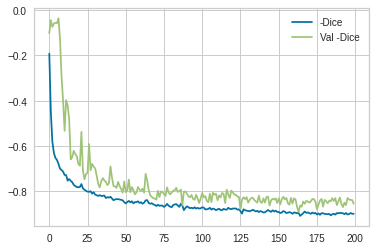

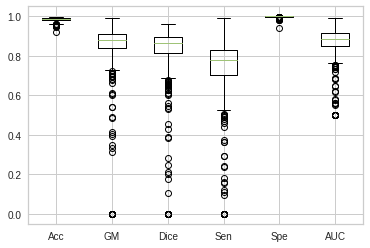

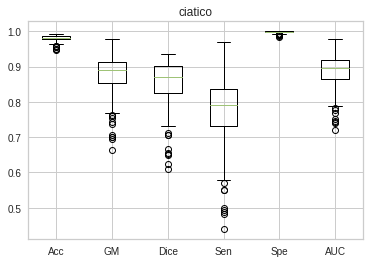

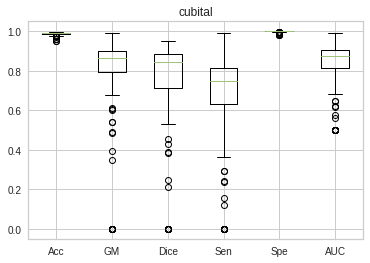

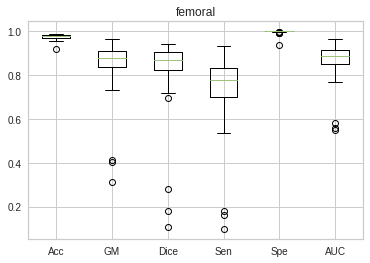

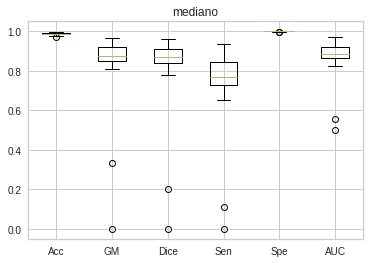

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
37/37 [==============================] - 14s 325ms/step - loss: -0.1862 - iou: 0.1043 - dice_coef: 0.1873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6680 - val_loss: -0.1093 - val_iou: 0.0578 - val_dice_coef: 0.1093 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9257


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 2/200
37/37 [==============================] - 12s 331ms/step - loss: -0.4293 - iou: 0.2781 - dice_coef: 0.4311 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9113 - val_loss: -0.0219 - val_iou: 0.0111 - val_dice_coef: 0.0219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9386


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 3/200
37/37 [==============================] - 11s 304ms/step - loss: -0.5632 - iou: 0.3954 - dice_coef: 0.5632 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9421 - val_loss: -0.0674 - val_iou: 0.0349 - val_dice_coef: 0.0674 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9379


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 4/200
37/37 [==============================] - 11s 307ms/step - loss: -0.6329 - iou: 0.4674 - dice_coef: 0.6359 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9543 - val_loss: -0.0956 - val_iou: 0.0502 - val_dice_coef: 0.0956 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9383


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 5/200
37/37 [==============================] - 11s 305ms/step - loss: -0.6438 - iou: 0.4818 - dice_coef: 0.6473 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9543 - val_loss: -0.0543 - val_iou: 0.0279 - val_dice_coef: 0.0543 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9381


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 6/200
37/37 [==============================] - 12s 333ms/step - loss: -0.6546 - iou: 0.4818 - dice_coef: 0.6464 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9563 - val_loss: -0.0160 - val_iou: 0.0081 - val_dice_coef: 0.0160 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9384


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 7/200
37/37 [==============================] - 11s 311ms/step - loss: -0.6779 - iou: 0.5186 - dice_coef: 0.6789 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9605 - val_loss: -0.0141 - val_iou: 0.0071 - val_dice_coef: 0.0141 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9375


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 8/200
37/37 [==============================] - 11s 304ms/step - loss: -0.6932 - iou: 0.5350 - dice_coef: 0.6948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9618 - val_loss: -0.0154 - val_iou: 0.0078 - val_dice_coef: 0.0154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9381


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 9/200
37/37 [==============================] - 11s 308ms/step - loss: -0.7064 - iou: 0.5500 - dice_coef: 0.7063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9629 - val_loss: -0.0100 - val_iou: 0.0051 - val_dice_coef: 0.0100 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9386


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 10/200
37/37 [==============================] - 12s 335ms/step - loss: -0.7238 - iou: 0.5710 - dice_coef: 0.7245 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9661 - val_loss: -0.1735 - val_iou: 0.0967 - val_dice_coef: 0.1735 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9431


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 11/200
37/37 [==============================] - 12s 323ms/step - loss: -0.7204 - iou: 0.5646 - dice_coef: 0.7189 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9654 - val_loss: -0.0268 - val_iou: 0.0136 - val_dice_coef: 0.0268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9383


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 12/200
37/37 [==============================] - 12s 333ms/step - loss: -0.7316 - iou: 0.5801 - dice_coef: 0.7305 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9672 - val_loss: -0.1243 - val_iou: 0.0665 - val_dice_coef: 0.1243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9411


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 13/200
37/37 [==============================] - 11s 317ms/step - loss: -0.7408 - iou: 0.5879 - dice_coef: 0.7379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9679 - val_loss: -0.4008 - val_iou: 0.2545 - val_dice_coef: 0.4008 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9518


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 14/200
37/37 [==============================] - 11s 311ms/step - loss: -0.7539 - iou: 0.6094 - dice_coef: 0.7544 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9696 - val_loss: -0.3472 - val_iou: 0.2124 - val_dice_coef: 0.3472 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9488


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 15/200
37/37 [==============================] - 11s 300ms/step - loss: -0.7595 - iou: 0.6171 - dice_coef: 0.7609 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9699 - val_loss: -0.3853 - val_iou: 0.2408 - val_dice_coef: 0.3853 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9511


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 16/200
37/37 [==============================] - 12s 335ms/step - loss: -0.7624 - iou: 0.6185 - dice_coef: 0.7609 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.4157 - val_iou: 0.2645 - val_dice_coef: 0.4157 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9512


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 17/200
37/37 [==============================] - 12s 338ms/step - loss: -0.7658 - iou: 0.6281 - dice_coef: 0.7672 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9707 - val_loss: -0.5366 - val_iou: 0.3732 - val_dice_coef: 0.5366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9580


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 18/200
37/37 [==============================] - 11s 306ms/step - loss: -0.7739 - iou: 0.6361 - dice_coef: 0.7752 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9724 - val_loss: -0.6346 - val_iou: 0.4754 - val_dice_coef: 0.6346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9625


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 19/200
37/37 [==============================] - 11s 301ms/step - loss: -0.7756 - iou: 0.6333 - dice_coef: 0.7722 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9721 - val_loss: -0.4868 - val_iou: 0.3243 - val_dice_coef: 0.4868 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9556


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 20/200
37/37 [==============================] - 12s 324ms/step - loss: -0.7772 - iou: 0.6341 - dice_coef: 0.7728 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9718 - val_loss: -0.5235 - val_iou: 0.3607 - val_dice_coef: 0.5235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9563


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 21/200
37/37 [==============================] - 12s 333ms/step - loss: -0.7860 - iou: 0.6480 - dice_coef: 0.7846 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9734 - val_loss: -0.4996 - val_iou: 0.3361 - val_dice_coef: 0.4996 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9567


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 22/200
37/37 [==============================] - 11s 308ms/step - loss: -0.7897 - iou: 0.6535 - dice_coef: 0.7894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9737 - val_loss: -0.5693 - val_iou: 0.4079 - val_dice_coef: 0.5693 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9584


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 23/200
37/37 [==============================] - 11s 302ms/step - loss: -0.7926 - iou: 0.6596 - dice_coef: 0.7922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9743 - val_loss: -0.6324 - val_iou: 0.4781 - val_dice_coef: 0.6324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9595


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 24/200
37/37 [==============================] - 11s 315ms/step - loss: -0.7917 - iou: 0.6590 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9740 - val_loss: -0.5947 - val_iou: 0.4346 - val_dice_coef: 0.5947 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9598


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 25/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8004 - iou: 0.6715 - dice_coef: 0.8015 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.5978 - val_iou: 0.4362 - val_dice_coef: 0.5978 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9607


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 26/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8042 - iou: 0.6766 - dice_coef: 0.8033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9758 - val_loss: -0.6257 - val_iou: 0.4621 - val_dice_coef: 0.6257 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9626


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 27/200
37/37 [==============================] - 11s 305ms/step - loss: -0.7969 - iou: 0.6665 - dice_coef: 0.7958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -0.6709 - val_iou: 0.5081 - val_dice_coef: 0.6709 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 28/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8092 - iou: 0.6817 - dice_coef: 0.8080 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9760 - val_loss: -0.6079 - val_iou: 0.4415 - val_dice_coef: 0.6079 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9626


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 29/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8040 - iou: 0.6750 - dice_coef: 0.8031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9758 - val_loss: -0.6132 - val_iou: 0.4464 - val_dice_coef: 0.6132 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9628


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 30/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8072 - iou: 0.6838 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -0.6560 - val_iou: 0.4960 - val_dice_coef: 0.6560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9649


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 31/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8125 - iou: 0.6893 - dice_coef: 0.8131 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9768 - val_loss: -0.6214 - val_iou: 0.4554 - val_dice_coef: 0.6214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9634


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 32/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8087 - iou: 0.6807 - dice_coef: 0.8057 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9758 - val_loss: -0.6437 - val_iou: 0.4804 - val_dice_coef: 0.6437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9641


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 33/200
37/37 [==============================] - 11s 308ms/step - loss: -0.7914 - iou: 0.6621 - dice_coef: 0.7929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9743 - val_loss: -0.7195 - val_iou: 0.5737 - val_dice_coef: 0.7195 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 34/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8176 - iou: 0.6898 - dice_coef: 0.8144 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -0.6632 - val_iou: 0.5057 - val_dice_coef: 0.6632 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9644


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 35/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8084 - iou: 0.6839 - dice_coef: 0.8086 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9761 - val_loss: -0.6583 - val_iou: 0.5025 - val_dice_coef: 0.6583 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9643


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 36/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8194 - iou: 0.6985 - dice_coef: 0.8202 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.6559 - val_iou: 0.4962 - val_dice_coef: 0.6559 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9656


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 37/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8224 - iou: 0.7043 - dice_coef: 0.8230 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.6625 - val_iou: 0.5069 - val_dice_coef: 0.6625 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9652


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 38/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8243 - iou: 0.7028 - dice_coef: 0.8236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -0.7018 - val_iou: 0.5485 - val_dice_coef: 0.7018 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9677


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 39/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8213 - iou: 0.7031 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.6944 - val_iou: 0.5443 - val_dice_coef: 0.6944 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9673


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 40/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8200 - iou: 0.7011 - dice_coef: 0.8209 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.6998 - val_iou: 0.5463 - val_dice_coef: 0.6998 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9677


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 41/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8280 - iou: 0.7119 - dice_coef: 0.8280 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.7549 - val_iou: 0.6073 - val_dice_coef: 0.7549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 42/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8299 - iou: 0.7092 - dice_coef: 0.8297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.6907 - val_iou: 0.5300 - val_dice_coef: 0.6907 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9690


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 43/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8258 - iou: 0.7094 - dice_coef: 0.8265 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -0.7437 - val_iou: 0.5987 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 44/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8313 - iou: 0.7153 - dice_coef: 0.8312 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9786 - val_loss: -0.7685 - val_iou: 0.6380 - val_dice_coef: 0.7685 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 45/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8299 - iou: 0.7133 - dice_coef: 0.8293 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9788 - val_loss: -0.7525 - val_iou: 0.6174 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 46/200
37/37 [==============================] - 11s 300ms/step - loss: -0.8346 - iou: 0.7220 - dice_coef: 0.8349 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -0.7484 - val_iou: 0.6106 - val_dice_coef: 0.7484 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 47/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8393 - iou: 0.7268 - dice_coef: 0.8394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.7794 - val_iou: 0.6561 - val_dice_coef: 0.7794 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 48/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8219 - iou: 0.7027 - dice_coef: 0.8212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -0.7559 - val_iou: 0.6207 - val_dice_coef: 0.7559 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9715


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 49/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8361 - iou: 0.7179 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -0.7485 - val_iou: 0.6121 - val_dice_coef: 0.7485 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9711


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 50/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8399 - iou: 0.7296 - dice_coef: 0.8403 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9797 - val_loss: -0.7783 - val_iou: 0.6507 - val_dice_coef: 0.7783 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 51/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8399 - iou: 0.7301 - dice_coef: 0.8402 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.7830 - val_iou: 0.6528 - val_dice_coef: 0.7830 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 52/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8429 - iou: 0.7343 - dice_coef: 0.8433 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -0.7900 - val_iou: 0.6657 - val_dice_coef: 0.7900 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 53/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8405 - iou: 0.7299 - dice_coef: 0.8412 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -0.7899 - val_iou: 0.6694 - val_dice_coef: 0.7899 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 54/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8434 - iou: 0.7315 - dice_coef: 0.8419 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.7973 - val_iou: 0.6719 - val_dice_coef: 0.7973 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 55/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8378 - iou: 0.7277 - dice_coef: 0.8383 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.7514 - val_iou: 0.6121 - val_dice_coef: 0.7514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 56/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8460 - iou: 0.7348 - dice_coef: 0.8451 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.7281 - val_iou: 0.5885 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9705


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 57/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8437 - iou: 0.7365 - dice_coef: 0.8440 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.7126 - val_iou: 0.5654 - val_dice_coef: 0.7126 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9691


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 58/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8473 - iou: 0.7380 - dice_coef: 0.8462 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.7228 - val_iou: 0.5769 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9695


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 59/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8431 - iou: 0.7370 - dice_coef: 0.8442 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -0.7603 - val_iou: 0.6224 - val_dice_coef: 0.7603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 60/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8452 - iou: 0.7390 - dice_coef: 0.8453 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.7812 - val_iou: 0.6631 - val_dice_coef: 0.7812 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9742


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 61/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8486 - iou: 0.7439 - dice_coef: 0.8489 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7833 - val_iou: 0.6551 - val_dice_coef: 0.7833 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 62/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8524 - iou: 0.7498 - dice_coef: 0.8535 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.7954 - val_iou: 0.6741 - val_dice_coef: 0.7954 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 63/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8518 - iou: 0.7503 - dice_coef: 0.8532 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.7723 - val_iou: 0.6394 - val_dice_coef: 0.7723 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 64/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8566 - iou: 0.7533 - dice_coef: 0.8561 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7749 - val_iou: 0.6412 - val_dice_coef: 0.7749 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 65/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8517 - iou: 0.7509 - dice_coef: 0.8527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.7303 - val_iou: 0.5940 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9705


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 66/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8550 - iou: 0.7446 - dice_coef: 0.8508 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7839 - val_iou: 0.6589 - val_dice_coef: 0.7839 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9741


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 67/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8536 - iou: 0.7505 - dice_coef: 0.8543 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.7982 - val_iou: 0.6673 - val_dice_coef: 0.7982 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 68/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8549 - iou: 0.7549 - dice_coef: 0.8549 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7059 - val_iou: 0.5483 - val_dice_coef: 0.7059 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9687


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 69/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8543 - iou: 0.7513 - dice_coef: 0.8543 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.7415 - val_iou: 0.5973 - val_dice_coef: 0.7415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9713


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 70/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8550 - iou: 0.7552 - dice_coef: 0.8556 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7778 - val_iou: 0.6459 - val_dice_coef: 0.7778 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 71/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8591 - iou: 0.7598 - dice_coef: 0.8599 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.7866 - val_iou: 0.6588 - val_dice_coef: 0.7866 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 72/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8574 - iou: 0.7568 - dice_coef: 0.8576 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.7657 - val_iou: 0.6290 - val_dice_coef: 0.7657 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 73/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8551 - iou: 0.7506 - dice_coef: 0.8532 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7270 - val_iou: 0.5814 - val_dice_coef: 0.7270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9702


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 74/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8583 - iou: 0.7556 - dice_coef: 0.8578 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7755 - val_iou: 0.6519 - val_dice_coef: 0.7755 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 75/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8583 - iou: 0.7566 - dice_coef: 0.8586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.7807 - val_iou: 0.6538 - val_dice_coef: 0.7807 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 76/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8595 - iou: 0.7589 - dice_coef: 0.8595 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7491 - val_iou: 0.6144 - val_dice_coef: 0.7491 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 77/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8573 - iou: 0.7565 - dice_coef: 0.8567 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7379 - val_iou: 0.5909 - val_dice_coef: 0.7379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9693


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 78/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8564 - iou: 0.7517 - dice_coef: 0.8548 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.7765 - val_iou: 0.6511 - val_dice_coef: 0.7765 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 79/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8600 - iou: 0.7594 - dice_coef: 0.8600 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.8209 - val_iou: 0.6966 - val_dice_coef: 0.8209 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 80/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8655 - iou: 0.7608 - dice_coef: 0.8639 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.7989 - val_iou: 0.6814 - val_dice_coef: 0.7989 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 81/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8618 - iou: 0.7641 - dice_coef: 0.8625 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.7494 - val_iou: 0.6144 - val_dice_coef: 0.7494 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 82/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8627 - iou: 0.7645 - dice_coef: 0.8630 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.7750 - val_iou: 0.6494 - val_dice_coef: 0.7750 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9735


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 83/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8588 - iou: 0.7539 - dice_coef: 0.8569 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7477 - val_iou: 0.6108 - val_dice_coef: 0.7477 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9712


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 84/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8646 - iou: 0.7653 - dice_coef: 0.8647 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.7718 - val_iou: 0.6390 - val_dice_coef: 0.7718 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 85/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8637 - iou: 0.7662 - dice_coef: 0.8639 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.8011 - val_iou: 0.6870 - val_dice_coef: 0.8011 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 86/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8644 - iou: 0.7652 - dice_coef: 0.8643 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8240 - val_iou: 0.7120 - val_dice_coef: 0.8240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 87/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8645 - iou: 0.7691 - dice_coef: 0.8651 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.7829 - val_iou: 0.6619 - val_dice_coef: 0.7829 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 88/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8696 - iou: 0.7738 - dice_coef: 0.8698 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.7604 - val_iou: 0.6305 - val_dice_coef: 0.7604 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 89/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8661 - iou: 0.7670 - dice_coef: 0.8648 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.8079 - val_iou: 0.6887 - val_dice_coef: 0.8079 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 90/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8699 - iou: 0.7772 - dice_coef: 0.8707 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.8095 - val_iou: 0.6883 - val_dice_coef: 0.8095 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 91/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8734 - iou: 0.7796 - dice_coef: 0.8737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.7673 - val_iou: 0.6412 - val_dice_coef: 0.7673 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 92/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8663 - iou: 0.7697 - dice_coef: 0.8660 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.8403 - val_iou: 0.7302 - val_dice_coef: 0.8403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 93/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8673 - iou: 0.7738 - dice_coef: 0.8669 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.8129 - val_iou: 0.7017 - val_dice_coef: 0.8129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 94/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8689 - iou: 0.7737 - dice_coef: 0.8690 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8085 - val_iou: 0.6890 - val_dice_coef: 0.8085 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 95/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8698 - iou: 0.7755 - dice_coef: 0.8700 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8296 - val_iou: 0.7136 - val_dice_coef: 0.8296 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 96/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8688 - iou: 0.7740 - dice_coef: 0.8689 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8090 - val_iou: 0.6875 - val_dice_coef: 0.8090 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 97/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8711 - iou: 0.7762 - dice_coef: 0.8702 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8222 - val_iou: 0.7090 - val_dice_coef: 0.8222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 98/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8746 - iou: 0.7832 - dice_coef: 0.8748 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8267 - val_iou: 0.7153 - val_dice_coef: 0.8267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 99/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8770 - iou: 0.7873 - dice_coef: 0.8779 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.7634 - val_iou: 0.6361 - val_dice_coef: 0.7634 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9732


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 100/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8770 - iou: 0.7887 - dice_coef: 0.8777 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8151 - val_iou: 0.7067 - val_dice_coef: 0.8151 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 101/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8683 - iou: 0.7631 - dice_coef: 0.8610 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.7247 - val_iou: 0.5800 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9711


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 102/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8605 - iou: 0.7648 - dice_coef: 0.8606 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.8078 - val_iou: 0.6948 - val_dice_coef: 0.8078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 103/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8679 - iou: 0.7712 - dice_coef: 0.8682 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8200 - val_iou: 0.7096 - val_dice_coef: 0.8200 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 104/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8767 - iou: 0.7861 - dice_coef: 0.8771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8299 - val_iou: 0.7239 - val_dice_coef: 0.8299 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 105/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8729 - iou: 0.7817 - dice_coef: 0.8730 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.8260 - val_iou: 0.7179 - val_dice_coef: 0.8260 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 106/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8752 - iou: 0.7856 - dice_coef: 0.8761 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8236 - val_iou: 0.7172 - val_dice_coef: 0.8236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 107/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8770 - iou: 0.7856 - dice_coef: 0.8762 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7864 - val_iou: 0.6695 - val_dice_coef: 0.7864 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 108/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8720 - iou: 0.7777 - dice_coef: 0.8712 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8177 - val_iou: 0.7017 - val_dice_coef: 0.8177 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 109/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8732 - iou: 0.7771 - dice_coef: 0.8715 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8101 - val_iou: 0.7026 - val_dice_coef: 0.8101 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 110/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8786 - iou: 0.7900 - dice_coef: 0.8794 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8268 - val_iou: 0.7179 - val_dice_coef: 0.8268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 111/200
37/37 [==============================] - 11s 301ms/step - loss: -0.8790 - iou: 0.7900 - dice_coef: 0.8791 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8124 - val_iou: 0.7014 - val_dice_coef: 0.8124 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 112/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8810 - iou: 0.7924 - dice_coef: 0.8812 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8227 - val_iou: 0.7200 - val_dice_coef: 0.8227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 113/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8800 - iou: 0.7911 - dice_coef: 0.8798 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8078 - val_iou: 0.6984 - val_dice_coef: 0.8078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 114/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8829 - iou: 0.7966 - dice_coef: 0.8837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8430 - val_iou: 0.7370 - val_dice_coef: 0.8430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 115/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8781 - iou: 0.7878 - dice_coef: 0.8760 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8184 - val_iou: 0.7146 - val_dice_coef: 0.8184 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 116/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8790 - iou: 0.7907 - dice_coef: 0.8799 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8286 - val_iou: 0.7246 - val_dice_coef: 0.8286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 117/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8815 - iou: 0.7945 - dice_coef: 0.8815 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8700 - val_iou: 0.7703 - val_dice_coef: 0.8700 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 118/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8938 - iou: 0.8065 - dice_coef: 0.8927 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8192 - val_iou: 0.7097 - val_dice_coef: 0.8192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 119/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8795 - iou: 0.7937 - dice_coef: 0.8799 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8590 - val_iou: 0.7565 - val_dice_coef: 0.8590 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 120/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8653 - iou: 0.7661 - dice_coef: 0.8633 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.7849 - val_iou: 0.6662 - val_dice_coef: 0.7849 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9736


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 121/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8745 - iou: 0.7842 - dice_coef: 0.8749 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8201 - val_iou: 0.7061 - val_dice_coef: 0.8201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 122/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8776 - iou: 0.7907 - dice_coef: 0.8782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8235 - val_iou: 0.7162 - val_dice_coef: 0.8235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 123/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8794 - iou: 0.7907 - dice_coef: 0.8784 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8654 - val_iou: 0.7636 - val_dice_coef: 0.8654 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 124/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8795 - iou: 0.7909 - dice_coef: 0.8784 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8187 - val_iou: 0.7092 - val_dice_coef: 0.8187 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 125/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8813 - iou: 0.7939 - dice_coef: 0.8808 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8171 - val_iou: 0.7073 - val_dice_coef: 0.8171 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 126/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8830 - iou: 0.7955 - dice_coef: 0.8826 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8088 - val_iou: 0.6926 - val_dice_coef: 0.8088 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 127/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8719 - iou: 0.7771 - dice_coef: 0.8718 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.7956 - val_iou: 0.6834 - val_dice_coef: 0.7956 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 128/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8762 - iou: 0.7822 - dice_coef: 0.8753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8245 - val_iou: 0.7154 - val_dice_coef: 0.8245 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 129/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8779 - iou: 0.7893 - dice_coef: 0.8782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8388 - val_iou: 0.7329 - val_dice_coef: 0.8388 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 130/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8867 - iou: 0.8003 - dice_coef: 0.8869 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8339 - val_iou: 0.7256 - val_dice_coef: 0.8339 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 131/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8867 - iou: 0.8029 - dice_coef: 0.8873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8212 - val_iou: 0.7173 - val_dice_coef: 0.8212 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 132/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8866 - iou: 0.7987 - dice_coef: 0.8851 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8554 - val_iou: 0.7553 - val_dice_coef: 0.8554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 133/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8842 - iou: 0.7966 - dice_coef: 0.8839 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8356 - val_iou: 0.7281 - val_dice_coef: 0.8356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 134/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8864 - iou: 0.8021 - dice_coef: 0.8872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8363 - val_iou: 0.7356 - val_dice_coef: 0.8363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 135/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8828 - iou: 0.8000 - dice_coef: 0.8835 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8155 - val_iou: 0.7125 - val_dice_coef: 0.8155 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 136/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8821 - iou: 0.7999 - dice_coef: 0.8831 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8211 - val_iou: 0.7132 - val_dice_coef: 0.8211 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 137/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8907 - iou: 0.8068 - dice_coef: 0.8906 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8355 - val_iou: 0.7321 - val_dice_coef: 0.8355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 138/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8865 - iou: 0.7935 - dice_coef: 0.8811 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8279 - val_iou: 0.7219 - val_dice_coef: 0.8279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 139/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8857 - iou: 0.8023 - dice_coef: 0.8866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8306 - val_iou: 0.7259 - val_dice_coef: 0.8306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 140/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8845 - iou: 0.7977 - dice_coef: 0.8831 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8220 - val_iou: 0.7186 - val_dice_coef: 0.8220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 141/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8820 - iou: 0.7942 - dice_coef: 0.8802 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8293 - val_iou: 0.7294 - val_dice_coef: 0.8293 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 142/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8828 - iou: 0.7959 - dice_coef: 0.8817 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8397 - val_iou: 0.7351 - val_dice_coef: 0.8397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 143/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8877 - iou: 0.8033 - dice_coef: 0.8871 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8586 - val_iou: 0.7572 - val_dice_coef: 0.8586 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 144/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8834 - iou: 0.7966 - dice_coef: 0.8825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8165 - val_iou: 0.7139 - val_dice_coef: 0.8165 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 145/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8903 - iou: 0.8031 - dice_coef: 0.8881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8363 - val_iou: 0.7329 - val_dice_coef: 0.8363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 146/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8892 - iou: 0.8064 - dice_coef: 0.8892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8546 - val_iou: 0.7525 - val_dice_coef: 0.8546 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 147/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8935 - iou: 0.8122 - dice_coef: 0.8940 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8252 - val_iou: 0.7184 - val_dice_coef: 0.8252 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 148/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8849 - iou: 0.7993 - dice_coef: 0.8835 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8051 - val_iou: 0.6851 - val_dice_coef: 0.8051 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 149/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8893 - iou: 0.8062 - dice_coef: 0.8901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8493 - val_iou: 0.7464 - val_dice_coef: 0.8493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 150/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8873 - iou: 0.8055 - dice_coef: 0.8879 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8277 - val_iou: 0.7248 - val_dice_coef: 0.8277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 151/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8916 - iou: 0.8121 - dice_coef: 0.8928 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8178 - val_iou: 0.7107 - val_dice_coef: 0.8178 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 152/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8948 - iou: 0.8151 - dice_coef: 0.8949 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8414 - val_iou: 0.7403 - val_dice_coef: 0.8414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 153/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8921 - iou: 0.8101 - dice_coef: 0.8916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8482 - val_iou: 0.7423 - val_dice_coef: 0.8482 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 154/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8839 - iou: 0.8026 - dice_coef: 0.8848 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8346 - val_iou: 0.7344 - val_dice_coef: 0.8346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 155/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8873 - iou: 0.8056 - dice_coef: 0.8873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8798 - val_iou: 0.7857 - val_dice_coef: 0.8798 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9854


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 156/200
37/37 [==============================] - 12s 342ms/step - loss: -0.9061 - iou: 0.8289 - dice_coef: 0.9063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8506 - val_iou: 0.7481 - val_dice_coef: 0.8506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 157/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8896 - iou: 0.8115 - dice_coef: 0.8902 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8278 - val_iou: 0.7305 - val_dice_coef: 0.8278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 158/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8947 - iou: 0.8163 - dice_coef: 0.8951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8310 - val_iou: 0.7325 - val_dice_coef: 0.8310 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 159/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8919 - iou: 0.8118 - dice_coef: 0.8922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8340 - val_iou: 0.7364 - val_dice_coef: 0.8340 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 160/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8917 - iou: 0.8125 - dice_coef: 0.8919 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8151 - val_iou: 0.7197 - val_dice_coef: 0.8151 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 161/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8923 - iou: 0.8133 - dice_coef: 0.8931 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8318 - val_iou: 0.7345 - val_dice_coef: 0.8318 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 162/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8886 - iou: 0.8089 - dice_coef: 0.8888 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8363 - val_iou: 0.7381 - val_dice_coef: 0.8363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 163/200
37/37 [==============================] - 11s 302ms/step - loss: -0.8960 - iou: 0.8170 - dice_coef: 0.8958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8320 - val_iou: 0.7312 - val_dice_coef: 0.8320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 164/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8930 - iou: 0.8125 - dice_coef: 0.8933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8499 - val_iou: 0.7505 - val_dice_coef: 0.8499 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 165/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8885 - iou: 0.8085 - dice_coef: 0.8886 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8447 - val_iou: 0.7462 - val_dice_coef: 0.8447 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 166/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8948 - iou: 0.8173 - dice_coef: 0.8950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8425 - val_iou: 0.7416 - val_dice_coef: 0.8425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 167/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8930 - iou: 0.8151 - dice_coef: 0.8931 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8265 - val_iou: 0.7272 - val_dice_coef: 0.8265 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 168/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8971 - iou: 0.8173 - dice_coef: 0.8965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8235 - val_iou: 0.7208 - val_dice_coef: 0.8235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 169/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8949 - iou: 0.8168 - dice_coef: 0.8943 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8391 - val_iou: 0.7454 - val_dice_coef: 0.8391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 170/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8926 - iou: 0.8097 - dice_coef: 0.8909 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8375 - val_iou: 0.7390 - val_dice_coef: 0.8375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 171/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8880 - iou: 0.8076 - dice_coef: 0.8880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8474 - val_iou: 0.7501 - val_dice_coef: 0.8474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 172/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8935 - iou: 0.8102 - dice_coef: 0.8907 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8703 - val_iou: 0.7740 - val_dice_coef: 0.8703 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 173/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8985 - iou: 0.8198 - dice_coef: 0.8986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8600 - val_iou: 0.7606 - val_dice_coef: 0.8600 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 174/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8923 - iou: 0.8119 - dice_coef: 0.8917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8104 - val_iou: 0.7113 - val_dice_coef: 0.8104 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 175/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8952 - iou: 0.8136 - dice_coef: 0.8945 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8169 - val_iou: 0.7215 - val_dice_coef: 0.8169 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 176/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8954 - iou: 0.8166 - dice_coef: 0.8953 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8524 - val_iou: 0.7554 - val_dice_coef: 0.8524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 177/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8942 - iou: 0.8132 - dice_coef: 0.8932 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8543 - val_iou: 0.7561 - val_dice_coef: 0.8543 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 178/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8922 - iou: 0.8161 - dice_coef: 0.8925 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8330 - val_iou: 0.7377 - val_dice_coef: 0.8330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 179/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8961 - iou: 0.8187 - dice_coef: 0.8959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8325 - val_iou: 0.7331 - val_dice_coef: 0.8325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 180/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8957 - iou: 0.8180 - dice_coef: 0.8960 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8690 - val_iou: 0.7727 - val_dice_coef: 0.8690 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 181/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8972 - iou: 0.8191 - dice_coef: 0.8973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8637 - val_iou: 0.7666 - val_dice_coef: 0.8637 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 182/200
37/37 [==============================] - 11s 303ms/step - loss: -0.8981 - iou: 0.8216 - dice_coef: 0.8989 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8529 - val_iou: 0.7596 - val_dice_coef: 0.8529 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 183/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8983 - iou: 0.8219 - dice_coef: 0.8988 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8245 - val_iou: 0.7273 - val_dice_coef: 0.8245 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 184/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8972 - iou: 0.8194 - dice_coef: 0.8973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8312 - val_iou: 0.7303 - val_dice_coef: 0.8312 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 185/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8930 - iou: 0.8163 - dice_coef: 0.8934 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8480 - val_iou: 0.7478 - val_dice_coef: 0.8480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 186/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8966 - iou: 0.8201 - dice_coef: 0.8965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8245 - val_iou: 0.7290 - val_dice_coef: 0.8245 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 187/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8980 - iou: 0.8214 - dice_coef: 0.8980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8465 - val_iou: 0.7479 - val_dice_coef: 0.8465 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 188/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8952 - iou: 0.8195 - dice_coef: 0.8958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8435 - val_iou: 0.7449 - val_dice_coef: 0.8435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 189/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8981 - iou: 0.8200 - dice_coef: 0.8980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8348 - val_iou: 0.7355 - val_dice_coef: 0.8348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 190/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8986 - iou: 0.8226 - dice_coef: 0.8988 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8559 - val_iou: 0.7603 - val_dice_coef: 0.8559 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 191/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8991 - iou: 0.8227 - dice_coef: 0.8984 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8443 - val_iou: 0.7454 - val_dice_coef: 0.8443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 192/200
37/37 [==============================] - 12s 332ms/step - loss: -0.9012 - iou: 0.8251 - dice_coef: 0.9014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8377 - val_iou: 0.7453 - val_dice_coef: 0.8377 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 193/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8990 - iou: 0.8232 - dice_coef: 0.8990 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8897 - val_iou: 0.8015 - val_dice_coef: 0.8897 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9864


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 194/200
37/37 [==============================] - 11s 312ms/step - loss: -0.9121 - iou: 0.8383 - dice_coef: 0.9119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.8356 - val_iou: 0.7406 - val_dice_coef: 0.8356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 195/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8980 - iou: 0.8212 - dice_coef: 0.8980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8744 - val_iou: 0.7812 - val_dice_coef: 0.8744 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 196/200
37/37 [==============================] - 12s 339ms/step - loss: -0.9000 - iou: 0.8254 - dice_coef: 0.8998 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8502 - val_iou: 0.7565 - val_dice_coef: 0.8502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 197/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8984 - iou: 0.8229 - dice_coef: 0.8986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8539 - val_iou: 0.7582 - val_dice_coef: 0.8539 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 198/200
37/37 [==============================] - 12s 335ms/step - loss: -0.9006 - iou: 0.8250 - dice_coef: 0.9006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8624 - val_iou: 0.7652 - val_dice_coef: 0.8624 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 199/200
37/37 [==============================] - 11s 309ms/step - loss: -0.9008 - iou: 0.8242 - dice_coef: 0.9010 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8393 - val_iou: 0.7465 - val_dice_coef: 0.8393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


Epoch 200/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8987 - iou: 0.8226 - dice_coef: 0.8981 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8377 - val_iou: 0.7482 - val_dice_coef: 0.8377 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-16/Model_Checkpoint/assets


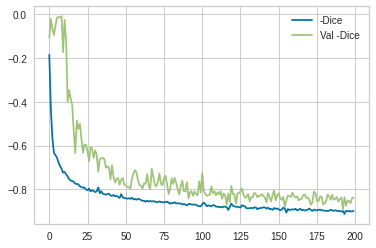

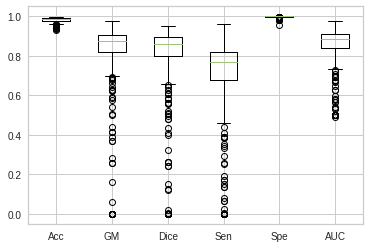

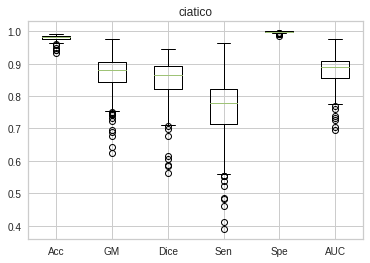

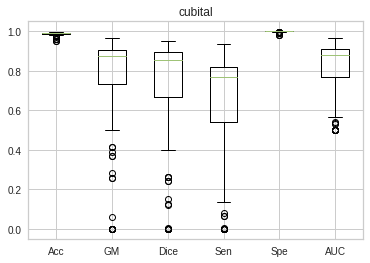

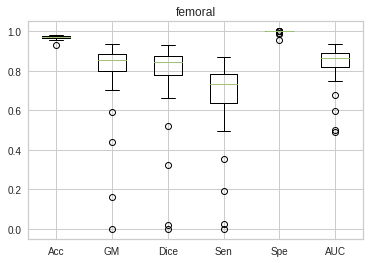

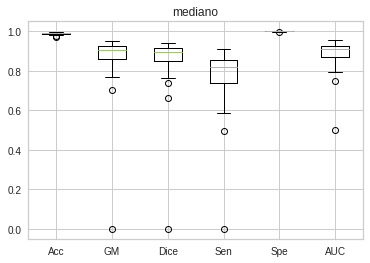

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
37/37 [==============================] - 15s 342ms/step - loss: -0.1918 - iou: 0.1065 - dice_coef: 0.1912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6638 - val_loss: -0.1071 - val_iou: 0.0566 - val_dice_coef: 0.1071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9374


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 2/200
37/37 [==============================] - 11s 309ms/step - loss: -0.3778 - iou: 0.2350 - dice_coef: 0.3772 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8889 - val_loss: -0.0334 - val_iou: 0.0170 - val_dice_coef: 0.0334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9381


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 3/200
37/37 [==============================] - 11s 304ms/step - loss: -0.5425 - iou: 0.3731 - dice_coef: 0.5403 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9392 - val_loss: -0.0374 - val_iou: 0.0191 - val_dice_coef: 0.0374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9378


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 4/200
37/37 [==============================] - 12s 338ms/step - loss: -0.6226 - iou: 0.4523 - dice_coef: 0.6214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9540 - val_loss: -0.0282 - val_iou: 0.0143 - val_dice_coef: 0.0282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9377


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 5/200
37/37 [==============================] - 12s 327ms/step - loss: -0.6612 - iou: 0.4928 - dice_coef: 0.6576 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9586 - val_loss: -0.1685 - val_iou: 0.0925 - val_dice_coef: 0.1685 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9407


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 6/200
37/37 [==============================] - 11s 307ms/step - loss: -0.6762 - iou: 0.5102 - dice_coef: 0.6744 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9594 - val_loss: -0.1265 - val_iou: 0.0679 - val_dice_coef: 0.1265 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9231


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 7/200
37/37 [==============================] - 11s 302ms/step - loss: -0.6961 - iou: 0.5364 - dice_coef: 0.6960 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9623 - val_loss: -0.1399 - val_iou: 0.0757 - val_dice_coef: 0.1399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9348


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 8/200
37/37 [==============================] - 12s 338ms/step - loss: -0.6981 - iou: 0.5312 - dice_coef: 0.6890 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9621 - val_loss: -0.1831 - val_iou: 0.1015 - val_dice_coef: 0.1831 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9397


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 9/200
37/37 [==============================] - 12s 339ms/step - loss: -0.7182 - iou: 0.5621 - dice_coef: 0.7169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9656 - val_loss: -0.2932 - val_iou: 0.1725 - val_dice_coef: 0.2932 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9368


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 10/200
37/37 [==============================] - 11s 310ms/step - loss: -0.7309 - iou: 0.5793 - dice_coef: 0.7316 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9666 - val_loss: -0.2462 - val_iou: 0.1412 - val_dice_coef: 0.2462 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9360


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 11/200
37/37 [==============================] - 11s 304ms/step - loss: -0.7297 - iou: 0.5769 - dice_coef: 0.7285 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9661 - val_loss: -0.3588 - val_iou: 0.2218 - val_dice_coef: 0.3588 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9476


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 12/200
37/37 [==============================] - 12s 332ms/step - loss: -0.7246 - iou: 0.5642 - dice_coef: 0.7163 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9664 - val_loss: -0.5204 - val_iou: 0.3551 - val_dice_coef: 0.5204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9545


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 13/200
37/37 [==============================] - 12s 336ms/step - loss: -0.7455 - iou: 0.5968 - dice_coef: 0.7447 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9680 - val_loss: -0.4818 - val_iou: 0.3227 - val_dice_coef: 0.4818 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9485


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 14/200
37/37 [==============================] - 12s 328ms/step - loss: -0.7459 - iou: 0.6001 - dice_coef: 0.7473 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9687 - val_loss: -0.5253 - val_iou: 0.3584 - val_dice_coef: 0.5253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9562


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 15/200
37/37 [==============================] - 12s 336ms/step - loss: -0.7641 - iou: 0.6232 - dice_coef: 0.7653 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9709 - val_loss: -0.6222 - val_iou: 0.4591 - val_dice_coef: 0.6222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9623


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 16/200
37/37 [==============================] - 11s 304ms/step - loss: -0.7636 - iou: 0.6253 - dice_coef: 0.7662 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9705 - val_loss: -0.5728 - val_iou: 0.4051 - val_dice_coef: 0.5728 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9565


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 17/200
37/37 [==============================] - 11s 304ms/step - loss: -0.7691 - iou: 0.6297 - dice_coef: 0.7701 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.6471 - val_iou: 0.4826 - val_dice_coef: 0.6471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9621


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 18/200
37/37 [==============================] - 12s 319ms/step - loss: -0.7713 - iou: 0.6312 - dice_coef: 0.7713 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9718 - val_loss: -0.6403 - val_iou: 0.4792 - val_dice_coef: 0.6403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9640


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 19/200
37/37 [==============================] - 12s 335ms/step - loss: -0.7762 - iou: 0.6398 - dice_coef: 0.7773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9729 - val_loss: -0.7035 - val_iou: 0.5495 - val_dice_coef: 0.7035 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 20/200
37/37 [==============================] - 11s 310ms/step - loss: -0.7830 - iou: 0.6476 - dice_coef: 0.7837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9726 - val_loss: -0.5795 - val_iou: 0.4188 - val_dice_coef: 0.5795 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9605


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 21/200
37/37 [==============================] - 11s 304ms/step - loss: -0.7812 - iou: 0.6459 - dice_coef: 0.7809 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9732 - val_loss: -0.6861 - val_iou: 0.5280 - val_dice_coef: 0.6861 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9649


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 22/200
37/37 [==============================] - 11s 316ms/step - loss: -0.7969 - iou: 0.6666 - dice_coef: 0.7983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -0.6938 - val_iou: 0.5332 - val_dice_coef: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9682


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 23/200
37/37 [==============================] - 12s 334ms/step - loss: -0.7907 - iou: 0.6616 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9745 - val_loss: -0.7117 - val_iou: 0.5636 - val_dice_coef: 0.7117 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 24/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8016 - iou: 0.6721 - dice_coef: 0.8015 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9751 - val_loss: -0.7180 - val_iou: 0.5722 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9692


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 25/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8048 - iou: 0.6780 - dice_coef: 0.8055 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9757 - val_loss: -0.7345 - val_iou: 0.5914 - val_dice_coef: 0.7345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9706


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 26/200
37/37 [==============================] - 11s 304ms/step - loss: -0.7986 - iou: 0.6682 - dice_coef: 0.7988 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.7026 - val_iou: 0.5552 - val_dice_coef: 0.7026 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9627


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 27/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8045 - iou: 0.6793 - dice_coef: 0.8059 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9757 - val_loss: -0.6693 - val_iou: 0.5167 - val_dice_coef: 0.6693 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9617


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 28/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8110 - iou: 0.6821 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -0.7316 - val_iou: 0.5863 - val_dice_coef: 0.7316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9673


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 29/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8012 - iou: 0.6745 - dice_coef: 0.8019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9751 - val_loss: -0.7029 - val_iou: 0.5493 - val_dice_coef: 0.7029 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9625


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 30/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8125 - iou: 0.6890 - dice_coef: 0.8126 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -0.7346 - val_iou: 0.5934 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 31/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8107 - iou: 0.6858 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -0.7642 - val_iou: 0.6248 - val_dice_coef: 0.7642 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9721


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 32/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8162 - iou: 0.6942 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9770 - val_loss: -0.8010 - val_iou: 0.6685 - val_dice_coef: 0.8010 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 33/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8352 - iou: 0.7169 - dice_coef: 0.8349 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9794 - val_loss: -0.7620 - val_iou: 0.6260 - val_dice_coef: 0.7620 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9713


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 34/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8201 - iou: 0.7033 - dice_coef: 0.8212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -0.7486 - val_iou: 0.6063 - val_dice_coef: 0.7486 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9726


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 35/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8239 - iou: 0.7071 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -0.7936 - val_iou: 0.6621 - val_dice_coef: 0.7936 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 36/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8231 - iou: 0.7053 - dice_coef: 0.8234 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -0.7746 - val_iou: 0.6416 - val_dice_coef: 0.7746 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9721


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 37/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8262 - iou: 0.7078 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.7827 - val_iou: 0.6526 - val_dice_coef: 0.7827 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 38/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8286 - iou: 0.7101 - dice_coef: 0.8286 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.7570 - val_iou: 0.6303 - val_dice_coef: 0.7570 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9724


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 39/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8289 - iou: 0.7139 - dice_coef: 0.8301 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.7640 - val_iou: 0.6339 - val_dice_coef: 0.7640 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 40/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8341 - iou: 0.7204 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9794 - val_loss: -0.7429 - val_iou: 0.6087 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9704


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 41/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8347 - iou: 0.7224 - dice_coef: 0.8357 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9794 - val_loss: -0.7659 - val_iou: 0.6373 - val_dice_coef: 0.7659 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 42/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8398 - iou: 0.7272 - dice_coef: 0.8406 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.7872 - val_iou: 0.6551 - val_dice_coef: 0.7872 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 43/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8346 - iou: 0.7228 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -0.7621 - val_iou: 0.6307 - val_dice_coef: 0.7621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9710


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 44/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8303 - iou: 0.7145 - dice_coef: 0.8287 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -0.7608 - val_iou: 0.6365 - val_dice_coef: 0.7608 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9713


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 45/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8283 - iou: 0.7126 - dice_coef: 0.8272 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.7333 - val_iou: 0.5963 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 46/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8339 - iou: 0.7216 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.7850 - val_iou: 0.6547 - val_dice_coef: 0.7850 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 47/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8403 - iou: 0.7291 - dice_coef: 0.8402 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.7883 - val_iou: 0.6576 - val_dice_coef: 0.7883 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 48/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8363 - iou: 0.7249 - dice_coef: 0.8362 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -0.7714 - val_iou: 0.6501 - val_dice_coef: 0.7714 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 49/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8393 - iou: 0.7287 - dice_coef: 0.8394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -0.8020 - val_iou: 0.6761 - val_dice_coef: 0.8020 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 50/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8470 - iou: 0.7407 - dice_coef: 0.8473 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.7803 - val_iou: 0.6545 - val_dice_coef: 0.7803 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 51/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8458 - iou: 0.7365 - dice_coef: 0.8449 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.7662 - val_iou: 0.6396 - val_dice_coef: 0.7662 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 52/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8477 - iou: 0.7406 - dice_coef: 0.8474 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -0.7692 - val_iou: 0.6385 - val_dice_coef: 0.7692 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 53/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8513 - iou: 0.7466 - dice_coef: 0.8524 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7864 - val_iou: 0.6563 - val_dice_coef: 0.7864 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 54/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8506 - iou: 0.7447 - dice_coef: 0.8495 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -0.7896 - val_iou: 0.6655 - val_dice_coef: 0.7896 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9742


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 55/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8500 - iou: 0.7450 - dice_coef: 0.8504 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.8081 - val_iou: 0.6833 - val_dice_coef: 0.8081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 56/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8537 - iou: 0.7484 - dice_coef: 0.8535 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7911 - val_iou: 0.6659 - val_dice_coef: 0.7911 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 57/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8532 - iou: 0.7487 - dice_coef: 0.8529 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.7895 - val_iou: 0.6626 - val_dice_coef: 0.7895 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 58/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8548 - iou: 0.7514 - dice_coef: 0.8550 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.7798 - val_iou: 0.6615 - val_dice_coef: 0.7798 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9735


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 59/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8493 - iou: 0.7438 - dice_coef: 0.8483 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -0.7855 - val_iou: 0.6646 - val_dice_coef: 0.7855 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 60/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8596 - iou: 0.7558 - dice_coef: 0.8590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7732 - val_iou: 0.6461 - val_dice_coef: 0.7732 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 61/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8543 - iou: 0.7544 - dice_coef: 0.8551 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.7828 - val_iou: 0.6615 - val_dice_coef: 0.7828 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 62/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8540 - iou: 0.7460 - dice_coef: 0.8488 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.7821 - val_iou: 0.6566 - val_dice_coef: 0.7821 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9730


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 63/200
37/37 [==============================] - 11s 304ms/step - loss: -0.8554 - iou: 0.7495 - dice_coef: 0.8541 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.7910 - val_iou: 0.6732 - val_dice_coef: 0.7910 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 64/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8481 - iou: 0.7456 - dice_coef: 0.8488 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.7785 - val_iou: 0.6542 - val_dice_coef: 0.7785 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 65/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8615 - iou: 0.7557 - dice_coef: 0.8590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.8043 - val_iou: 0.6831 - val_dice_coef: 0.8043 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 66/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8579 - iou: 0.7577 - dice_coef: 0.8589 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.7843 - val_iou: 0.6628 - val_dice_coef: 0.7843 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 67/200
37/37 [==============================] - 11s 305ms/step - loss: -0.8587 - iou: 0.7605 - dice_coef: 0.8595 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.8221 - val_iou: 0.7021 - val_dice_coef: 0.8221 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 68/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8604 - iou: 0.7612 - dice_coef: 0.8605 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7876 - val_iou: 0.6711 - val_dice_coef: 0.7876 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 69/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8618 - iou: 0.7634 - dice_coef: 0.8628 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.8081 - val_iou: 0.6851 - val_dice_coef: 0.8081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 70/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8615 - iou: 0.7615 - dice_coef: 0.8615 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.8504 - val_iou: 0.7402 - val_dice_coef: 0.8504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 71/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8773 - iou: 0.7810 - dice_coef: 0.8769 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7991 - val_iou: 0.6787 - val_dice_coef: 0.7991 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9743


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 72/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8666 - iou: 0.7704 - dice_coef: 0.8669 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.8244 - val_iou: 0.7075 - val_dice_coef: 0.8244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 73/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8688 - iou: 0.7725 - dice_coef: 0.8695 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8038 - val_iou: 0.6844 - val_dice_coef: 0.8038 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 74/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8620 - iou: 0.7616 - dice_coef: 0.8608 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.7927 - val_iou: 0.6685 - val_dice_coef: 0.7927 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 75/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8635 - iou: 0.7618 - dice_coef: 0.8601 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.7727 - val_iou: 0.6316 - val_dice_coef: 0.7727 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 76/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8658 - iou: 0.7691 - dice_coef: 0.8659 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.7899 - val_iou: 0.6714 - val_dice_coef: 0.7899 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 77/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8632 - iou: 0.7651 - dice_coef: 0.8620 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.8057 - val_iou: 0.6924 - val_dice_coef: 0.8057 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 78/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8676 - iou: 0.7706 - dice_coef: 0.8671 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.8084 - val_iou: 0.6931 - val_dice_coef: 0.8084 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 79/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8709 - iou: 0.7743 - dice_coef: 0.8704 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.8096 - val_iou: 0.6985 - val_dice_coef: 0.8096 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 80/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8691 - iou: 0.7743 - dice_coef: 0.8686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8122 - val_iou: 0.6988 - val_dice_coef: 0.8122 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 81/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8727 - iou: 0.7802 - dice_coef: 0.8735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.8244 - val_iou: 0.7134 - val_dice_coef: 0.8244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 82/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8728 - iou: 0.7783 - dice_coef: 0.8721 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8248 - val_iou: 0.7127 - val_dice_coef: 0.8248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 83/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8683 - iou: 0.7771 - dice_coef: 0.8690 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8067 - val_iou: 0.6932 - val_dice_coef: 0.8067 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 84/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8735 - iou: 0.7827 - dice_coef: 0.8741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8192 - val_iou: 0.7085 - val_dice_coef: 0.8192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 85/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8768 - iou: 0.7865 - dice_coef: 0.8771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8031 - val_iou: 0.6935 - val_dice_coef: 0.8031 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 86/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8763 - iou: 0.7837 - dice_coef: 0.8762 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8065 - val_iou: 0.6890 - val_dice_coef: 0.8065 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 87/200
37/37 [==============================] - 13s 347ms/step - loss: -0.8742 - iou: 0.7811 - dice_coef: 0.8742 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8089 - val_iou: 0.6895 - val_dice_coef: 0.8089 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 88/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8740 - iou: 0.7820 - dice_coef: 0.8742 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8022 - val_iou: 0.6904 - val_dice_coef: 0.8022 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 89/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8757 - iou: 0.7875 - dice_coef: 0.8769 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8136 - val_iou: 0.7033 - val_dice_coef: 0.8136 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 90/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8753 - iou: 0.7876 - dice_coef: 0.8760 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8251 - val_iou: 0.7198 - val_dice_coef: 0.8251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 91/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8769 - iou: 0.7857 - dice_coef: 0.8777 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8379 - val_iou: 0.7305 - val_dice_coef: 0.8379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 92/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8778 - iou: 0.7904 - dice_coef: 0.8782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8345 - val_iou: 0.7246 - val_dice_coef: 0.8345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 93/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8781 - iou: 0.7875 - dice_coef: 0.8775 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8129 - val_iou: 0.7003 - val_dice_coef: 0.8129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 94/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8793 - iou: 0.7894 - dice_coef: 0.8785 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8135 - val_iou: 0.7109 - val_dice_coef: 0.8135 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 95/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8748 - iou: 0.7863 - dice_coef: 0.8758 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8098 - val_iou: 0.7020 - val_dice_coef: 0.8098 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 96/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8773 - iou: 0.7863 - dice_coef: 0.8771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.7870 - val_iou: 0.6579 - val_dice_coef: 0.7870 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 97/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8800 - iou: 0.7917 - dice_coef: 0.8802 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8120 - val_iou: 0.7049 - val_dice_coef: 0.8120 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 98/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8815 - iou: 0.7942 - dice_coef: 0.8820 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8086 - val_iou: 0.7016 - val_dice_coef: 0.8086 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 99/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8808 - iou: 0.7932 - dice_coef: 0.8813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8254 - val_iou: 0.7156 - val_dice_coef: 0.8254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 100/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8824 - iou: 0.7963 - dice_coef: 0.8826 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8244 - val_iou: 0.7179 - val_dice_coef: 0.8244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 101/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8773 - iou: 0.7899 - dice_coef: 0.8771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8010 - val_iou: 0.6957 - val_dice_coef: 0.8010 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 102/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8768 - iou: 0.7790 - dice_coef: 0.8708 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.7550 - val_iou: 0.6202 - val_dice_coef: 0.7550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9709


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 103/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8616 - iou: 0.7633 - dice_coef: 0.8615 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.8076 - val_iou: 0.6958 - val_dice_coef: 0.8076 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 104/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8743 - iou: 0.7785 - dice_coef: 0.8732 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8103 - val_iou: 0.6971 - val_dice_coef: 0.8103 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 105/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8725 - iou: 0.7796 - dice_coef: 0.8733 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8236 - val_iou: 0.7166 - val_dice_coef: 0.8236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 106/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8772 - iou: 0.7882 - dice_coef: 0.8778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8162 - val_iou: 0.7101 - val_dice_coef: 0.8162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 107/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8781 - iou: 0.7888 - dice_coef: 0.8774 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8372 - val_iou: 0.7331 - val_dice_coef: 0.8372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 108/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8792 - iou: 0.7904 - dice_coef: 0.8792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8784 - val_iou: 0.7833 - val_dice_coef: 0.8784 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9851


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 109/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8968 - iou: 0.8139 - dice_coef: 0.8973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8215 - val_iou: 0.7176 - val_dice_coef: 0.8215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 110/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8827 - iou: 0.7995 - dice_coef: 0.8833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8387 - val_iou: 0.7333 - val_dice_coef: 0.8387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 111/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8840 - iou: 0.7944 - dice_coef: 0.8820 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8161 - val_iou: 0.7118 - val_dice_coef: 0.8161 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 112/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8875 - iou: 0.8000 - dice_coef: 0.8869 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8583 - val_iou: 0.7551 - val_dice_coef: 0.8583 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 113/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8845 - iou: 0.7993 - dice_coef: 0.8851 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8577 - val_iou: 0.7550 - val_dice_coef: 0.8577 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 114/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8854 - iou: 0.8011 - dice_coef: 0.8858 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8314 - val_iou: 0.7284 - val_dice_coef: 0.8314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 115/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8823 - iou: 0.7953 - dice_coef: 0.8823 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8348 - val_iou: 0.7360 - val_dice_coef: 0.8348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 116/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8818 - iou: 0.7903 - dice_coef: 0.8790 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8258 - val_iou: 0.7226 - val_dice_coef: 0.8258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 117/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8849 - iou: 0.7997 - dice_coef: 0.8849 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8276 - val_iou: 0.7243 - val_dice_coef: 0.8276 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 118/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8829 - iou: 0.7954 - dice_coef: 0.8826 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8201 - val_iou: 0.7093 - val_dice_coef: 0.8201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 119/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8842 - iou: 0.7995 - dice_coef: 0.8844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8306 - val_iou: 0.7267 - val_dice_coef: 0.8306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 120/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8824 - iou: 0.7981 - dice_coef: 0.8819 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8245 - val_iou: 0.7198 - val_dice_coef: 0.8245 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 121/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8861 - iou: 0.8014 - dice_coef: 0.8858 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8336 - val_iou: 0.7313 - val_dice_coef: 0.8336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 122/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8836 - iou: 0.7998 - dice_coef: 0.8833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8363 - val_iou: 0.7328 - val_dice_coef: 0.8363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 123/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8844 - iou: 0.7970 - dice_coef: 0.8819 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8648 - val_iou: 0.7640 - val_dice_coef: 0.8648 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 124/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8804 - iou: 0.7886 - dice_coef: 0.8782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8194 - val_iou: 0.7096 - val_dice_coef: 0.8194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 125/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8786 - iou: 0.7891 - dice_coef: 0.8789 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8526 - val_iou: 0.7485 - val_dice_coef: 0.8526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 126/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8889 - iou: 0.8068 - dice_coef: 0.8892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8571 - val_iou: 0.7572 - val_dice_coef: 0.8571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 127/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8837 - iou: 0.7976 - dice_coef: 0.8820 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8268 - val_iou: 0.7247 - val_dice_coef: 0.8268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 128/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8847 - iou: 0.8031 - dice_coef: 0.8854 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8222 - val_iou: 0.7208 - val_dice_coef: 0.8222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 129/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8886 - iou: 0.8086 - dice_coef: 0.8894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8197 - val_iou: 0.7170 - val_dice_coef: 0.8197 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 130/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8924 - iou: 0.8103 - dice_coef: 0.8912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8228 - val_iou: 0.7156 - val_dice_coef: 0.8228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 131/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8829 - iou: 0.7964 - dice_coef: 0.8822 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8123 - val_iou: 0.7135 - val_dice_coef: 0.8123 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 132/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8877 - iou: 0.8053 - dice_coef: 0.8873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8313 - val_iou: 0.7319 - val_dice_coef: 0.8313 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 133/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8877 - iou: 0.8060 - dice_coef: 0.8883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8296 - val_iou: 0.7284 - val_dice_coef: 0.8296 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 134/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8926 - iou: 0.8119 - dice_coef: 0.8923 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8391 - val_iou: 0.7324 - val_dice_coef: 0.8391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 135/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8889 - iou: 0.8085 - dice_coef: 0.8892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8478 - val_iou: 0.7453 - val_dice_coef: 0.8478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 136/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8922 - iou: 0.8110 - dice_coef: 0.8919 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8415 - val_iou: 0.7415 - val_dice_coef: 0.8415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 137/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8983 - iou: 0.8197 - dice_coef: 0.8982 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8612 - val_iou: 0.7603 - val_dice_coef: 0.8612 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 138/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8906 - iou: 0.8053 - dice_coef: 0.8878 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8389 - val_iou: 0.7364 - val_dice_coef: 0.8389 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 139/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8876 - iou: 0.8094 - dice_coef: 0.8883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8220 - val_iou: 0.7191 - val_dice_coef: 0.8220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 140/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8900 - iou: 0.8100 - dice_coef: 0.8901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8493 - val_iou: 0.7469 - val_dice_coef: 0.8493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 141/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8952 - iou: 0.8161 - dice_coef: 0.8952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8541 - val_iou: 0.7533 - val_dice_coef: 0.8541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 142/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8954 - iou: 0.8178 - dice_coef: 0.8959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8497 - val_iou: 0.7479 - val_dice_coef: 0.8497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 143/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8948 - iou: 0.8156 - dice_coef: 0.8952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8442 - val_iou: 0.7433 - val_dice_coef: 0.8442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 144/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8924 - iou: 0.8152 - dice_coef: 0.8929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8273 - val_iou: 0.7351 - val_dice_coef: 0.8273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 145/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8956 - iou: 0.8167 - dice_coef: 0.8951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8554 - val_iou: 0.7572 - val_dice_coef: 0.8554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 146/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8958 - iou: 0.8189 - dice_coef: 0.8958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8895 - val_iou: 0.8012 - val_dice_coef: 0.8895 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9864


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 147/200
37/37 [==============================] - 12s 329ms/step - loss: -0.9104 - iou: 0.8352 - dice_coef: 0.9101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.8356 - val_iou: 0.7422 - val_dice_coef: 0.8356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 148/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8919 - iou: 0.8145 - dice_coef: 0.8916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8457 - val_iou: 0.7492 - val_dice_coef: 0.8457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 149/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8956 - iou: 0.8180 - dice_coef: 0.8962 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8288 - val_iou: 0.7352 - val_dice_coef: 0.8288 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 150/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8867 - iou: 0.7991 - dice_coef: 0.8858 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8416 - val_iou: 0.7424 - val_dice_coef: 0.8416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 151/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8892 - iou: 0.8075 - dice_coef: 0.8894 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8528 - val_iou: 0.7500 - val_dice_coef: 0.8528 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 152/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8865 - iou: 0.8078 - dice_coef: 0.8870 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8347 - val_iou: 0.7401 - val_dice_coef: 0.8347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 153/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8932 - iou: 0.8132 - dice_coef: 0.8934 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8440 - val_iou: 0.7412 - val_dice_coef: 0.8440 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 154/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8914 - iou: 0.8108 - dice_coef: 0.8914 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8466 - val_iou: 0.7449 - val_dice_coef: 0.8466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 155/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8928 - iou: 0.8128 - dice_coef: 0.8926 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8382 - val_iou: 0.7374 - val_dice_coef: 0.8382 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 156/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8944 - iou: 0.8176 - dice_coef: 0.8951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8267 - val_iou: 0.7315 - val_dice_coef: 0.8267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 157/200
37/37 [==============================] - 11s 306ms/step - loss: -0.8967 - iou: 0.8217 - dice_coef: 0.8975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8226 - val_iou: 0.7305 - val_dice_coef: 0.8226 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 158/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8971 - iou: 0.8192 - dice_coef: 0.8969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8555 - val_iou: 0.7581 - val_dice_coef: 0.8555 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 159/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8979 - iou: 0.8225 - dice_coef: 0.8987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8432 - val_iou: 0.7455 - val_dice_coef: 0.8432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 160/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8987 - iou: 0.8188 - dice_coef: 0.8969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8248 - val_iou: 0.7336 - val_dice_coef: 0.8248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 161/200
37/37 [==============================] - 12s 337ms/step - loss: -0.9011 - iou: 0.8244 - dice_coef: 0.9014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8431 - val_iou: 0.7504 - val_dice_coef: 0.8431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 162/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8991 - iou: 0.8222 - dice_coef: 0.8984 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8603 - val_iou: 0.7663 - val_dice_coef: 0.8603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 163/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8979 - iou: 0.8212 - dice_coef: 0.8977 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8660 - val_iou: 0.7698 - val_dice_coef: 0.8660 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 164/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8956 - iou: 0.8224 - dice_coef: 0.8966 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8422 - val_iou: 0.7476 - val_dice_coef: 0.8422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 165/200
37/37 [==============================] - 12s 341ms/step - loss: -0.9039 - iou: 0.8286 - dice_coef: 0.9037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8457 - val_iou: 0.7525 - val_dice_coef: 0.8457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 166/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8975 - iou: 0.8173 - dice_coef: 0.8956 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8330 - val_iou: 0.7332 - val_dice_coef: 0.8330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 167/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8977 - iou: 0.8210 - dice_coef: 0.8982 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8361 - val_iou: 0.7381 - val_dice_coef: 0.8361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 168/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8899 - iou: 0.8040 - dice_coef: 0.8838 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8225 - val_iou: 0.7188 - val_dice_coef: 0.8225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 169/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8908 - iou: 0.8117 - dice_coef: 0.8899 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8274 - val_iou: 0.7249 - val_dice_coef: 0.8274 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 170/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8940 - iou: 0.8134 - dice_coef: 0.8936 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8206 - val_iou: 0.7240 - val_dice_coef: 0.8206 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 171/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8962 - iou: 0.8197 - dice_coef: 0.8966 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8481 - val_iou: 0.7474 - val_dice_coef: 0.8481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 172/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8974 - iou: 0.8235 - dice_coef: 0.8983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8609 - val_iou: 0.7625 - val_dice_coef: 0.8609 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 173/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8981 - iou: 0.8209 - dice_coef: 0.8974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8460 - val_iou: 0.7485 - val_dice_coef: 0.8460 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 174/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8987 - iou: 0.8223 - dice_coef: 0.8989 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8489 - val_iou: 0.7551 - val_dice_coef: 0.8489 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 175/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8997 - iou: 0.8246 - dice_coef: 0.8997 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8370 - val_iou: 0.7400 - val_dice_coef: 0.8370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 176/200
37/37 [==============================] - 11s 310ms/step - loss: -0.9026 - iou: 0.8289 - dice_coef: 0.9033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8471 - val_iou: 0.7520 - val_dice_coef: 0.8471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 177/200
37/37 [==============================] - 12s 336ms/step - loss: -0.9028 - iou: 0.8297 - dice_coef: 0.9029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8388 - val_iou: 0.7466 - val_dice_coef: 0.8388 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 178/200
37/37 [==============================] - 12s 323ms/step - loss: -0.9009 - iou: 0.8260 - dice_coef: 0.9011 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8571 - val_iou: 0.7627 - val_dice_coef: 0.8571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 179/200
37/37 [==============================] - 12s 342ms/step - loss: -0.8978 - iou: 0.8258 - dice_coef: 0.8985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8594 - val_iou: 0.7668 - val_dice_coef: 0.8594 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 180/200
37/37 [==============================] - 12s 321ms/step - loss: -0.9054 - iou: 0.8333 - dice_coef: 0.9056 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8356 - val_iou: 0.7442 - val_dice_coef: 0.8356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 181/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8980 - iou: 0.8229 - dice_coef: 0.8981 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8327 - val_iou: 0.7369 - val_dice_coef: 0.8327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 182/200
37/37 [==============================] - 11s 308ms/step - loss: -0.9026 - iou: 0.8310 - dice_coef: 0.9033 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8521 - val_iou: 0.7582 - val_dice_coef: 0.8521 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 183/200
37/37 [==============================] - 12s 338ms/step - loss: -0.9048 - iou: 0.8327 - dice_coef: 0.9053 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8282 - val_iou: 0.7394 - val_dice_coef: 0.8282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 184/200
37/37 [==============================] - 12s 333ms/step - loss: -0.9006 - iou: 0.8275 - dice_coef: 0.9006 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8397 - val_iou: 0.7492 - val_dice_coef: 0.8397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 185/200
37/37 [==============================] - 12s 321ms/step - loss: -0.9160 - iou: 0.8334 - dice_coef: 0.9057 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.8443 - val_iou: 0.7527 - val_dice_coef: 0.8443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 186/200
37/37 [==============================] - 11s 311ms/step - loss: -0.9030 - iou: 0.8263 - dice_coef: 0.9014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8766 - val_iou: 0.7839 - val_dice_coef: 0.8766 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 187/200
37/37 [==============================] - 12s 340ms/step - loss: -0.9059 - iou: 0.8321 - dice_coef: 0.9052 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8569 - val_iou: 0.7629 - val_dice_coef: 0.8569 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 188/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9021 - iou: 0.8254 - dice_coef: 0.9007 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8369 - val_iou: 0.7436 - val_dice_coef: 0.8369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 189/200
37/37 [==============================] - 11s 309ms/step - loss: -0.9046 - iou: 0.8333 - dice_coef: 0.9055 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.8672 - val_iou: 0.7735 - val_dice_coef: 0.8672 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 190/200
37/37 [==============================] - 11s 307ms/step - loss: -0.9047 - iou: 0.8328 - dice_coef: 0.9050 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8641 - val_iou: 0.7713 - val_dice_coef: 0.8641 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 191/200
37/37 [==============================] - 12s 338ms/step - loss: -0.9027 - iou: 0.8303 - dice_coef: 0.9029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8408 - val_iou: 0.7503 - val_dice_coef: 0.8408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 192/200
37/37 [==============================] - 12s 342ms/step - loss: -0.9035 - iou: 0.8295 - dice_coef: 0.9018 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8421 - val_iou: 0.7460 - val_dice_coef: 0.8421 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 193/200
37/37 [==============================] - 11s 310ms/step - loss: -0.9074 - iou: 0.8367 - dice_coef: 0.9078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8504 - val_iou: 0.7538 - val_dice_coef: 0.8504 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 194/200
37/37 [==============================] - 11s 305ms/step - loss: -0.9065 - iou: 0.8345 - dice_coef: 0.9061 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8536 - val_iou: 0.7609 - val_dice_coef: 0.8536 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 195/200
37/37 [==============================] - 12s 335ms/step - loss: -0.9059 - iou: 0.8352 - dice_coef: 0.9061 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.8570 - val_iou: 0.7650 - val_dice_coef: 0.8570 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 196/200
37/37 [==============================] - 12s 344ms/step - loss: -0.9020 - iou: 0.8312 - dice_coef: 0.9018 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8567 - val_iou: 0.7641 - val_dice_coef: 0.8567 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 197/200
37/37 [==============================] - 12s 333ms/step - loss: -0.9063 - iou: 0.8333 - dice_coef: 0.9062 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8340 - val_iou: 0.7439 - val_dice_coef: 0.8340 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 198/200
37/37 [==============================] - 12s 341ms/step - loss: -0.9001 - iou: 0.8287 - dice_coef: 0.9005 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8501 - val_iou: 0.7565 - val_dice_coef: 0.8501 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 199/200
37/37 [==============================] - 11s 312ms/step - loss: -0.9035 - iou: 0.8323 - dice_coef: 0.9040 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8434 - val_iou: 0.7499 - val_dice_coef: 0.8434 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


Epoch 200/200
37/37 [==============================] - 11s 311ms/step - loss: -0.9051 - iou: 0.8336 - dice_coef: 0.9056 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8299 - val_iou: 0.7389 - val_dice_coef: 0.8299 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-32/Model_Checkpoint/assets


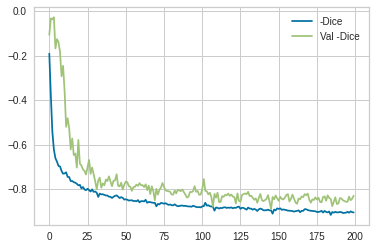

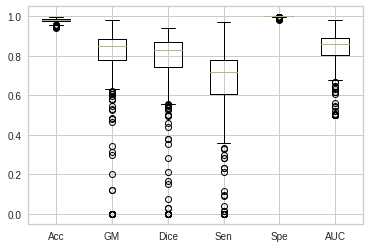

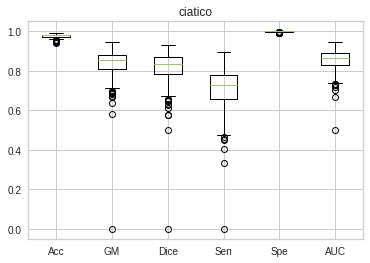

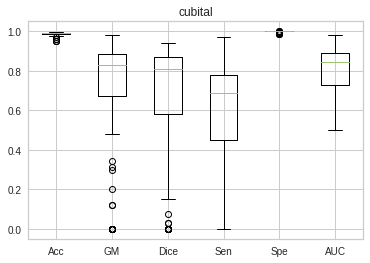

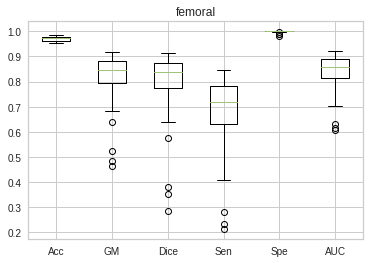

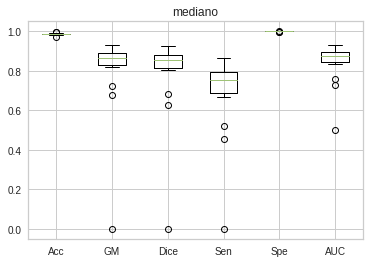

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
37/37 [==============================] - 15s 352ms/step - loss: -0.2000 - iou: 0.1123 - dice_coef: 0.1999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6863 - val_loss: -0.1024 - val_iou: 0.0540 - val_dice_coef: 0.1024 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9369


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 2/200
37/37 [==============================] - 11s 313ms/step - loss: -0.4591 - iou: 0.3015 - dice_coef: 0.4590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9171 - val_loss: -0.1263 - val_iou: 0.0674 - val_dice_coef: 0.1263 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9381


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 3/200
37/37 [==============================] - 11s 307ms/step - loss: -0.5983 - iou: 0.4274 - dice_coef: 0.5965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9478 - val_loss: -0.0385 - val_iou: 0.0197 - val_dice_coef: 0.0385 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9378


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 4/200
37/37 [==============================] - 12s 320ms/step - loss: -0.6465 - iou: 0.4811 - dice_coef: 0.6470 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9553 - val_loss: -0.0743 - val_iou: 0.0386 - val_dice_coef: 0.0743 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9389


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 5/200
37/37 [==============================] - 12s 340ms/step - loss: -0.6814 - iou: 0.5163 - dice_coef: 0.6791 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9608 - val_loss: -0.2580 - val_iou: 0.1491 - val_dice_coef: 0.2580 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9379


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 6/200
37/37 [==============================] - 11s 313ms/step - loss: -0.6978 - iou: 0.5394 - dice_coef: 0.6985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9617 - val_loss: -0.2898 - val_iou: 0.1697 - val_dice_coef: 0.2898 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9304


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 7/200
37/37 [==============================] - 11s 308ms/step - loss: -0.7082 - iou: 0.5511 - dice_coef: 0.7082 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9640 - val_loss: -0.3879 - val_iou: 0.2420 - val_dice_coef: 0.3879 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9448


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 8/200
37/37 [==============================] - 11s 315ms/step - loss: -0.7308 - iou: 0.5795 - dice_coef: 0.7313 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9673 - val_loss: -0.3248 - val_iou: 0.1965 - val_dice_coef: 0.3248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9473


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 9/200
37/37 [==============================] - 12s 337ms/step - loss: -0.7315 - iou: 0.5755 - dice_coef: 0.7276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9663 - val_loss: -0.3838 - val_iou: 0.2408 - val_dice_coef: 0.3838 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9468


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 10/200
37/37 [==============================] - 11s 316ms/step - loss: -0.7428 - iou: 0.5982 - dice_coef: 0.7445 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9678 - val_loss: -0.3919 - val_iou: 0.2441 - val_dice_coef: 0.3919 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9402


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 11/200
37/37 [==============================] - 11s 317ms/step - loss: -0.7515 - iou: 0.6043 - dice_coef: 0.7509 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9698 - val_loss: -0.6478 - val_iou: 0.4828 - val_dice_coef: 0.6478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9619


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 12/200
37/37 [==============================] - 12s 323ms/step - loss: -0.7680 - iou: 0.6261 - dice_coef: 0.7680 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.5526 - val_iou: 0.3862 - val_dice_coef: 0.5526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9585


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 13/200
37/37 [==============================] - 12s 340ms/step - loss: -0.7747 - iou: 0.6366 - dice_coef: 0.7761 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9719 - val_loss: -0.6010 - val_iou: 0.4310 - val_dice_coef: 0.6010 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9605


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 14/200
37/37 [==============================] - 12s 324ms/step - loss: -0.7787 - iou: 0.6432 - dice_coef: 0.7797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9724 - val_loss: -0.6786 - val_iou: 0.5228 - val_dice_coef: 0.6786 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9635


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 15/200
37/37 [==============================] - 12s 339ms/step - loss: -0.7765 - iou: 0.6393 - dice_coef: 0.7772 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9720 - val_loss: -0.7081 - val_iou: 0.5523 - val_dice_coef: 0.7081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 16/200
37/37 [==============================] - 12s 328ms/step - loss: -0.7906 - iou: 0.6561 - dice_coef: 0.7901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9742 - val_loss: -0.7096 - val_iou: 0.5551 - val_dice_coef: 0.7096 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9674


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 17/200
37/37 [==============================] - 12s 322ms/step - loss: -0.7870 - iou: 0.6523 - dice_coef: 0.7866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9735 - val_loss: -0.7096 - val_iou: 0.5558 - val_dice_coef: 0.7096 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9686


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 18/200
37/37 [==============================] - 11s 307ms/step - loss: -0.7941 - iou: 0.6626 - dice_coef: 0.7952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -0.7289 - val_iou: 0.5818 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9683


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 19/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8002 - iou: 0.6737 - dice_coef: 0.8014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.7228 - val_iou: 0.5846 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9676


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 20/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8033 - iou: 0.6769 - dice_coef: 0.8045 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9752 - val_loss: -0.7415 - val_iou: 0.5999 - val_dice_coef: 0.7415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9696


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 21/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8072 - iou: 0.6824 - dice_coef: 0.8085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -0.7575 - val_iou: 0.6183 - val_dice_coef: 0.7575 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 22/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8175 - iou: 0.6948 - dice_coef: 0.8185 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -0.7384 - val_iou: 0.5915 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9719


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 23/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8129 - iou: 0.6902 - dice_coef: 0.8129 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9768 - val_loss: -0.7429 - val_iou: 0.5919 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 24/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8285 - iou: 0.7070 - dice_coef: 0.8282 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.7315 - val_iou: 0.5910 - val_dice_coef: 0.7315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9688


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 25/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8145 - iou: 0.6900 - dice_coef: 0.8140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9768 - val_loss: -0.7088 - val_iou: 0.5638 - val_dice_coef: 0.7088 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 26/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8139 - iou: 0.6939 - dice_coef: 0.8137 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -0.7343 - val_iou: 0.5927 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9693


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 27/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8210 - iou: 0.7001 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.7584 - val_iou: 0.6260 - val_dice_coef: 0.7584 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 28/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8228 - iou: 0.7021 - dice_coef: 0.8222 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -0.7475 - val_iou: 0.6158 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9710


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 29/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8181 - iou: 0.6934 - dice_coef: 0.8158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.7477 - val_iou: 0.6067 - val_dice_coef: 0.7477 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9720


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 30/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8277 - iou: 0.7083 - dice_coef: 0.8258 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.7730 - val_iou: 0.6347 - val_dice_coef: 0.7730 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 31/200
37/37 [==============================] - 13s 347ms/step - loss: -0.8171 - iou: 0.6922 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.7820 - val_iou: 0.6480 - val_dice_coef: 0.7820 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9732


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 32/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8253 - iou: 0.7081 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -0.7505 - val_iou: 0.6201 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 33/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8304 - iou: 0.7163 - dice_coef: 0.8318 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.7594 - val_iou: 0.6281 - val_dice_coef: 0.7594 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 34/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8281 - iou: 0.7099 - dice_coef: 0.8267 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.7826 - val_iou: 0.6570 - val_dice_coef: 0.7826 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 35/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8323 - iou: 0.7199 - dice_coef: 0.8332 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -0.7937 - val_iou: 0.6677 - val_dice_coef: 0.7937 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 36/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8196 - iou: 0.6984 - dice_coef: 0.8189 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9768 - val_loss: -0.7624 - val_iou: 0.6199 - val_dice_coef: 0.7624 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 37/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8310 - iou: 0.7171 - dice_coef: 0.8322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -0.7266 - val_iou: 0.5863 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9710


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 38/200
37/37 [==============================] - 12s 342ms/step - loss: -0.8393 - iou: 0.7285 - dice_coef: 0.8403 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9797 - val_loss: -0.7496 - val_iou: 0.6097 - val_dice_coef: 0.7496 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 39/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8415 - iou: 0.7278 - dice_coef: 0.8396 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.7775 - val_iou: 0.6466 - val_dice_coef: 0.7775 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9736


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 40/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8428 - iou: 0.7324 - dice_coef: 0.8420 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.7680 - val_iou: 0.6295 - val_dice_coef: 0.7680 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9728


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 41/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8401 - iou: 0.7309 - dice_coef: 0.8405 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.7755 - val_iou: 0.6484 - val_dice_coef: 0.7755 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9735


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 42/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8481 - iou: 0.7401 - dice_coef: 0.8485 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.7940 - val_iou: 0.6748 - val_dice_coef: 0.7940 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 43/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8502 - iou: 0.7457 - dice_coef: 0.8508 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -0.7974 - val_iou: 0.6740 - val_dice_coef: 0.7974 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 44/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8499 - iou: 0.7389 - dice_coef: 0.8465 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.7671 - val_iou: 0.6478 - val_dice_coef: 0.7671 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 45/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8473 - iou: 0.7422 - dice_coef: 0.8482 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.7718 - val_iou: 0.6404 - val_dice_coef: 0.7718 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9743


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 46/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8459 - iou: 0.7399 - dice_coef: 0.8457 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -0.7950 - val_iou: 0.6715 - val_dice_coef: 0.7950 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 47/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8513 - iou: 0.7469 - dice_coef: 0.8518 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7867 - val_iou: 0.6624 - val_dice_coef: 0.7867 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 48/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8527 - iou: 0.7482 - dice_coef: 0.8528 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.7890 - val_iou: 0.6640 - val_dice_coef: 0.7890 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 49/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8520 - iou: 0.7480 - dice_coef: 0.8526 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.7755 - val_iou: 0.6613 - val_dice_coef: 0.7755 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 50/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8583 - iou: 0.7567 - dice_coef: 0.8578 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.8056 - val_iou: 0.6854 - val_dice_coef: 0.8056 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 51/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8617 - iou: 0.7617 - dice_coef: 0.8624 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.7978 - val_iou: 0.6834 - val_dice_coef: 0.7978 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 52/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8586 - iou: 0.7562 - dice_coef: 0.8581 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7999 - val_iou: 0.6808 - val_dice_coef: 0.7999 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 53/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8565 - iou: 0.7562 - dice_coef: 0.8572 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.8132 - val_iou: 0.6962 - val_dice_coef: 0.8132 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 54/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8592 - iou: 0.7555 - dice_coef: 0.8579 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.7889 - val_iou: 0.6670 - val_dice_coef: 0.7889 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9756


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 55/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8518 - iou: 0.7486 - dice_coef: 0.8529 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7738 - val_iou: 0.6528 - val_dice_coef: 0.7738 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9736


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 56/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8600 - iou: 0.7588 - dice_coef: 0.8593 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.8131 - val_iou: 0.6986 - val_dice_coef: 0.8131 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 57/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8630 - iou: 0.7651 - dice_coef: 0.8643 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.7846 - val_iou: 0.6627 - val_dice_coef: 0.7846 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 58/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8611 - iou: 0.7600 - dice_coef: 0.8605 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.8157 - val_iou: 0.6946 - val_dice_coef: 0.8157 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 59/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8583 - iou: 0.7604 - dice_coef: 0.8597 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.8123 - val_iou: 0.6957 - val_dice_coef: 0.8123 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 60/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8662 - iou: 0.7685 - dice_coef: 0.8661 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.8081 - val_iou: 0.6980 - val_dice_coef: 0.8081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 61/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8600 - iou: 0.7623 - dice_coef: 0.8600 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.8583 - val_iou: 0.7520 - val_dice_coef: 0.8583 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 62/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8788 - iou: 0.7823 - dice_coef: 0.8777 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7945 - val_iou: 0.6772 - val_dice_coef: 0.7945 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 63/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8630 - iou: 0.7647 - dice_coef: 0.8628 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.8084 - val_iou: 0.6927 - val_dice_coef: 0.8084 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 64/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8686 - iou: 0.7729 - dice_coef: 0.8687 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8005 - val_iou: 0.6883 - val_dice_coef: 0.8005 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 65/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8692 - iou: 0.7717 - dice_coef: 0.8684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.7926 - val_iou: 0.6826 - val_dice_coef: 0.7926 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 66/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8683 - iou: 0.7715 - dice_coef: 0.8684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.7977 - val_iou: 0.6827 - val_dice_coef: 0.7977 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 67/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8722 - iou: 0.7795 - dice_coef: 0.8731 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.7949 - val_iou: 0.6743 - val_dice_coef: 0.7949 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 68/200
37/37 [==============================] - 12s 342ms/step - loss: -0.8700 - iou: 0.7767 - dice_coef: 0.8701 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8089 - val_iou: 0.6978 - val_dice_coef: 0.8089 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 69/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8700 - iou: 0.7788 - dice_coef: 0.8709 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8185 - val_iou: 0.7082 - val_dice_coef: 0.8185 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 70/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8697 - iou: 0.7765 - dice_coef: 0.8703 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8195 - val_iou: 0.7104 - val_dice_coef: 0.8195 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 71/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8664 - iou: 0.7712 - dice_coef: 0.8658 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.7976 - val_iou: 0.6798 - val_dice_coef: 0.7976 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 72/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8695 - iou: 0.7735 - dice_coef: 0.8691 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8181 - val_iou: 0.7033 - val_dice_coef: 0.8181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 73/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8722 - iou: 0.7791 - dice_coef: 0.8725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8096 - val_iou: 0.6958 - val_dice_coef: 0.8096 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 74/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8731 - iou: 0.7784 - dice_coef: 0.8720 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8316 - val_iou: 0.7190 - val_dice_coef: 0.8316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 75/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8673 - iou: 0.7724 - dice_coef: 0.8668 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.7886 - val_iou: 0.6672 - val_dice_coef: 0.7886 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 76/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8679 - iou: 0.7732 - dice_coef: 0.8678 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8085 - val_iou: 0.6998 - val_dice_coef: 0.8085 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 77/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8703 - iou: 0.7781 - dice_coef: 0.8707 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.7851 - val_iou: 0.6678 - val_dice_coef: 0.7851 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 78/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8773 - iou: 0.7844 - dice_coef: 0.8768 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8277 - val_iou: 0.7147 - val_dice_coef: 0.8277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 79/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8747 - iou: 0.7842 - dice_coef: 0.8757 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8045 - val_iou: 0.6958 - val_dice_coef: 0.8045 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 80/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8740 - iou: 0.7844 - dice_coef: 0.8737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8110 - val_iou: 0.7073 - val_dice_coef: 0.8110 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 81/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8741 - iou: 0.7826 - dice_coef: 0.8737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8127 - val_iou: 0.7034 - val_dice_coef: 0.8127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 82/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8794 - iou: 0.7919 - dice_coef: 0.8805 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.8299 - val_iou: 0.7205 - val_dice_coef: 0.8299 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 83/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8756 - iou: 0.7876 - dice_coef: 0.8759 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8092 - val_iou: 0.7021 - val_dice_coef: 0.8092 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 84/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8784 - iou: 0.7918 - dice_coef: 0.8791 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8048 - val_iou: 0.6964 - val_dice_coef: 0.8048 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 85/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8815 - iou: 0.7922 - dice_coef: 0.8809 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7892 - val_iou: 0.6824 - val_dice_coef: 0.7892 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 86/200
37/37 [==============================] - 12s 337ms/step - loss: -0.8758 - iou: 0.7865 - dice_coef: 0.8753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8046 - val_iou: 0.6945 - val_dice_coef: 0.8046 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 87/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8864 - iou: 0.7996 - dice_coef: 0.8866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8165 - val_iou: 0.7066 - val_dice_coef: 0.8165 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 88/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8782 - iou: 0.7857 - dice_coef: 0.8743 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8058 - val_iou: 0.6955 - val_dice_coef: 0.8058 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 89/200
37/37 [==============================] - 11s 307ms/step - loss: -0.8833 - iou: 0.7947 - dice_coef: 0.8828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8023 - val_iou: 0.6830 - val_dice_coef: 0.8023 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 90/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8803 - iou: 0.7920 - dice_coef: 0.8797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8392 - val_iou: 0.7268 - val_dice_coef: 0.8392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 91/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8785 - iou: 0.7940 - dice_coef: 0.8798 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8270 - val_iou: 0.7205 - val_dice_coef: 0.8270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 92/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8824 - iou: 0.7948 - dice_coef: 0.8819 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8276 - val_iou: 0.7228 - val_dice_coef: 0.8276 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 93/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8805 - iou: 0.7935 - dice_coef: 0.8796 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8297 - val_iou: 0.7178 - val_dice_coef: 0.8297 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 94/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8856 - iou: 0.7977 - dice_coef: 0.8845 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8257 - val_iou: 0.7145 - val_dice_coef: 0.8257 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 95/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8824 - iou: 0.7945 - dice_coef: 0.8822 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8237 - val_iou: 0.7195 - val_dice_coef: 0.8237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 96/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8808 - iou: 0.7931 - dice_coef: 0.8792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8298 - val_iou: 0.7223 - val_dice_coef: 0.8298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 97/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8818 - iou: 0.7923 - dice_coef: 0.8811 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8129 - val_iou: 0.7020 - val_dice_coef: 0.8129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 98/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8838 - iou: 0.7968 - dice_coef: 0.8840 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8440 - val_iou: 0.7366 - val_dice_coef: 0.8440 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 99/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8810 - iou: 0.7958 - dice_coef: 0.8810 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8194 - val_iou: 0.7148 - val_dice_coef: 0.8194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 100/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8957 - iou: 0.8009 - dice_coef: 0.8868 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8233 - val_iou: 0.7208 - val_dice_coef: 0.8233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 101/200
37/37 [==============================] - 12s 342ms/step - loss: -0.8830 - iou: 0.7978 - dice_coef: 0.8832 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8170 - val_iou: 0.7126 - val_dice_coef: 0.8170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 102/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8838 - iou: 0.8018 - dice_coef: 0.8840 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8308 - val_iou: 0.7274 - val_dice_coef: 0.8308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 103/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8802 - iou: 0.7936 - dice_coef: 0.8791 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8115 - val_iou: 0.7070 - val_dice_coef: 0.8115 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 104/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8851 - iou: 0.8012 - dice_coef: 0.8859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8521 - val_iou: 0.7477 - val_dice_coef: 0.8521 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 105/200
37/37 [==============================] - 12s 346ms/step - loss: -0.8865 - iou: 0.8005 - dice_coef: 0.8857 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8124 - val_iou: 0.7095 - val_dice_coef: 0.8124 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 106/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8822 - iou: 0.7967 - dice_coef: 0.8815 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8311 - val_iou: 0.7268 - val_dice_coef: 0.8311 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 107/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8827 - iou: 0.7931 - dice_coef: 0.8808 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8190 - val_iou: 0.7127 - val_dice_coef: 0.8190 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 108/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8887 - iou: 0.8037 - dice_coef: 0.8880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8412 - val_iou: 0.7367 - val_dice_coef: 0.8412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 109/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8837 - iou: 0.8003 - dice_coef: 0.8843 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8196 - val_iou: 0.7175 - val_dice_coef: 0.8196 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 110/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8792 - iou: 0.7885 - dice_coef: 0.8788 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8106 - val_iou: 0.6990 - val_dice_coef: 0.8106 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 111/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8811 - iou: 0.7930 - dice_coef: 0.8813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8279 - val_iou: 0.7256 - val_dice_coef: 0.8279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 112/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8864 - iou: 0.8025 - dice_coef: 0.8860 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8001 - val_iou: 0.7011 - val_dice_coef: 0.8001 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 113/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8880 - iou: 0.8007 - dice_coef: 0.8870 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8485 - val_iou: 0.7449 - val_dice_coef: 0.8485 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 114/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8834 - iou: 0.7940 - dice_coef: 0.8804 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7958 - val_iou: 0.6783 - val_dice_coef: 0.7958 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9756


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 115/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8890 - iou: 0.8052 - dice_coef: 0.8891 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8291 - val_iou: 0.7255 - val_dice_coef: 0.8291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 116/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8895 - iou: 0.8075 - dice_coef: 0.8900 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8256 - val_iou: 0.7212 - val_dice_coef: 0.8256 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 117/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8943 - iou: 0.8145 - dice_coef: 0.8947 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8292 - val_iou: 0.7342 - val_dice_coef: 0.8292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 118/200
37/37 [==============================] - 11s 309ms/step - loss: -0.8977 - iou: 0.8198 - dice_coef: 0.8986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8392 - val_iou: 0.7400 - val_dice_coef: 0.8392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 119/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8921 - iou: 0.8121 - dice_coef: 0.8920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8413 - val_iou: 0.7388 - val_dice_coef: 0.8413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 120/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8958 - iou: 0.8167 - dice_coef: 0.8963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8142 - val_iou: 0.7186 - val_dice_coef: 0.8142 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 121/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8860 - iou: 0.8058 - dice_coef: 0.8862 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8288 - val_iou: 0.7302 - val_dice_coef: 0.8288 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 122/200
37/37 [==============================] - 11s 308ms/step - loss: -0.8968 - iou: 0.8205 - dice_coef: 0.8978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8514 - val_iou: 0.7568 - val_dice_coef: 0.8514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 123/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8960 - iou: 0.8184 - dice_coef: 0.8965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8329 - val_iou: 0.7354 - val_dice_coef: 0.8329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 124/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8981 - iou: 0.8207 - dice_coef: 0.8986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8333 - val_iou: 0.7339 - val_dice_coef: 0.8333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 125/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8918 - iou: 0.8084 - dice_coef: 0.8898 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8254 - val_iou: 0.7206 - val_dice_coef: 0.8254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 126/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8907 - iou: 0.8105 - dice_coef: 0.8906 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8287 - val_iou: 0.7289 - val_dice_coef: 0.8287 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 127/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8910 - iou: 0.8107 - dice_coef: 0.8913 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8252 - val_iou: 0.7253 - val_dice_coef: 0.8252 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 128/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8939 - iou: 0.8100 - dice_coef: 0.8915 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8445 - val_iou: 0.7463 - val_dice_coef: 0.8445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 129/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8930 - iou: 0.8124 - dice_coef: 0.8909 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8153 - val_iou: 0.7089 - val_dice_coef: 0.8153 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 130/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8916 - iou: 0.8106 - dice_coef: 0.8913 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8370 - val_iou: 0.7406 - val_dice_coef: 0.8370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 131/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8963 - iou: 0.8182 - dice_coef: 0.8963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8401 - val_iou: 0.7401 - val_dice_coef: 0.8401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 132/200
37/37 [==============================] - 12s 341ms/step - loss: -0.8987 - iou: 0.8201 - dice_coef: 0.8987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8410 - val_iou: 0.7442 - val_dice_coef: 0.8410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 133/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8973 - iou: 0.8213 - dice_coef: 0.8978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8647 - val_iou: 0.7663 - val_dice_coef: 0.8647 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 134/200
37/37 [==============================] - 11s 310ms/step - loss: -0.8978 - iou: 0.8192 - dice_coef: 0.8976 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8339 - val_iou: 0.7394 - val_dice_coef: 0.8339 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 135/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8958 - iou: 0.8164 - dice_coef: 0.8948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8345 - val_iou: 0.7404 - val_dice_coef: 0.8345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 136/200
37/37 [==============================] - 12s 336ms/step - loss: -0.8937 - iou: 0.8155 - dice_coef: 0.8942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8300 - val_iou: 0.7354 - val_dice_coef: 0.8300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 137/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8972 - iou: 0.8189 - dice_coef: 0.8972 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8917 - val_iou: 0.8049 - val_dice_coef: 0.8917 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9867


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 138/200
37/37 [==============================] - 12s 345ms/step - loss: -0.9101 - iou: 0.8358 - dice_coef: 0.9105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.8354 - val_iou: 0.7366 - val_dice_coef: 0.8354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 139/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8960 - iou: 0.8207 - dice_coef: 0.8964 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8558 - val_iou: 0.7595 - val_dice_coef: 0.8558 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 140/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8972 - iou: 0.8214 - dice_coef: 0.8977 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8494 - val_iou: 0.7526 - val_dice_coef: 0.8494 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 141/200
37/37 [==============================] - 12s 338ms/step - loss: -0.8981 - iou: 0.8216 - dice_coef: 0.8983 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8431 - val_iou: 0.7478 - val_dice_coef: 0.8431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 142/200
37/37 [==============================] - 12s 346ms/step - loss: -0.9003 - iou: 0.8227 - dice_coef: 0.8996 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8713 - val_iou: 0.7784 - val_dice_coef: 0.8713 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 143/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8943 - iou: 0.8139 - dice_coef: 0.8926 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8635 - val_iou: 0.7676 - val_dice_coef: 0.8635 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 144/200
37/37 [==============================] - 11s 311ms/step - loss: -0.9016 - iou: 0.8265 - dice_coef: 0.9018 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8378 - val_iou: 0.7466 - val_dice_coef: 0.8378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 145/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8997 - iou: 0.8216 - dice_coef: 0.8990 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8537 - val_iou: 0.7588 - val_dice_coef: 0.8537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 146/200
37/37 [==============================] - 12s 345ms/step - loss: -0.9046 - iou: 0.8304 - dice_coef: 0.9054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8629 - val_iou: 0.7628 - val_dice_coef: 0.8629 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 147/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8959 - iou: 0.8186 - dice_coef: 0.8954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8294 - val_iou: 0.7254 - val_dice_coef: 0.8294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 148/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8952 - iou: 0.8140 - dice_coef: 0.8930 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8363 - val_iou: 0.7360 - val_dice_coef: 0.8363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 149/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8974 - iou: 0.8201 - dice_coef: 0.8975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8443 - val_iou: 0.7513 - val_dice_coef: 0.8443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 150/200
37/37 [==============================] - 13s 351ms/step - loss: -0.8947 - iou: 0.8194 - dice_coef: 0.8950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8411 - val_iou: 0.7467 - val_dice_coef: 0.8411 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 151/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8980 - iou: 0.8207 - dice_coef: 0.8978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8320 - val_iou: 0.7435 - val_dice_coef: 0.8320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 152/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8985 - iou: 0.8235 - dice_coef: 0.8986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8309 - val_iou: 0.7445 - val_dice_coef: 0.8309 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 153/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9006 - iou: 0.8273 - dice_coef: 0.9011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8401 - val_iou: 0.7430 - val_dice_coef: 0.8401 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 154/200
37/37 [==============================] - 12s 345ms/step - loss: -0.9036 - iou: 0.8263 - dice_coef: 0.9022 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8317 - val_iou: 0.7426 - val_dice_coef: 0.8317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 155/200
37/37 [==============================] - 12s 332ms/step - loss: -0.9012 - iou: 0.8266 - dice_coef: 0.9013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8352 - val_iou: 0.7401 - val_dice_coef: 0.8352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 156/200
37/37 [==============================] - 12s 343ms/step - loss: -0.9000 - iou: 0.8255 - dice_coef: 0.8994 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8262 - val_iou: 0.7370 - val_dice_coef: 0.8262 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 157/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8958 - iou: 0.8203 - dice_coef: 0.8956 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8449 - val_iou: 0.7458 - val_dice_coef: 0.8449 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 158/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8971 - iou: 0.8188 - dice_coef: 0.8972 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8582 - val_iou: 0.7607 - val_dice_coef: 0.8582 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 159/200
37/37 [==============================] - 12s 327ms/step - loss: -0.9000 - iou: 0.8247 - dice_coef: 0.8999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8374 - val_iou: 0.7458 - val_dice_coef: 0.8374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 160/200
37/37 [==============================] - 12s 346ms/step - loss: -0.9037 - iou: 0.8311 - dice_coef: 0.9044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8703 - val_iou: 0.7791 - val_dice_coef: 0.8703 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 161/200
37/37 [==============================] - 11s 313ms/step - loss: -0.9050 - iou: 0.8307 - dice_coef: 0.9041 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8544 - val_iou: 0.7602 - val_dice_coef: 0.8544 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 162/200
37/37 [==============================] - 11s 315ms/step - loss: -0.9032 - iou: 0.8286 - dice_coef: 0.9029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8695 - val_iou: 0.7753 - val_dice_coef: 0.8695 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 163/200
37/37 [==============================] - 12s 322ms/step - loss: -0.9083 - iou: 0.8359 - dice_coef: 0.9087 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.8693 - val_iou: 0.7743 - val_dice_coef: 0.8693 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 164/200
37/37 [==============================] - 12s 344ms/step - loss: -0.9045 - iou: 0.8323 - dice_coef: 0.9050 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8335 - val_iou: 0.7463 - val_dice_coef: 0.8335 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 165/200
37/37 [==============================] - 11s 316ms/step - loss: -0.9009 - iou: 0.8293 - dice_coef: 0.9016 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8640 - val_iou: 0.7742 - val_dice_coef: 0.8640 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 166/200
37/37 [==============================] - 11s 313ms/step - loss: -0.9051 - iou: 0.8320 - dice_coef: 0.9053 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8399 - val_iou: 0.7483 - val_dice_coef: 0.8399 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 167/200
37/37 [==============================] - 12s 320ms/step - loss: -0.9011 - iou: 0.8289 - dice_coef: 0.9018 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8360 - val_iou: 0.7457 - val_dice_coef: 0.8360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 168/200
37/37 [==============================] - 12s 344ms/step - loss: -0.9029 - iou: 0.8305 - dice_coef: 0.9036 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8422 - val_iou: 0.7536 - val_dice_coef: 0.8422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 169/200
37/37 [==============================] - 12s 325ms/step - loss: -0.9056 - iou: 0.8326 - dice_coef: 0.9050 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.8298 - val_iou: 0.7366 - val_dice_coef: 0.8298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 170/200
37/37 [==============================] - 11s 314ms/step - loss: -0.9025 - iou: 0.8283 - dice_coef: 0.9017 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8355 - val_iou: 0.7385 - val_dice_coef: 0.8355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 171/200
37/37 [==============================] - 11s 315ms/step - loss: -0.9044 - iou: 0.8336 - dice_coef: 0.9053 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8539 - val_iou: 0.7610 - val_dice_coef: 0.8539 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 172/200
37/37 [==============================] - 13s 346ms/step - loss: -0.9069 - iou: 0.8321 - dice_coef: 0.9062 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8389 - val_iou: 0.7487 - val_dice_coef: 0.8389 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 173/200
37/37 [==============================] - 12s 321ms/step - loss: -0.9050 - iou: 0.8312 - dice_coef: 0.9042 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8504 - val_iou: 0.7585 - val_dice_coef: 0.8504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 174/200
37/37 [==============================] - 11s 316ms/step - loss: -0.9007 - iou: 0.8297 - dice_coef: 0.9010 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8783 - val_iou: 0.7878 - val_dice_coef: 0.8783 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9858


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 175/200
37/37 [==============================] - 11s 318ms/step - loss: -0.9024 - iou: 0.8317 - dice_coef: 0.9024 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8988 - val_iou: 0.8163 - val_dice_coef: 0.8988 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9876


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 176/200
37/37 [==============================] - 13s 354ms/step - loss: -0.9180 - iou: 0.8470 - dice_coef: 0.9171 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.8509 - val_iou: 0.7582 - val_dice_coef: 0.8509 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 177/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8995 - iou: 0.8236 - dice_coef: 0.8992 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8323 - val_iou: 0.7444 - val_dice_coef: 0.8323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 178/200
37/37 [==============================] - 12s 345ms/step - loss: -0.9030 - iou: 0.8312 - dice_coef: 0.9034 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8539 - val_iou: 0.7617 - val_dice_coef: 0.8539 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 179/200
37/37 [==============================] - 12s 321ms/step - loss: -0.9049 - iou: 0.8326 - dice_coef: 0.9048 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8627 - val_iou: 0.7691 - val_dice_coef: 0.8627 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 180/200
37/37 [==============================] - 12s 322ms/step - loss: -0.9043 - iou: 0.8277 - dice_coef: 0.9008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8438 - val_iou: 0.7518 - val_dice_coef: 0.8438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 181/200
37/37 [==============================] - 11s 317ms/step - loss: -0.9044 - iou: 0.8329 - dice_coef: 0.9051 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8558 - val_iou: 0.7658 - val_dice_coef: 0.8558 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 182/200
37/37 [==============================] - 13s 347ms/step - loss: -0.9056 - iou: 0.8334 - dice_coef: 0.9059 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8563 - val_iou: 0.7636 - val_dice_coef: 0.8563 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 183/200
37/37 [==============================] - 12s 323ms/step - loss: -0.9048 - iou: 0.8324 - dice_coef: 0.9047 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8366 - val_iou: 0.7505 - val_dice_coef: 0.8366 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 184/200
37/37 [==============================] - 12s 321ms/step - loss: -0.9053 - iou: 0.8356 - dice_coef: 0.9059 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8473 - val_iou: 0.7567 - val_dice_coef: 0.8473 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 185/200
37/37 [==============================] - 12s 319ms/step - loss: -0.9078 - iou: 0.8370 - dice_coef: 0.9083 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8326 - val_iou: 0.7482 - val_dice_coef: 0.8326 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 186/200
37/37 [==============================] - 13s 350ms/step - loss: -0.9065 - iou: 0.8321 - dice_coef: 0.9057 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8489 - val_iou: 0.7618 - val_dice_coef: 0.8489 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 187/200
37/37 [==============================] - 12s 325ms/step - loss: -0.9065 - iou: 0.8351 - dice_coef: 0.9070 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8527 - val_iou: 0.7617 - val_dice_coef: 0.8527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 188/200
37/37 [==============================] - 12s 319ms/step - loss: -0.9040 - iou: 0.8289 - dice_coef: 0.9038 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8068 - val_iou: 0.7036 - val_dice_coef: 0.8068 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 189/200
37/37 [==============================] - 11s 312ms/step - loss: -0.9020 - iou: 0.8268 - dice_coef: 0.9006 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8653 - val_iou: 0.7724 - val_dice_coef: 0.8653 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 190/200
37/37 [==============================] - 13s 347ms/step - loss: -0.9012 - iou: 0.8285 - dice_coef: 0.9010 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8465 - val_iou: 0.7560 - val_dice_coef: 0.8465 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 191/200
37/37 [==============================] - 12s 328ms/step - loss: -0.9033 - iou: 0.8314 - dice_coef: 0.9034 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8417 - val_iou: 0.7525 - val_dice_coef: 0.8417 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 192/200
37/37 [==============================] - 11s 314ms/step - loss: -0.9031 - iou: 0.8332 - dice_coef: 0.9031 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8545 - val_iou: 0.7637 - val_dice_coef: 0.8545 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 193/200
37/37 [==============================] - 11s 312ms/step - loss: -0.9091 - iou: 0.8379 - dice_coef: 0.9089 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8508 - val_iou: 0.7622 - val_dice_coef: 0.8508 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 194/200
37/37 [==============================] - 12s 346ms/step - loss: -0.9070 - iou: 0.8333 - dice_coef: 0.9058 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.8435 - val_iou: 0.7563 - val_dice_coef: 0.8435 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 195/200
37/37 [==============================] - 12s 336ms/step - loss: -0.9060 - iou: 0.8320 - dice_coef: 0.9052 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8433 - val_iou: 0.7546 - val_dice_coef: 0.8433 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 196/200
37/37 [==============================] - 12s 345ms/step - loss: -0.9053 - iou: 0.8366 - dice_coef: 0.9056 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8212 - val_iou: 0.7314 - val_dice_coef: 0.8212 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 197/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9043 - iou: 0.8313 - dice_coef: 0.9043 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8518 - val_iou: 0.7618 - val_dice_coef: 0.8518 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 198/200
37/37 [==============================] - 11s 318ms/step - loss: -0.9079 - iou: 0.8380 - dice_coef: 0.9080 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8573 - val_iou: 0.7634 - val_dice_coef: 0.8573 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 199/200
37/37 [==============================] - 11s 309ms/step - loss: -0.9083 - iou: 0.8385 - dice_coef: 0.9087 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.8426 - val_iou: 0.7512 - val_dice_coef: 0.8426 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


Epoch 200/200
37/37 [==============================] - 13s 348ms/step - loss: -0.9103 - iou: 0.8415 - dice_coef: 0.9105 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.8772 - val_iou: 0.7857 - val_dice_coef: 0.8772 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9853


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-64/Model_Checkpoint/assets


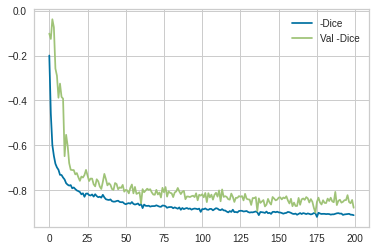

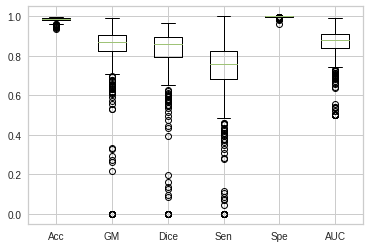

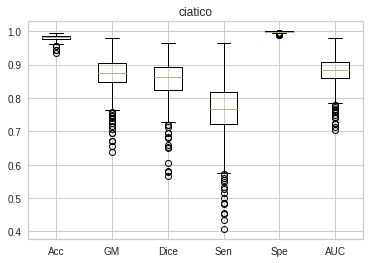

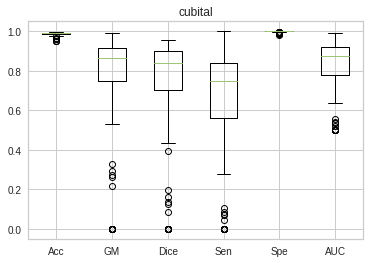

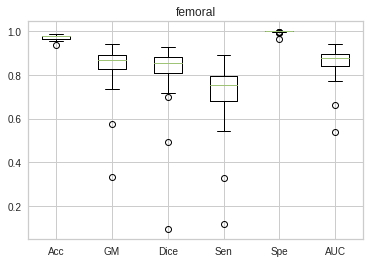

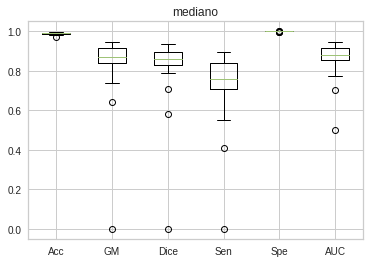

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
37/37 [==============================] - 14s 325ms/step - loss: -0.2053 - iou: 0.1162 - dice_coef: 0.2054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7026 - val_loss: -0.0971 - val_iou: 0.0510 - val_dice_coef: 0.0971 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9370


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 2/200
37/37 [==============================] - 13s 347ms/step - loss: -0.4509 - iou: 0.2931 - dice_coef: 0.4500 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9177 - val_loss: -0.0472 - val_iou: 0.0242 - val_dice_coef: 0.0472 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9379


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 3/200
37/37 [==============================] - 12s 341ms/step - loss: -0.5714 - iou: 0.4035 - dice_coef: 0.5726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9448 - val_loss: -0.0629 - val_iou: 0.0325 - val_dice_coef: 0.0629 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9384


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 4/200
37/37 [==============================] - 11s 316ms/step - loss: -0.6290 - iou: 0.4568 - dice_coef: 0.6238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9520 - val_loss: -0.1642 - val_iou: 0.0896 - val_dice_coef: 0.1642 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9136


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 5/200
37/37 [==============================] - 11s 314ms/step - loss: -0.6488 - iou: 0.4829 - dice_coef: 0.6482 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9548 - val_loss: -0.1600 - val_iou: 0.0870 - val_dice_coef: 0.1600 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8972


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 6/200
37/37 [==============================] - 12s 341ms/step - loss: -0.6807 - iou: 0.5134 - dice_coef: 0.6754 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9606 - val_loss: -0.2704 - val_iou: 0.1565 - val_dice_coef: 0.2704 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8407


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 7/200
37/37 [==============================] - 12s 339ms/step - loss: -0.7031 - iou: 0.5426 - dice_coef: 0.7014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9627 - val_loss: -0.1455 - val_iou: 0.0795 - val_dice_coef: 0.1455 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9027


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 8/200
37/37 [==============================] - 12s 321ms/step - loss: -0.7120 - iou: 0.5564 - dice_coef: 0.7129 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9643 - val_loss: -0.2428 - val_iou: 0.1386 - val_dice_coef: 0.2428 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9237


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 9/200
37/37 [==============================] - 11s 315ms/step - loss: -0.7195 - iou: 0.5602 - dice_coef: 0.7147 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9645 - val_loss: -0.2638 - val_iou: 0.1521 - val_dice_coef: 0.2638 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8211


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 10/200
37/37 [==============================] - 12s 343ms/step - loss: -0.7088 - iou: 0.5499 - dice_coef: 0.7068 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9629 - val_loss: -0.5260 - val_iou: 0.3590 - val_dice_coef: 0.5260 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9426


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 11/200
37/37 [==============================] - 12s 344ms/step - loss: -0.7276 - iou: 0.5758 - dice_coef: 0.7274 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9665 - val_loss: -0.4213 - val_iou: 0.2685 - val_dice_coef: 0.4213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9450


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 12/200
37/37 [==============================] - 12s 321ms/step - loss: -0.7414 - iou: 0.5902 - dice_coef: 0.7388 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9680 - val_loss: -0.5231 - val_iou: 0.3560 - val_dice_coef: 0.5231 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9522


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 13/200
37/37 [==============================] - 11s 313ms/step - loss: -0.7431 - iou: 0.5942 - dice_coef: 0.7427 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9678 - val_loss: -0.5851 - val_iou: 0.4199 - val_dice_coef: 0.5851 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9601


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 14/200
37/37 [==============================] - 12s 343ms/step - loss: -0.7560 - iou: 0.6113 - dice_coef: 0.7560 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9694 - val_loss: -0.5743 - val_iou: 0.4044 - val_dice_coef: 0.5743 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9612


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 15/200
37/37 [==============================] - 13s 349ms/step - loss: -0.7763 - iou: 0.6372 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9724 - val_loss: -0.6168 - val_iou: 0.4511 - val_dice_coef: 0.6168 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9596


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 16/200
37/37 [==============================] - 12s 344ms/step - loss: -0.7743 - iou: 0.6355 - dice_coef: 0.7743 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9718 - val_loss: -0.6243 - val_iou: 0.4591 - val_dice_coef: 0.6243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9630


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 17/200
37/37 [==============================] - 12s 345ms/step - loss: -0.7778 - iou: 0.6417 - dice_coef: 0.7786 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9724 - val_loss: -0.7226 - val_iou: 0.5707 - val_dice_coef: 0.7226 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9664


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 18/200
37/37 [==============================] - 12s 321ms/step - loss: -0.7817 - iou: 0.6472 - dice_coef: 0.7825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9731 - val_loss: -0.7170 - val_iou: 0.5675 - val_dice_coef: 0.7170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9660


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 19/200
37/37 [==============================] - 11s 314ms/step - loss: -0.7845 - iou: 0.6506 - dice_coef: 0.7858 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9727 - val_loss: -0.7044 - val_iou: 0.5522 - val_dice_coef: 0.7044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9650


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 20/200
37/37 [==============================] - 12s 346ms/step - loss: -0.7875 - iou: 0.6536 - dice_coef: 0.7871 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9734 - val_loss: -0.7265 - val_iou: 0.5845 - val_dice_coef: 0.7265 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9686


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 21/200
37/37 [==============================] - 12s 345ms/step - loss: -0.7866 - iou: 0.6518 - dice_coef: 0.7852 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9731 - val_loss: -0.7197 - val_iou: 0.5677 - val_dice_coef: 0.7197 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9650


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 22/200
37/37 [==============================] - 12s 324ms/step - loss: -0.7997 - iou: 0.6716 - dice_coef: 0.8009 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9750 - val_loss: -0.6598 - val_iou: 0.4987 - val_dice_coef: 0.6598 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9664


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 23/200
37/37 [==============================] - 11s 312ms/step - loss: -0.7939 - iou: 0.6595 - dice_coef: 0.7920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9745 - val_loss: -0.7341 - val_iou: 0.5835 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 24/200
37/37 [==============================] - 12s 344ms/step - loss: -0.7883 - iou: 0.6469 - dice_coef: 0.7829 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9734 - val_loss: -0.7307 - val_iou: 0.5857 - val_dice_coef: 0.7307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9659


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 25/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8020 - iou: 0.6730 - dice_coef: 0.8023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9750 - val_loss: -0.5332 - val_iou: 0.3679 - val_dice_coef: 0.5332 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9580


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 26/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8053 - iou: 0.6786 - dice_coef: 0.8057 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9757 - val_loss: -0.7545 - val_iou: 0.6090 - val_dice_coef: 0.7545 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9720


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 27/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8060 - iou: 0.6810 - dice_coef: 0.8058 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -0.7623 - val_iou: 0.6270 - val_dice_coef: 0.7623 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9710


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 28/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8156 - iou: 0.6943 - dice_coef: 0.8166 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9772 - val_loss: -0.7435 - val_iou: 0.6052 - val_dice_coef: 0.7435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9700


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 29/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8150 - iou: 0.6936 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9766 - val_loss: -0.7266 - val_iou: 0.5790 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9690


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 30/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8011 - iou: 0.6698 - dice_coef: 0.7985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.7230 - val_iou: 0.5802 - val_dice_coef: 0.7230 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9685


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 31/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8031 - iou: 0.6718 - dice_coef: 0.7991 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -0.7313 - val_iou: 0.5808 - val_dice_coef: 0.7313 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9695


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 32/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8111 - iou: 0.6909 - dice_coef: 0.8122 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -0.7406 - val_iou: 0.5967 - val_dice_coef: 0.7406 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 33/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8111 - iou: 0.6845 - dice_coef: 0.8101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9766 - val_loss: -0.7016 - val_iou: 0.5501 - val_dice_coef: 0.7016 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 34/200
37/37 [==============================] - 12s 342ms/step - loss: -0.8167 - iou: 0.6945 - dice_coef: 0.8167 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -0.7378 - val_iou: 0.6003 - val_dice_coef: 0.7378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 35/200
37/37 [==============================] - 13s 351ms/step - loss: -0.8216 - iou: 0.6999 - dice_coef: 0.8207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9775 - val_loss: -0.7299 - val_iou: 0.5877 - val_dice_coef: 0.7299 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9701


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 36/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8282 - iou: 0.7121 - dice_coef: 0.8291 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.7640 - val_iou: 0.6376 - val_dice_coef: 0.7640 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 37/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8246 - iou: 0.7035 - dice_coef: 0.8222 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -0.7376 - val_iou: 0.5941 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9695


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 38/200
37/37 [==============================] - 12s 340ms/step - loss: -0.8310 - iou: 0.7138 - dice_coef: 0.8296 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.7684 - val_iou: 0.6391 - val_dice_coef: 0.7684 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9720


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 39/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8299 - iou: 0.7116 - dice_coef: 0.8283 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -0.7727 - val_iou: 0.6380 - val_dice_coef: 0.7727 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 40/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8311 - iou: 0.7171 - dice_coef: 0.8320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.7582 - val_iou: 0.6277 - val_dice_coef: 0.7582 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9696


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 41/200
37/37 [==============================] - 11s 311ms/step - loss: -0.8402 - iou: 0.7290 - dice_coef: 0.8403 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.7745 - val_iou: 0.6513 - val_dice_coef: 0.7745 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 42/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8382 - iou: 0.7258 - dice_coef: 0.8375 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.7502 - val_iou: 0.6110 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9724


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 43/200
37/37 [==============================] - 13s 350ms/step - loss: -0.8382 - iou: 0.7275 - dice_coef: 0.8384 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9797 - val_loss: -0.7897 - val_iou: 0.6621 - val_dice_coef: 0.7897 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 44/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8443 - iou: 0.7357 - dice_coef: 0.8451 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -0.7665 - val_iou: 0.6391 - val_dice_coef: 0.7665 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9725


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 45/200
37/37 [==============================] - 11s 313ms/step - loss: -0.8424 - iou: 0.7277 - dice_coef: 0.8386 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.7784 - val_iou: 0.6513 - val_dice_coef: 0.7784 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 46/200
37/37 [==============================] - 12s 334ms/step - loss: -0.8461 - iou: 0.7359 - dice_coef: 0.8453 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.7616 - val_iou: 0.6277 - val_dice_coef: 0.7616 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9724


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 47/200
37/37 [==============================] - 12s 345ms/step - loss: -0.8486 - iou: 0.7373 - dice_coef: 0.8467 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -0.7081 - val_iou: 0.5606 - val_dice_coef: 0.7081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9666


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 48/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8332 - iou: 0.7212 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.6445 - val_iou: 0.4831 - val_dice_coef: 0.6445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9601


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 49/200
37/37 [==============================] - 11s 312ms/step - loss: -0.8292 - iou: 0.7120 - dice_coef: 0.8270 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9786 - val_loss: -0.7700 - val_iou: 0.6349 - val_dice_coef: 0.7700 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9742


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 50/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8394 - iou: 0.7290 - dice_coef: 0.8407 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -0.7638 - val_iou: 0.6318 - val_dice_coef: 0.7638 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9691


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 51/200
37/37 [==============================] - 12s 345ms/step - loss: -0.8416 - iou: 0.7312 - dice_coef: 0.8402 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.7819 - val_iou: 0.6548 - val_dice_coef: 0.7819 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 52/200
37/37 [==============================] - 12s 339ms/step - loss: -0.8392 - iou: 0.7299 - dice_coef: 0.8392 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.8428 - val_iou: 0.7288 - val_dice_coef: 0.8428 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 53/200
37/37 [==============================] - 13s 352ms/step - loss: -0.8333 - iou: 0.7105 - dice_coef: 0.8300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -0.7363 - val_iou: 0.5933 - val_dice_coef: 0.7363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9700


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 54/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8430 - iou: 0.7319 - dice_coef: 0.8430 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -0.7421 - val_iou: 0.6074 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9715


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 55/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8468 - iou: 0.7400 - dice_coef: 0.8476 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.7746 - val_iou: 0.6532 - val_dice_coef: 0.7746 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 56/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8506 - iou: 0.7469 - dice_coef: 0.8511 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.7773 - val_iou: 0.6551 - val_dice_coef: 0.7773 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 57/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8563 - iou: 0.7531 - dice_coef: 0.8566 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.7678 - val_iou: 0.6488 - val_dice_coef: 0.7678 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 58/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8521 - iou: 0.7488 - dice_coef: 0.8521 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.7896 - val_iou: 0.6664 - val_dice_coef: 0.7896 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 59/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8563 - iou: 0.7509 - dice_coef: 0.8554 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -0.7783 - val_iou: 0.6647 - val_dice_coef: 0.7783 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9734


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 60/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8572 - iou: 0.7549 - dice_coef: 0.8573 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.8073 - val_iou: 0.6888 - val_dice_coef: 0.8073 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 61/200
37/37 [==============================] - 13s 347ms/step - loss: -0.8575 - iou: 0.7574 - dice_coef: 0.8582 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.8041 - val_iou: 0.6841 - val_dice_coef: 0.8041 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 62/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8582 - iou: 0.7584 - dice_coef: 0.8590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.8088 - val_iou: 0.6836 - val_dice_coef: 0.8088 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 63/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8559 - iou: 0.7520 - dice_coef: 0.8555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.7661 - val_iou: 0.6362 - val_dice_coef: 0.7661 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 64/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8570 - iou: 0.7545 - dice_coef: 0.8570 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7895 - val_iou: 0.6767 - val_dice_coef: 0.7895 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 65/200
37/37 [==============================] - 13s 346ms/step - loss: -0.8605 - iou: 0.7621 - dice_coef: 0.8613 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.8049 - val_iou: 0.6856 - val_dice_coef: 0.8049 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 66/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8631 - iou: 0.7643 - dice_coef: 0.8629 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.8002 - val_iou: 0.6862 - val_dice_coef: 0.8002 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 67/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8631 - iou: 0.7626 - dice_coef: 0.8618 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.7958 - val_iou: 0.6766 - val_dice_coef: 0.7958 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 68/200
37/37 [==============================] - 12s 327ms/step - loss: -0.8635 - iou: 0.7668 - dice_coef: 0.8646 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.8011 - val_iou: 0.6880 - val_dice_coef: 0.8011 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 69/200
37/37 [==============================] - 12s 344ms/step - loss: -0.8640 - iou: 0.7656 - dice_coef: 0.8638 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.8202 - val_iou: 0.7013 - val_dice_coef: 0.8202 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 70/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8636 - iou: 0.7670 - dice_coef: 0.8644 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.8005 - val_iou: 0.6832 - val_dice_coef: 0.8005 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 71/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8639 - iou: 0.7678 - dice_coef: 0.8642 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.8035 - val_iou: 0.6752 - val_dice_coef: 0.8035 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 72/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8634 - iou: 0.7661 - dice_coef: 0.8640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.8015 - val_iou: 0.6871 - val_dice_coef: 0.8015 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 73/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8599 - iou: 0.7528 - dice_coef: 0.8551 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.7785 - val_iou: 0.6553 - val_dice_coef: 0.7785 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9724


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 74/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8638 - iou: 0.7621 - dice_coef: 0.8626 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.7770 - val_iou: 0.6583 - val_dice_coef: 0.7770 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9743


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 75/200
37/37 [==============================] - 12s 343ms/step - loss: -0.8578 - iou: 0.7589 - dice_coef: 0.8586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.8089 - val_iou: 0.6969 - val_dice_coef: 0.8089 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 76/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8689 - iou: 0.7727 - dice_coef: 0.8686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.8152 - val_iou: 0.7025 - val_dice_coef: 0.8152 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 77/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8610 - iou: 0.7611 - dice_coef: 0.8583 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -0.7605 - val_iou: 0.6310 - val_dice_coef: 0.7605 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9741


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 78/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8661 - iou: 0.7670 - dice_coef: 0.8657 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.8104 - val_iou: 0.6966 - val_dice_coef: 0.8104 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 79/200
37/37 [==============================] - 12s 345ms/step - loss: -0.8717 - iou: 0.7777 - dice_coef: 0.8721 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8051 - val_iou: 0.6971 - val_dice_coef: 0.8051 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 80/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8724 - iou: 0.7793 - dice_coef: 0.8729 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.7987 - val_iou: 0.6850 - val_dice_coef: 0.7987 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 81/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8704 - iou: 0.7759 - dice_coef: 0.8709 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.7936 - val_iou: 0.6916 - val_dice_coef: 0.7936 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 82/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8719 - iou: 0.7749 - dice_coef: 0.8696 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.8367 - val_iou: 0.7230 - val_dice_coef: 0.8367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 83/200
37/37 [==============================] - 13s 350ms/step - loss: -0.8704 - iou: 0.7768 - dice_coef: 0.8701 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.8102 - val_iou: 0.7057 - val_dice_coef: 0.8102 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 84/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8747 - iou: 0.7841 - dice_coef: 0.8750 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.8290 - val_iou: 0.7184 - val_dice_coef: 0.8290 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 85/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8722 - iou: 0.7796 - dice_coef: 0.8721 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -0.8255 - val_iou: 0.7143 - val_dice_coef: 0.8255 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 86/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8769 - iou: 0.7854 - dice_coef: 0.8768 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8113 - val_iou: 0.7044 - val_dice_coef: 0.8113 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 87/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8774 - iou: 0.7852 - dice_coef: 0.8770 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8273 - val_iou: 0.7149 - val_dice_coef: 0.8273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 88/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8700 - iou: 0.7776 - dice_coef: 0.8692 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.7976 - val_iou: 0.6953 - val_dice_coef: 0.7976 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 89/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8740 - iou: 0.7809 - dice_coef: 0.8726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8147 - val_iou: 0.7070 - val_dice_coef: 0.8147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 90/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8737 - iou: 0.7810 - dice_coef: 0.8737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8661 - val_iou: 0.7642 - val_dice_coef: 0.8661 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 91/200
37/37 [==============================] - 13s 355ms/step - loss: -0.8875 - iou: 0.7979 - dice_coef: 0.8875 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8138 - val_iou: 0.7065 - val_dice_coef: 0.8138 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 92/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8744 - iou: 0.7843 - dice_coef: 0.8740 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8134 - val_iou: 0.7054 - val_dice_coef: 0.8134 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 93/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8759 - iou: 0.7855 - dice_coef: 0.8759 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.7240 - val_iou: 0.5818 - val_dice_coef: 0.7240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9716


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 94/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8799 - iou: 0.7905 - dice_coef: 0.8799 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8113 - val_iou: 0.7078 - val_dice_coef: 0.8113 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 95/200
37/37 [==============================] - 11s 318ms/step - loss: -0.8777 - iou: 0.7897 - dice_coef: 0.8775 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8210 - val_iou: 0.7138 - val_dice_coef: 0.8210 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 96/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8784 - iou: 0.7897 - dice_coef: 0.8782 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8267 - val_iou: 0.7179 - val_dice_coef: 0.8267 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 97/200
37/37 [==============================] - 13s 351ms/step - loss: -0.8783 - iou: 0.7884 - dice_coef: 0.8778 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8147 - val_iou: 0.7069 - val_dice_coef: 0.8147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 98/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8812 - iou: 0.7941 - dice_coef: 0.8816 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8071 - val_iou: 0.7005 - val_dice_coef: 0.8071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 99/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8779 - iou: 0.7916 - dice_coef: 0.8785 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8159 - val_iou: 0.7034 - val_dice_coef: 0.8159 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 100/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8783 - iou: 0.7906 - dice_coef: 0.8791 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8134 - val_iou: 0.7125 - val_dice_coef: 0.8134 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 101/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8838 - iou: 0.7988 - dice_coef: 0.8840 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8356 - val_iou: 0.7289 - val_dice_coef: 0.8356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 102/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8858 - iou: 0.7993 - dice_coef: 0.8862 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8245 - val_iou: 0.7247 - val_dice_coef: 0.8245 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 103/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8812 - iou: 0.7935 - dice_coef: 0.8807 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8307 - val_iou: 0.7237 - val_dice_coef: 0.8307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 104/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8877 - iou: 0.8019 - dice_coef: 0.8877 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8375 - val_iou: 0.7337 - val_dice_coef: 0.8375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 105/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8865 - iou: 0.8021 - dice_coef: 0.8870 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8293 - val_iou: 0.7259 - val_dice_coef: 0.8293 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 106/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8808 - iou: 0.7953 - dice_coef: 0.8816 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8170 - val_iou: 0.7172 - val_dice_coef: 0.8170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 107/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8809 - iou: 0.7936 - dice_coef: 0.8801 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8218 - val_iou: 0.7116 - val_dice_coef: 0.8218 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 108/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8850 - iou: 0.8003 - dice_coef: 0.8852 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8198 - val_iou: 0.7175 - val_dice_coef: 0.8198 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 109/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8856 - iou: 0.7980 - dice_coef: 0.8843 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8187 - val_iou: 0.7126 - val_dice_coef: 0.8187 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 110/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8837 - iou: 0.7966 - dice_coef: 0.8835 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8362 - val_iou: 0.7332 - val_dice_coef: 0.8362 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 111/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8824 - iou: 0.7962 - dice_coef: 0.8820 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8176 - val_iou: 0.7138 - val_dice_coef: 0.8176 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 112/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8840 - iou: 0.7972 - dice_coef: 0.8841 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8378 - val_iou: 0.7293 - val_dice_coef: 0.8378 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 113/200
37/37 [==============================] - 13s 351ms/step - loss: -0.8855 - iou: 0.7953 - dice_coef: 0.8828 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8596 - val_iou: 0.7560 - val_dice_coef: 0.8596 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 114/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8859 - iou: 0.7983 - dice_coef: 0.8848 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8282 - val_iou: 0.7235 - val_dice_coef: 0.8282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 115/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8829 - iou: 0.7958 - dice_coef: 0.8825 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8331 - val_iou: 0.7246 - val_dice_coef: 0.8331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 116/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8834 - iou: 0.7941 - dice_coef: 0.8817 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8228 - val_iou: 0.7167 - val_dice_coef: 0.8228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 117/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8849 - iou: 0.7981 - dice_coef: 0.8851 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8157 - val_iou: 0.7114 - val_dice_coef: 0.8157 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 118/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8855 - iou: 0.8013 - dice_coef: 0.8857 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8338 - val_iou: 0.7310 - val_dice_coef: 0.8338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 119/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8853 - iou: 0.8022 - dice_coef: 0.8861 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8191 - val_iou: 0.7085 - val_dice_coef: 0.8191 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 120/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8874 - iou: 0.8051 - dice_coef: 0.8879 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8431 - val_iou: 0.7408 - val_dice_coef: 0.8431 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 121/200
37/37 [==============================] - 12s 329ms/step - loss: -0.8889 - iou: 0.8054 - dice_coef: 0.8893 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8065 - val_iou: 0.7034 - val_dice_coef: 0.8065 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 122/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8892 - iou: 0.8079 - dice_coef: 0.8890 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8506 - val_iou: 0.7459 - val_dice_coef: 0.8506 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 123/200
37/37 [==============================] - 13s 347ms/step - loss: -0.8883 - iou: 0.8052 - dice_coef: 0.8878 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8132 - val_iou: 0.7054 - val_dice_coef: 0.8132 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 124/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8857 - iou: 0.8055 - dice_coef: 0.8863 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8444 - val_iou: 0.7420 - val_dice_coef: 0.8444 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 125/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8953 - iou: 0.8159 - dice_coef: 0.8958 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8338 - val_iou: 0.7342 - val_dice_coef: 0.8338 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 126/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8908 - iou: 0.8094 - dice_coef: 0.8909 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8533 - val_iou: 0.7524 - val_dice_coef: 0.8533 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 127/200
37/37 [==============================] - 13s 351ms/step - loss: -0.8899 - iou: 0.8080 - dice_coef: 0.8904 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8317 - val_iou: 0.7275 - val_dice_coef: 0.8317 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 128/200
37/37 [==============================] - 12s 333ms/step - loss: -0.8910 - iou: 0.8107 - dice_coef: 0.8910 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8750 - val_iou: 0.7780 - val_dice_coef: 0.8750 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 129/200
37/37 [==============================] - 12s 336ms/step - loss: -0.9012 - iou: 0.8165 - dice_coef: 0.8986 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8449 - val_iou: 0.7449 - val_dice_coef: 0.8449 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 130/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8887 - iou: 0.8089 - dice_coef: 0.8897 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8307 - val_iou: 0.7305 - val_dice_coef: 0.8307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 131/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8860 - iou: 0.8000 - dice_coef: 0.8849 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8233 - val_iou: 0.7250 - val_dice_coef: 0.8233 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 132/200
37/37 [==============================] - 12s 328ms/step - loss: -0.8938 - iou: 0.8155 - dice_coef: 0.8946 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8596 - val_iou: 0.7601 - val_dice_coef: 0.8596 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 133/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8915 - iou: 0.8143 - dice_coef: 0.8926 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8081 - val_iou: 0.7134 - val_dice_coef: 0.8081 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 134/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8925 - iou: 0.8134 - dice_coef: 0.8929 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8197 - val_iou: 0.7161 - val_dice_coef: 0.8197 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 135/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8950 - iou: 0.8178 - dice_coef: 0.8950 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.8502 - val_iou: 0.7524 - val_dice_coef: 0.8502 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 136/200
37/37 [==============================] - 11s 317ms/step - loss: -0.8891 - iou: 0.8075 - dice_coef: 0.8891 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8269 - val_iou: 0.7299 - val_dice_coef: 0.8269 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 137/200
37/37 [==============================] - 13s 353ms/step - loss: -0.8967 - iou: 0.8195 - dice_coef: 0.8973 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8221 - val_iou: 0.7274 - val_dice_coef: 0.8221 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 138/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8888 - iou: 0.8083 - dice_coef: 0.8884 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.8275 - val_iou: 0.7344 - val_dice_coef: 0.8275 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 139/200
37/37 [==============================] - 12s 322ms/step - loss: -0.8956 - iou: 0.8165 - dice_coef: 0.8952 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8399 - val_iou: 0.7434 - val_dice_coef: 0.8399 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 140/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8940 - iou: 0.8145 - dice_coef: 0.8937 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8282 - val_iou: 0.7330 - val_dice_coef: 0.8282 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 141/200
37/37 [==============================] - 13s 348ms/step - loss: -0.8938 - iou: 0.8146 - dice_coef: 0.8939 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8243 - val_iou: 0.7348 - val_dice_coef: 0.8243 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 142/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8948 - iou: 0.8160 - dice_coef: 0.8947 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8325 - val_iou: 0.7397 - val_dice_coef: 0.8325 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 143/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8949 - iou: 0.8152 - dice_coef: 0.8946 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8254 - val_iou: 0.7287 - val_dice_coef: 0.8254 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 144/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8956 - iou: 0.8121 - dice_coef: 0.8922 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8304 - val_iou: 0.7305 - val_dice_coef: 0.8304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 145/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8969 - iou: 0.8200 - dice_coef: 0.8976 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8477 - val_iou: 0.7442 - val_dice_coef: 0.8477 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 146/200
37/37 [==============================] - 12s 331ms/step - loss: -0.8932 - iou: 0.8154 - dice_coef: 0.8933 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8307 - val_iou: 0.7347 - val_dice_coef: 0.8307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 147/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8990 - iou: 0.8217 - dice_coef: 0.8987 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8217 - val_iou: 0.7229 - val_dice_coef: 0.8217 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 148/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8970 - iou: 0.8192 - dice_coef: 0.8966 - sensitivity: 0.9856 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8490 - val_iou: 0.7485 - val_dice_coef: 0.8490 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 149/200
37/37 [==============================] - 13s 350ms/step - loss: -0.8932 - iou: 0.8145 - dice_coef: 0.8927 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8330 - val_iou: 0.7369 - val_dice_coef: 0.8330 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 150/200
37/37 [==============================] - 12s 332ms/step - loss: -0.8976 - iou: 0.8204 - dice_coef: 0.8978 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8148 - val_iou: 0.7155 - val_dice_coef: 0.8148 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 151/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8903 - iou: 0.8084 - dice_coef: 0.8894 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8093 - val_iou: 0.7001 - val_dice_coef: 0.8093 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 152/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8976 - iou: 0.8191 - dice_coef: 0.8983 - sensitivity: 0.9831 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8412 - val_iou: 0.7423 - val_dice_coef: 0.8412 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 153/200
37/37 [==============================] - 13s 348ms/step - loss: -0.9010 - iou: 0.8254 - dice_coef: 0.9018 - sensitivity: 0.9856 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8357 - val_iou: 0.7394 - val_dice_coef: 0.8357 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 154/200
37/37 [==============================] - 12s 326ms/step - loss: -0.8916 - iou: 0.8114 - dice_coef: 0.8900 - sensitivity: 0.9780 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8486 - val_iou: 0.7484 - val_dice_coef: 0.8486 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 155/200
37/37 [==============================] - 13s 349ms/step - loss: -0.8951 - iou: 0.8163 - dice_coef: 0.8953 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8286 - val_iou: 0.7347 - val_dice_coef: 0.8286 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 156/200
37/37 [==============================] - 12s 335ms/step - loss: -0.8993 - iou: 0.8221 - dice_coef: 0.8993 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8423 - val_iou: 0.7442 - val_dice_coef: 0.8423 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 157/200
37/37 [==============================] - 12s 323ms/step - loss: -0.8986 - iou: 0.8233 - dice_coef: 0.8987 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8405 - val_iou: 0.7443 - val_dice_coef: 0.8405 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 158/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8996 - iou: 0.8234 - dice_coef: 0.9001 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8514 - val_iou: 0.7572 - val_dice_coef: 0.8514 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 159/200
37/37 [==============================] - 13s 348ms/step - loss: -0.9043 - iou: 0.8283 - dice_coef: 0.9038 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8440 - val_iou: 0.7462 - val_dice_coef: 0.8440 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 160/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9015 - iou: 0.8251 - dice_coef: 0.9017 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8367 - val_iou: 0.7415 - val_dice_coef: 0.8367 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 161/200
37/37 [==============================] - 12s 324ms/step - loss: -0.8991 - iou: 0.8203 - dice_coef: 0.8979 - sensitivity: 0.9814 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8389 - val_iou: 0.7393 - val_dice_coef: 0.8389 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 162/200
37/37 [==============================] - 11s 316ms/step - loss: -0.8978 - iou: 0.8190 - dice_coef: 0.8969 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8511 - val_iou: 0.7510 - val_dice_coef: 0.8511 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 163/200
37/37 [==============================] - 13s 352ms/step - loss: -0.9007 - iou: 0.8239 - dice_coef: 0.9006 - sensitivity: 0.9823 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8335 - val_iou: 0.7394 - val_dice_coef: 0.8335 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 164/200
37/37 [==============================] - 12s 330ms/step - loss: -0.8966 - iou: 0.8201 - dice_coef: 0.8966 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8350 - val_iou: 0.7435 - val_dice_coef: 0.8350 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 165/200
37/37 [==============================] - 12s 321ms/step - loss: -0.8976 - iou: 0.8218 - dice_coef: 0.8981 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8406 - val_iou: 0.7446 - val_dice_coef: 0.8406 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 166/200
37/37 [==============================] - 12s 319ms/step - loss: -0.8972 - iou: 0.8212 - dice_coef: 0.8972 - sensitivity: 0.9840 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8938 - val_iou: 0.8082 - val_dice_coef: 0.8938 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9870


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 167/200
37/37 [==============================] - 13s 357ms/step - loss: -0.9138 - iou: 0.8404 - dice_coef: 0.9132 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.8546 - val_iou: 0.7594 - val_dice_coef: 0.8546 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 168/200
37/37 [==============================] - 12s 334ms/step - loss: -0.9047 - iou: 0.8303 - dice_coef: 0.9048 - sensitivity: 0.9831 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8366 - val_iou: 0.7441 - val_dice_coef: 0.8366 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 169/200
37/37 [==============================] - 12s 320ms/step - loss: -0.8998 - iou: 0.8257 - dice_coef: 0.8999 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8346 - val_iou: 0.7390 - val_dice_coef: 0.8346 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 170/200
37/37 [==============================] - 11s 314ms/step - loss: -0.8998 - iou: 0.8248 - dice_coef: 0.9002 - sensitivity: 0.9856 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8474 - val_iou: 0.7537 - val_dice_coef: 0.8474 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 171/200
37/37 [==============================] - 13s 351ms/step - loss: -0.9001 - iou: 0.8282 - dice_coef: 0.9007 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8430 - val_iou: 0.7516 - val_dice_coef: 0.8430 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 172/200
37/37 [==============================] - 12s 335ms/step - loss: -0.9010 - iou: 0.8266 - dice_coef: 0.9014 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8705 - val_iou: 0.7782 - val_dice_coef: 0.8705 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 173/200
37/37 [==============================] - 13s 350ms/step - loss: -0.9015 - iou: 0.8225 - dice_coef: 0.9003 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8665 - val_iou: 0.7700 - val_dice_coef: 0.8665 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 174/200
37/37 [==============================] - 12s 329ms/step - loss: -0.9000 - iou: 0.8252 - dice_coef: 0.9003 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8428 - val_iou: 0.7462 - val_dice_coef: 0.8428 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 175/200
37/37 [==============================] - 12s 323ms/step - loss: -0.9012 - iou: 0.8283 - dice_coef: 0.9015 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8364 - val_iou: 0.7379 - val_dice_coef: 0.8364 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 176/200
37/37 [==============================] - 11s 318ms/step - loss: -0.9056 - iou: 0.8310 - dice_coef: 0.9055 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8373 - val_iou: 0.7462 - val_dice_coef: 0.8373 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 177/200
37/37 [==============================] - 13s 351ms/step - loss: -0.9036 - iou: 0.8296 - dice_coef: 0.9038 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8382 - val_iou: 0.7467 - val_dice_coef: 0.8382 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 178/200
37/37 [==============================] - 12s 330ms/step - loss: -0.9002 - iou: 0.8291 - dice_coef: 0.9007 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8453 - val_iou: 0.7520 - val_dice_coef: 0.8453 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 179/200
37/37 [==============================] - 12s 325ms/step - loss: -0.8999 - iou: 0.8265 - dice_coef: 0.8997 - sensitivity: 0.9840 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8391 - val_iou: 0.7500 - val_dice_coef: 0.8391 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 180/200
37/37 [==============================] - 11s 316ms/step - loss: -0.9043 - iou: 0.8328 - dice_coef: 0.9039 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8451 - val_iou: 0.7542 - val_dice_coef: 0.8451 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 181/200
37/37 [==============================] - 13s 350ms/step - loss: -0.8992 - iou: 0.8262 - dice_coef: 0.8994 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8547 - val_iou: 0.7593 - val_dice_coef: 0.8547 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 182/200
37/37 [==============================] - 12s 328ms/step - loss: -0.9017 - iou: 0.8306 - dice_coef: 0.9023 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8394 - val_iou: 0.7451 - val_dice_coef: 0.8394 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 183/200
37/37 [==============================] - 12s 324ms/step - loss: -0.9066 - iou: 0.8289 - dice_coef: 0.9028 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.8390 - val_iou: 0.7529 - val_dice_coef: 0.8390 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 184/200
37/37 [==============================] - 12s 321ms/step - loss: -0.9044 - iou: 0.8327 - dice_coef: 0.9044 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8339 - val_iou: 0.7481 - val_dice_coef: 0.8339 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 185/200
37/37 [==============================] - 13s 348ms/step - loss: -0.9062 - iou: 0.8321 - dice_coef: 0.9060 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8320 - val_iou: 0.7428 - val_dice_coef: 0.8320 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 186/200
37/37 [==============================] - 12s 329ms/step - loss: -0.9023 - iou: 0.8240 - dice_coef: 0.9005 - sensitivity: 0.9840 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8434 - val_iou: 0.7493 - val_dice_coef: 0.8434 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 187/200
37/37 [==============================] - 12s 320ms/step - loss: -0.9016 - iou: 0.8310 - dice_coef: 0.9022 - sensitivity: 0.9806 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8692 - val_iou: 0.7773 - val_dice_coef: 0.8692 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 188/200
37/37 [==============================] - 11s 315ms/step - loss: -0.9019 - iou: 0.8300 - dice_coef: 0.9021 - sensitivity: 0.9823 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8646 - val_iou: 0.7700 - val_dice_coef: 0.8646 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 189/200
37/37 [==============================] - 13s 349ms/step - loss: -0.9040 - iou: 0.8332 - dice_coef: 0.9046 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8352 - val_iou: 0.7474 - val_dice_coef: 0.8352 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 190/200
37/37 [==============================] - 12s 341ms/step - loss: -0.9073 - iou: 0.8383 - dice_coef: 0.9076 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8559 - val_iou: 0.7646 - val_dice_coef: 0.8559 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 191/200
37/37 [==============================] - 12s 320ms/step - loss: -0.9005 - iou: 0.8320 - dice_coef: 0.9013 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8569 - val_iou: 0.7607 - val_dice_coef: 0.8569 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 192/200
37/37 [==============================] - 11s 317ms/step - loss: -0.9048 - iou: 0.8326 - dice_coef: 0.9052 - sensitivity: 0.9780 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8538 - val_iou: 0.7558 - val_dice_coef: 0.8538 - val_sensitivity: 0.9757 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 193/200
37/37 [==============================] - 13s 350ms/step - loss: -0.9052 - iou: 0.8332 - dice_coef: 0.9052 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8342 - val_iou: 0.7438 - val_dice_coef: 0.8342 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 194/200
37/37 [==============================] - 13s 348ms/step - loss: -0.9072 - iou: 0.8356 - dice_coef: 0.9076 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.8397 - val_iou: 0.7457 - val_dice_coef: 0.8397 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 195/200
37/37 [==============================] - 13s 352ms/step - loss: -0.9064 - iou: 0.8335 - dice_coef: 0.9060 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8597 - val_iou: 0.7684 - val_dice_coef: 0.8597 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 196/200
37/37 [==============================] - 12s 329ms/step - loss: -0.9088 - iou: 0.8397 - dice_coef: 0.9093 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.8448 - val_iou: 0.7514 - val_dice_coef: 0.8448 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 197/200
37/37 [==============================] - 12s 323ms/step - loss: -0.9002 - iou: 0.8272 - dice_coef: 0.8994 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8538 - val_iou: 0.7549 - val_dice_coef: 0.8538 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 198/200
37/37 [==============================] - 11s 315ms/step - loss: -0.8947 - iou: 0.8215 - dice_coef: 0.8951 - sensitivity: 0.9848 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8600 - val_iou: 0.7600 - val_dice_coef: 0.8600 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 199/200
37/37 [==============================] - 13s 352ms/step - loss: -0.9017 - iou: 0.8293 - dice_coef: 0.9022 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8403 - val_iou: 0.7450 - val_dice_coef: 0.8403 - val_sensitivity: 0.9757 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


Epoch 200/200
37/37 [==============================] - 12s 331ms/step - loss: -0.9003 - iou: 0.8299 - dice_coef: 0.9005 - sensitivity: 0.9814 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8412 - val_iou: 0.7483 - val_dice_coef: 0.8412 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-0.9_phi-units-128/Model_Checkpoint/assets


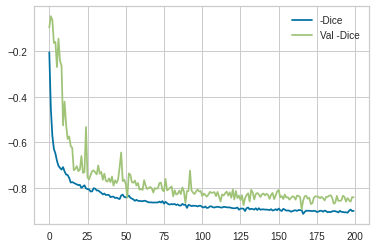

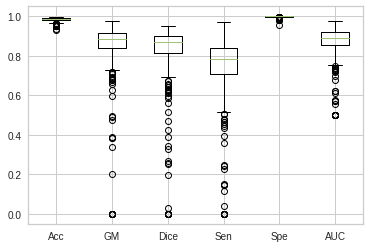

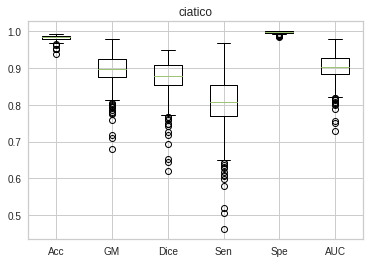

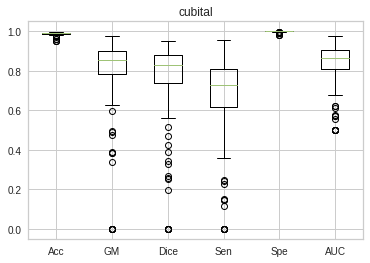

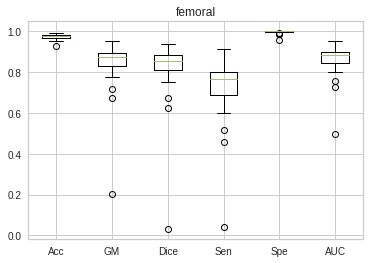

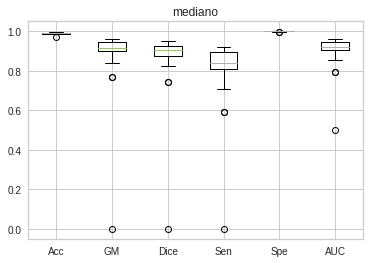

In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 0.9
# phi_units = 16
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for phi_units in [8,16,32,64,128]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    _ = 1

  tf.keras.backend.clear_session()

  seg_model = fcn((height,width),phi_units,ch_out=3)

  seg_model.compile(optimizer=Adam(lr=1e-3,clipnorm=5.0),
                    loss={'output':dice_coef_loss},
                    metrics = {'output':metrics})

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  test_t = df_test_images['nerve_name'].to_list()

  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = np.array(Image.open(path_file).resize((height,width)))
    mask = np.array(Image.open(mask_file).resize((height,width))).reshape(-1,)
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1))
    AUC.append(roc_auc_score(mask,mask_est))

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,
          'nerve_name':test_t}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  plt.savefig(basepath+'/Boxplot_all')
  plt.show()

  for name_nerve in ['ciatico','cubital','femoral','mediano']:
    Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    plt.boxplot([Acc_aux,GM_aux,Dice_aux,Sen_aux,Spe_aux,AUC_aux])
    plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
    plt.title(name_nerve)
    plt.savefig(basepath+'/Boxplot_{}'.format(name_nerve))
    plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results_FCN_RFF ./results*  model.png

  adding: results_a-0.9_phi-units-128/ (stored 0%)
  adding: results_a-0.9_phi-units-128/Boxplot_ciatico.png (deflated 9%)
  adding: results_a-0.9_phi-units-128/Boxplot_femoral.png (deflated 13%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/ (stored 0%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/variables/variables.index (deflated 76%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-0.9_phi-units-128/Model_Checkpoint/keras_metadata.pb (deflated 94%)
  adding: results_a-0.9_phi-units-128/Boxplot_all.png (deflated 10%)
  adding: results_a-0.9_phi-units-128/results.joblib (deflated 76%)
  adding: results_a-0.9_phi-units-128/Boxplot_cubital.png (deflated 

In [ ]:
from google.colab import files
files.download('results.xlsx')
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp results_FCN_RFF.zip ./gdrive/MyDrive/